In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import spearmanr
from statsmodels.api import qqplot, add_constant

from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score, log_loss,\
classification_report, roc_curve, confusion_matrix
from sklearn.dummy import DummyClassifier

from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor

import random
from tqdm import tqdm
import joblib

In [3]:
RND_STATE = 777

In [15]:
datasets_names = ["Тренировочный", "Валидационный", "Контрольный"]
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col=0)
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col=0)
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col=0)

datasets = [train, valid, test]

На данном этапе нам необходимо подготовить данные для обучения модели логистической регрессии. Для этого нам необходимо провести следующие операции: 

* Предварительно можно создать дополнительные фичи

1) приведем количественные признаки к нормальному распределению; 

2) выполним масштабирование количественных данных; 

3) применим кодировщик для категориальных данных;

4) отберем признаки (уменьшим размерность).

# Нормализация распределения количественных переменных

В отличие от линейной регрессии, логистическая регрессия не полагается на предположение о нормальном распределении. Однако, решение может стать более стабильным, если распределение предикторов будет многомерным нормальным.

Для этого можно применить преобразование Бокса-Кокса для количественных столбцов.

Однако, стоит помнить, что **$\lambda$ берется с обучающих данных и с ее помощью преобразуются тестовые и контрольные данные**.

In [16]:
quant_cols = train.dtypes[(train.dtypes == int) | (train.dtypes == float)].index

Преобразование Бокса-Кокса требует от данных положительного знака.
$$y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n$$

$$y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda - 1}{\lambda};\text{если } \lambda \neq 0,\\ \log{(y_i)}; \text{если } \lambda = 0.\end{cases}$$ 
Можно посмотреть, в каких предикторах у нас имеются отрицательные значения.

In [17]:
(train[quant_cols] <= 0).sum()

age                          0
credit_sum                   0
score_shk                    2
monthly_income               0
credit_count             24494
overdue_credit_count    114365
month_payment                0
payment_income_part          0
dtype: int64

In [18]:
for col in ['score_shk', 'credit_count', 'overdue_credit_count']:
    print(f'{col} {train[train[col] <= 0][col].unique()}')

score_shk [0.]
credit_count [ 0. -1.]
overdue_credit_count [ 0. -1.]


Таким образом, в колонке `score_shk` у нас присутствует одно значение равное 0, в колонках `credit_count` и `overdue_credit_count` есть два значения, 0 - нет кредитов данной категории, а -1 означает, что нет информации по данной переменной. Можно прибавить к данным колонкам 0.0001 и 1.0001 соответственно.

Также можно добавить колонки, отражающие наличие пропусков в `credit_count` и `overdue_credit_count`, далее мы все равно проведем дамми-кодирование новых переменных.

In [19]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col + '_na'] = np.where((df[col] == -1), 1, 0).astype('object')

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.08it/s]


In [20]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col] = df[col] + 1.0001
        
for df in datasets:
    df['score_shk'] = df['score_shk'] + 0.0001

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.50it/s]


In [21]:
(train[quant_cols] <= 0).sum()
# Теперь у нас нет отрицательных и нулевых значений

age                     0
credit_sum              0
score_shk               0
monthly_income          0
credit_count            0
overdue_credit_count    0
month_payment           0
payment_income_part     0
dtype: int64

In [22]:
quant_cols =['age', 'credit_sum', 'monthly_income',
             'credit_count', 'overdue_credit_count', 'score_shk',
             'month_payment', 'payment_income_part']

Lambda for age: -0.318


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_sum: 0.038


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for monthly_income: -0.146


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_count: 0.520


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for overdue_credit_count: 0.935


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for score_shk: 0.644


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for month_payment: -0.068


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for payment_income_part: 0.148


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


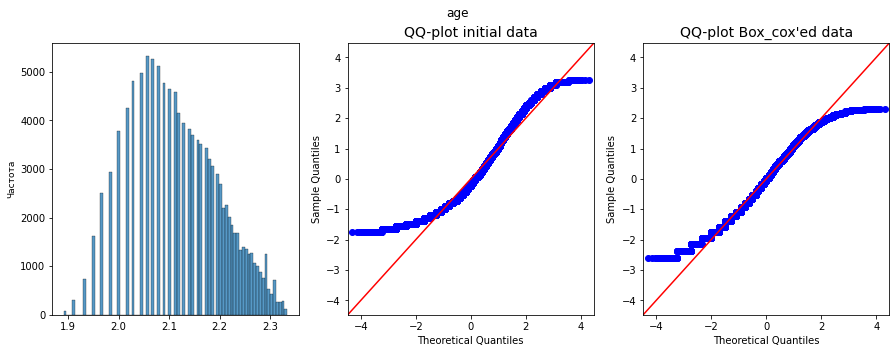

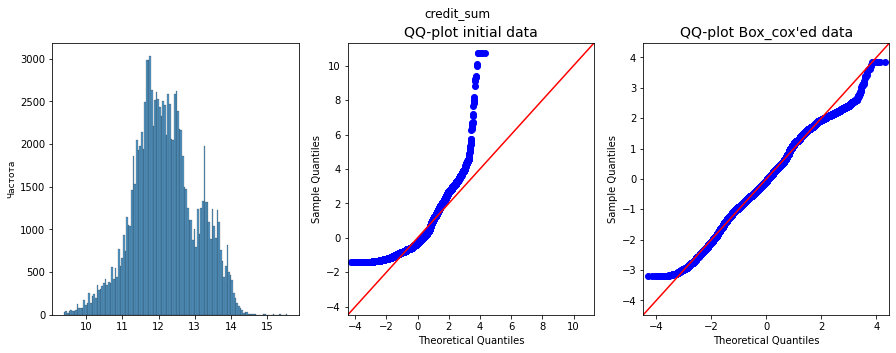

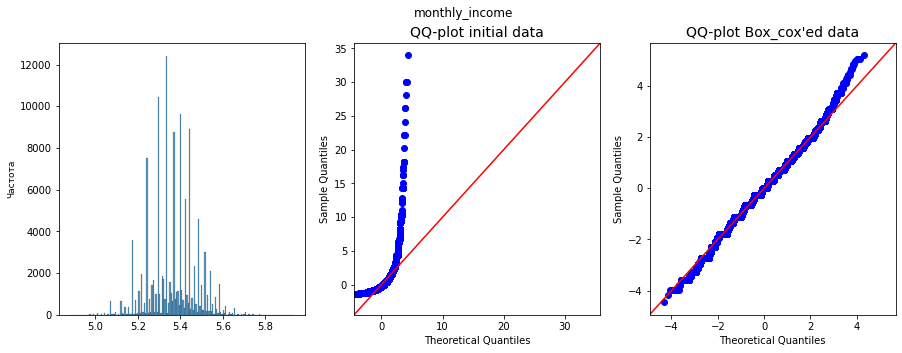

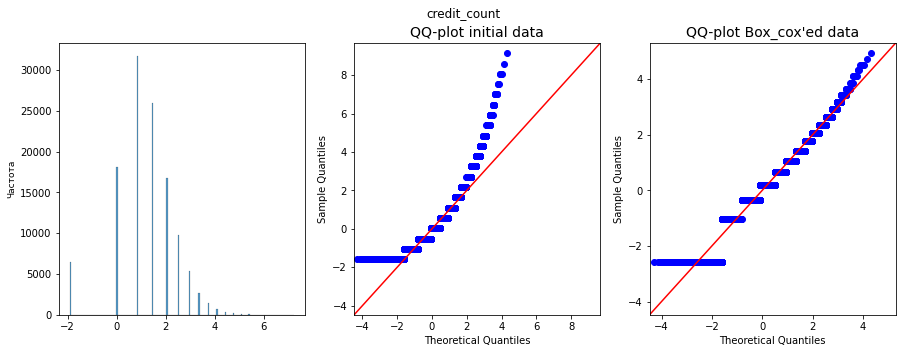

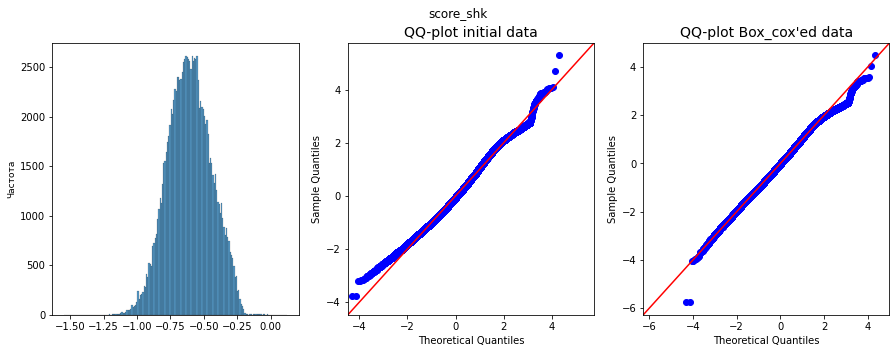

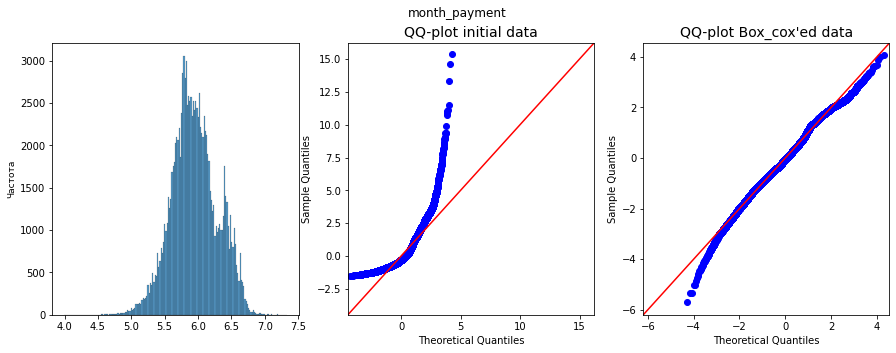

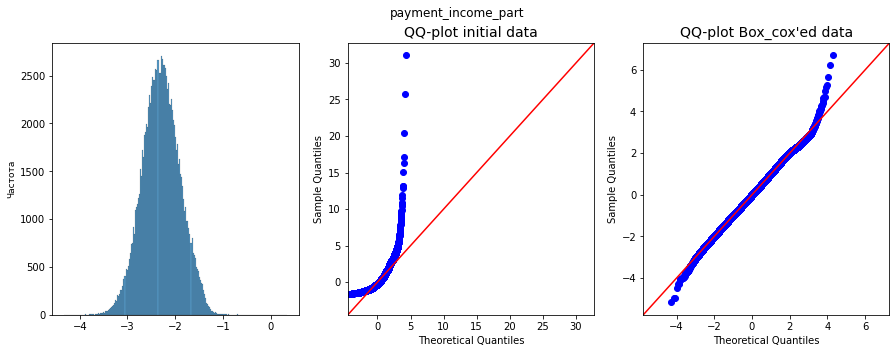

In [23]:
for col in quant_cols:
    transformed, lam = boxcox(train[col])
    print(f'Lambda for {col}: {lam:.3f}')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(transformed, ax=ax[0])
    qqplot(train[col], norm, fit=True, line='45', ax=ax[1])
    qqplot(transformed, norm, fit=True, line='45', ax=ax[2])

    ax[0].set_ylabel('Частота', fontsize=9)
    ax[1].set_title("QQ-plot initial data", fontsize=14)
    ax[2].set_title("QQ-plot Box_cox'ed data", fontsize=14)
    fig.suptitle(col)

Можно заметить, что преобразование Бокса-Кокса не обязательно для `credit_count`, `overdue_credit_count`, `score_shk`, поскольку не приводит к значимому улучшению вида распределения переменной. Таким образом, нам надо преобразовать колонки `age`, `credit_sum`, `monthly_income`. Во избежание нулевых значений в тестовом и контрольных наборах до преобразования прибавим к ним 0.0001.

In [24]:
transformation_lambdas = {}
for col in tqdm(quant_cols):
    for ind, df in enumerate(datasets):
        df[col] = df[col] + 0.0001
        if ind == 0: # Поскольку у нас тренировочный датасет первый в списке
            df[col], lam = boxcox(df[col])    
            transformation_lambdas[col] = lam
        else:
            df[col]= boxcox(df[col], lam)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.72it/s]


In [25]:
transformation_lambdas

{'age': -0.3178831313449778,
 'credit_sum': 0.03838551579008124,
 'monthly_income': -0.14564076859225772,
 'credit_count': 0.5298297530853822,
 'overdue_credit_count': 0.9570711126311593,
 'score_shk': 0.6436609437954757,
 'month_payment': -0.06819472893275555,
 'payment_income_part': 0.14570054875925367}

In [26]:
train['monthly_income']

87470     5.285763
77449     5.295132
97073     5.336300
6498      5.336300
156564    5.513909
            ...   
83528     5.320850
138673    5.151297
141915    5.385221
35227     5.370265
125619    5.539954
Name: monthly_income, Length: 119522, dtype: float64

Проведем кодирование категориальных переменных по методу "с одним активным состоянием".

In [27]:
cat_cols = train.dtypes[train.dtypes == 'object'].index

In [28]:
train_label = pd.get_dummies(train, columns=cat_cols, drop_first=True)
valid_label = pd.get_dummies(valid, columns=cat_cols, drop_first=True)
test_label = pd.get_dummies(test, columns=cat_cols, drop_first=True)

In [29]:
X_train = train_label.drop('open_account_flg', axis=1)
y_train = train_label['open_account_flg']

X_valid = valid_label.drop('open_account_flg', axis=1)
y_valid = valid_label['open_account_flg']

X_test = test_label.drop('open_account_flg', axis=1)
y_test = test_label['open_account_flg']

Также необходимо стандартизовать данные (поскольку у нас не все предикторы имеют нормальное распределение, то лучше воспользоваться классом RobustScaler, который устойчив к выбросам).

In [30]:
scaler = RobustScaler()
scaler.fit(X_train)

X_tr_scaled = pd.DataFrame(scaler.transform(X_train.values),
                           columns=X_train.columns,
                           index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_valid.values),
                            columns=X_valid.columns,
                            index=X_valid.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X_test.columns,
                             index=X_test.index)

In [31]:
lr_metrics = pd.DataFrame(index=['roc-auc', 'precision',
                                 'recall', 'f1', 'logloss'])

In [32]:
dummy = DummyClassifier(strategy='stratified', random_state=RND_STATE)
dummy.fit(X_tr_scaled, y_train)

y_pred = dummy.predict(X_val_scaled)
y_score = dummy.predict_proba(X_val_scaled)[:,1]
    
lr_metrics['DummyClassifier'] = [roc_auc_score(y_valid, y_score),
                              precision_score(y_valid, y_pred),
                              recall_score(y_valid, y_pred),
                              f1_score(y_valid, y_pred),
                              log_loss(y_valid, y_pred)]
    
fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score)

roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

plt.plot(fpr_baseline, tpr_baseline, color='orange',
             label=f'ROC curve (area = {roc_auc_baseline:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('DummyClassifier ROC AUC')
plt.legend(loc="lower right")
plt.show()

In [33]:
lr_metrics

DummyClassifier
roc-auc           0.500769
precision         0.177318
recall            0.173150
f1                0.175209
logloss           9.910890

# Baseline-модель

In [29]:
def make_log_reg(x_train, y_train, x_valid, y_valid,
                 results_df, model_name, parameters={'max_iter':1500}):  
    log_reg_model =  LogisticRegression(**parameters,
                                        class_weight = 'balanced',
                                        random_state=RND_STATE)
    log_reg_model.fit(x_train, y_train)
    
    y_pred = log_reg_model.predict(x_valid)
    y_score = log_reg_model.predict_proba(x_valid)[:,1]
    
    results_df[model_name] = [roc_auc_score(y_valid, y_score),
                              precision_score(y_valid, y_pred),
                              recall_score(y_valid, y_pred),
                              f1_score(y_valid, y_pred),
                              log_loss(y_valid, y_pred)]
    
    fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score)

    roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

    plt.plot(fpr_baseline, tpr_baseline, color='orange',
             label=f'ROC curve (area = {roc_auc_baseline:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Logistic Regression ROC AUC')
    plt.legend(loc="lower right")
    plt.show()
    return log_reg_model

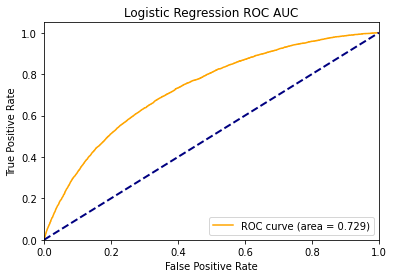

In [35]:
lr_baseline = make_log_reg(x_train=X_tr_scaled,
                           y_train=y_train,
                           x_valid=X_val_scaled,
                           y_valid=y_valid,
                           results_df=lr_metrics,
                           model_name='lr_baseline')

In [36]:
lr_metrics

DummyClassifier  lr_baseline
roc-auc           0.500769     0.729256
precision         0.177318     0.308196
recall            0.173150     0.646085
f1                0.175209     0.417322
logloss           9.910890    10.968681

# Подбор оптимальных гиперпараметров

In [56]:
def find_optimal_params(x_train, y_train, parameters_grid,
                        cv_n_splits=5, n_jobs=-1):
    lr_basic_params = {
        'class_weight':'balanced',
        'random_state':RND_STATE
    }
    
    log_reg = LogisticRegression(**lr_basic_params)
    strat_cv = StratifiedKFold(n_splits=cv_n_splits,
                               shuffle=True)
    
    grid_cv = GridSearchCV(log_reg,
                           parameters_grid,
                           scoring='roc_auc',
                           cv=strat_cv,
                           verbose=10,
                           n_jobs=n_jobs)   
    
    grid_cv.fit(x_train, y_train)
    print(f'Наилучший ROC AUC = {grid_cv.best_score_:.4f}')
    print(f'Наилучшие параметры: {grid_cv.best_params_}')
    return grid_cv

In [38]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(0.1, 1000, num=5),
    'solver': ['sag', 'liblinear', 'lbfgs'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(400, 2000, 200)
}

In [39]:
!telegram-send "grid_baseline_cv optimization started!"

In [40]:
%%time
grid_baseline_cv = find_optimal_params(x_train=X_tr_scaled,
                                       y_train=y_train,
                                       parameters_grid=parameters_grid)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


One or more of the test scores are non-finite: [       nan 0.73067374        nan ...        nan        nan        nan]
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Наилучший ROC AUC = 0.7316
Наилучшие параметры: {'C': 1000.0, 'l1_ratio': 0.2, 'max_iter': 800, 'penalty': 'l2', 'solver': 'lbfgs'}
Wall time: 7h 45min 6s


In [41]:
!telegram-send "grid_baseline_cv optimized!"

Traceback (most recent call last):
  File "c:\program files\python39\lib\site-packages\telegram\vendor\ptb_urllib3\urllib3\connection.py", line 140, in _new_conn
    conn = connection.create_connection(
  File "c:\program files\python39\lib\site-packages\telegram\vendor\ptb_urllib3\urllib3\util\connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\program files\python39\lib\socket.py", line 953, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\program files\python39\lib\site-packages\telegram\vendor\ptb_urllib3\urllib3\connectionpool.py", line 614, in urlopen
    httplib_response = self._make_request(conn, method, url,
  File "c:\program files\python39\lib\site-packages\telegram\vendor\ptb_urllib3\urllib3

In [42]:
baseline_best_params = grid_baseline_cv.best_params_

In [45]:
# baseline_best_params = {'C': 1000.0,
#                         'l1_ratio': 0.2,
#                         'max_iter': 800,
#                         'penalty': 'l2',
#                         'solver': 'lbfgs'}

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


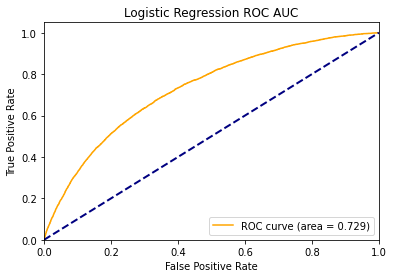

In [46]:
lr_baseline_tuned = make_log_reg(x_train=X_tr_scaled,
                                 y_train=y_train,
                                 x_valid=X_val_scaled,
                                 y_valid=y_valid,
                                 results_df=lr_metrics,
                                 parameters=baseline_best_params,
                                 model_name='lr_baseline_tuned')

In [47]:
lr_metrics[:-1].style.highlight_max(axis=1, color='lightblue')

Можно заметить, что производительность модели возрасла лишь слегка, что, возможно, связано с предупреждениями, которые мы получили в ходе обучения модели. Проверим первое предположение со StackOverflow о различии колонок в датасетах.

Мы получили следующее предупреждение:

*warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\глеб\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite*

На StackOverflow есть несколько мыслей по этому поводу:
1. [В проверочном и обучающем наборе есть различия в категориях, поэтому когда на проверочном датасете появляется категория, которая отсутствует в обучающем наборе, то логистическая регрессия выдает NaN.](https://stackoverflow.com/questions/66620269/i-got-the-warning-userwarning-one-or-more-of-the-test-scores-are-non-finite-w)
2. [Второе решение возможно, кроется в комбинации гиперпараметров, которые могут приводить к NaN-значениям.](https://stackoverflow.com/questions/67535904/userwarning-one-or-more-of-the-test-scores-are-non-finite-warning-only-when-a)

В первом случае необходимо проверить, что предикторы во всех наборах одинаковы, а во втором посмотреть в `grid_cv.cv_results_` сочетания гиперпараметров, которые приводят к неопределенным значениям.

Однако, для начала, можно посмотреть на показатели качества полученной с предупреждениями модели.

In [48]:
print((X_valid.columns == X_train.columns).all())
print((X_test.columns == X_train.columns).all())

True
True


Таким образом, видно, что проблема не в различных категориях.

Тогда проверим кроется ли проблема в сочетаниях гиперпараметров.

In [51]:
grid_results = pd.DataFrame(grid_baseline_cv.cv_results_)
bad_grid_results = grid_results[grid_results['split0_test_score'].isna()]

In [52]:
bad_grid_results['param_solver'].unique()
# Проблемы есть только с 'sag', 'lbfgs'

array(['sag', 'lbfgs', 'liblinear'], dtype=object)

In [53]:
bad_grid_results[bad_grid_results['param_solver'] == 'sag'].head(6)
# Видим, что оптимизатор sag работет только с регуляризацией l2 - лассо.

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.272283      0.021751              0.0             0.0     0.1   
6        0.355052      0.009120              0.0             0.0     0.1   
9        0.334295      0.007653              0.0             0.0     0.1   
15       0.311448      0.008415              0.0             0.0     0.1   
18       0.346794      0.006249              0.0             0.0     0.1   
24       0.318347      0.015423              0.0             0.0     0.1   

   param_l1_ratio param_max_iter param_penalty param_solver  \
0             0.2            400            l1          sag   
6             0.2            400    elasticnet          sag   
9             0.2            600            l1          sag   
15            0.2            600    elasticnet          sag   
18            0.2            800            l1          sag   
24            0.2            800    elasticnet          sag   

                                               params  split0_test_score  \
0   {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 400, '...                NaN   
6   {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 400, '...                NaN   
9   {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 600, '...                NaN   
15  {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 600, '...                NaN   
18  {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 800, '...                NaN   
24  {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 800, '...                NaN   

    split1_test_score  split2_test_score  split3_test_score  \
0                 NaN                NaN                NaN   
6                 NaN                NaN                NaN   
9                 NaN                NaN                NaN   
15                NaN                NaN                NaN   
18                NaN                NaN                NaN   
24                NaN                NaN                NaN   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
0                 NaN              NaN             NaN              708  
6                 NaN              NaN             NaN             1089  
9                 NaN              NaN             NaN             1092  
15                NaN              NaN             NaN             1094  
18                NaN              NaN             NaN             1097  
24                NaN              NaN             NaN             1099

In [54]:
bad_grid_results[bad_grid_results['param_solver'] == 'lbfgs'].head(6)
# Видим, что оптимизатор lbfgs работет только с регуляризацией l2 - лассо.

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
2        0.303024      0.027707              0.0             0.0     0.1   
8        0.361822      0.025066              0.0             0.0     0.1   
11       0.336501      0.023259              0.0             0.0     0.1   
17       0.340545      0.020722              0.0             0.0     0.1   
20       0.380574      0.036314              0.0             0.0     0.1   
26       0.375795      0.025147              0.0             0.0     0.1   

   param_l1_ratio param_max_iter param_penalty param_solver  \
2             0.2            400            l1        lbfgs   
8             0.2            400    elasticnet        lbfgs   
11            0.2            600            l1        lbfgs   
17            0.2            600    elasticnet        lbfgs   
20            0.2            800            l1        lbfgs   
26            0.2            800    elasticnet        lbfgs   

                                               params  split0_test_score  \
2   {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 400, '...                NaN   
8   {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 400, '...                NaN   
11  {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 600, '...                NaN   
17  {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 600, '...                NaN   
20  {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 800, '...                NaN   
26  {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 800, '...                NaN   

    split1_test_score  split2_test_score  split3_test_score  \
2                 NaN                NaN                NaN   
8                 NaN                NaN                NaN   
11                NaN                NaN                NaN   
17                NaN                NaN                NaN   
20                NaN                NaN                NaN   
26                NaN                NaN                NaN   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
2                 NaN              NaN             NaN             1088  
8                 NaN              NaN             NaN             1091  
11                NaN              NaN             NaN             1093  
17                NaN              NaN             NaN             1096  
20                NaN              NaN             NaN             1098  
26                NaN              NaN             NaN             1102

In [55]:
bad_grid_results['mean_score_time'].mean()

0.0

Мы также могли прийти к таким же выводам посмотрев предупреждения в ходе поиска по сетке:

*ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.*

Однако, если посмотреть на среднее время вычислений при таких комбинациях, то оно равно 0, т.е. мы не теряем в производительности поиска оптимальных гиперпараметров.

Таким образом, оптимиизация гиперпараметров не дала ощутимых результатов, следовательно, улучшение модели можно провести путем создания различных переменных, которые должны внести нелинейные взаимодействия в модель логистической регрессии.

# Добавление новых предикторов

In [56]:
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col = 0).copy()
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col = 0).copy()
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col = 0).copy()

datasets = [train, valid, test]

In [57]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col + '_na'] = np.where((df[col] == -1), 1, 0).astype('object')

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.53it/s]


In [58]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col] = df[col] + 1.0001
        
for df in datasets:
    df['score_shk'] = df['score_shk'] + 0.0001

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 401.37it/s]


Теперь создадим переменные - средние значения количественной переменной, взятые по уровню категориальной переменной. А также сравним показатель клиента с этим средним значением. 

Например, колонка `score_is_gt_median_education` отображает превосходит ли внутренняя скоринговая оценка клиента медианное значение для людей с таким же образованием.

In [59]:
categorical_cols = ['living_region', 'gender',
                    'marital_status', 'job_position',
                    'education']

quantitative_cols = ['age', 'credit_sum', 'credit_month',
                     'score_shk', 'monthly_income',
                     'credit_count', 'overdue_credit_count']

category_col_names = dict(zip(categorical_cols, ['region', 'gender',
                                                 'marital', 'job', 'education']))

quantitative_col_names = dict(zip(quantitative_cols, ['age','cr_sum', 'cr_month',
                                                      'score', 'income', 'cr_count',
                                                      'overdue_count']))

for category in tqdm(categorical_cols):
    for indicator in quantitative_cols:
        grouped = train.groupby(category)[indicator].agg(np.median).to_dict()
        median_col_name = category_col_names[category] + '_median_' +  quantitative_col_names[indicator]
        is_gt_median_col_name = quantitative_col_names[indicator] + '_is_gt_median_' + category_col_names[category]             
        for df in datasets:
            df[median_col_name] = df[category].map(grouped)                      
            df[is_gt_median_col_name] = np.where(df[indicator] >= df[median_col_name], '1', '0')
            df.drop(median_col_name, axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.25it/s]


In [60]:
for indicator in tqdm(quantitative_cols):
    for df in datasets:
        df[indicator + '_sq'] = df[indicator] ** 2
        df[indicator + '_inv'] = (1 / df[indicator]).replace([np.inf, -np.inf], -1)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 219.34it/s]


In [61]:
quantitative_cols = ['age', 'credit_sum', 'monthly_income',
                     'month_payment', 'payment_income_part'] + list(train.columns)[-14:]

Lambda for age: -0.318


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_sum: 0.038


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for monthly_income: -0.146


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for month_payment: -0.068


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for payment_income_part: 0.148


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for age_sq: -0.159


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for age_inv: 0.318


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_sum_sq: 0.019


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_sum_inv: -0.038


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_month_sq: 0.037


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_month_inv: -0.074


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for score_shk_sq: 0.322


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for score_shk_inv: -0.644


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for monthly_income_sq: -0.073


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for monthly_income_inv: 0.146


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_count_sq: 0.260


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for credit_count_inv: -0.520


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


Lambda for overdue_credit_count_sq: 0.467
Lambda for overdue_credit_count_inv: -0.935


marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


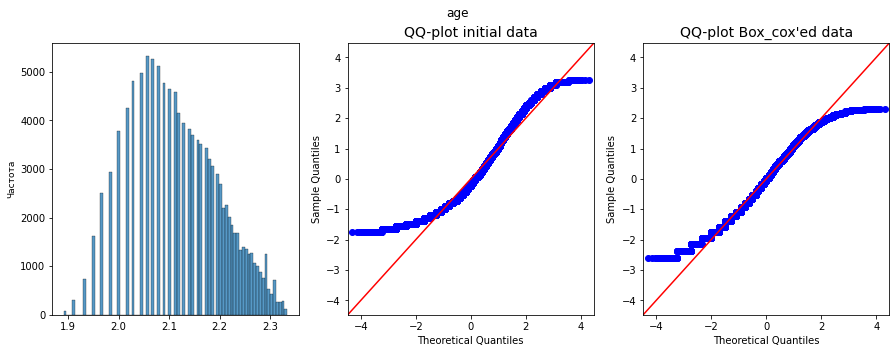

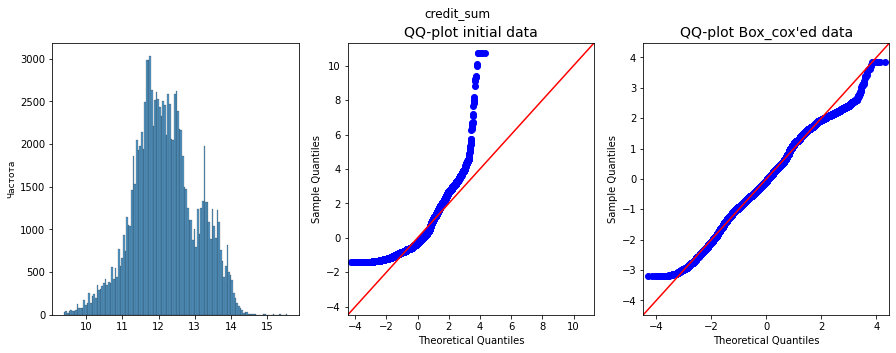

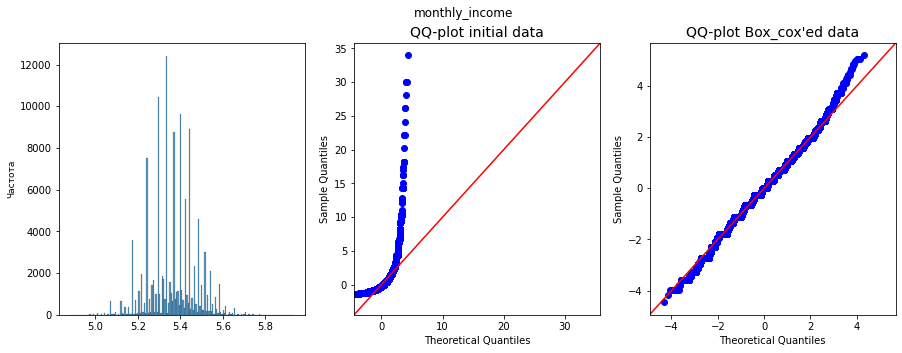

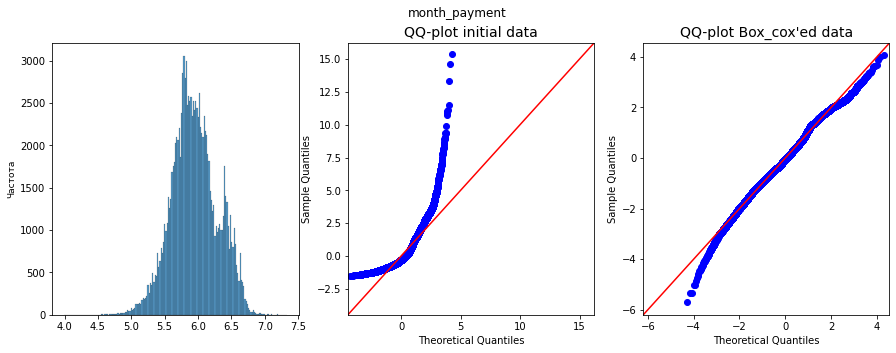

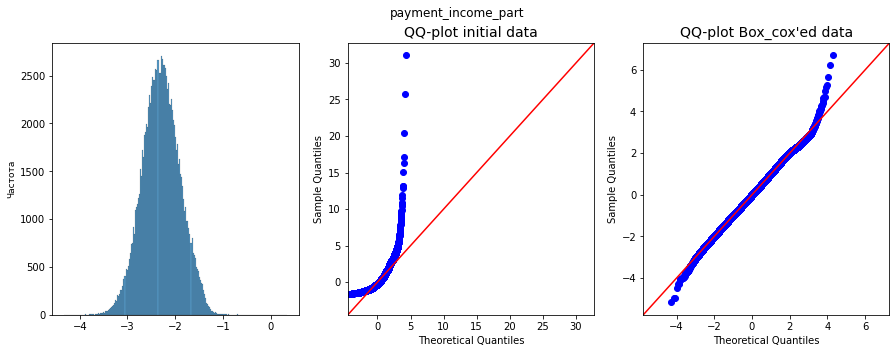

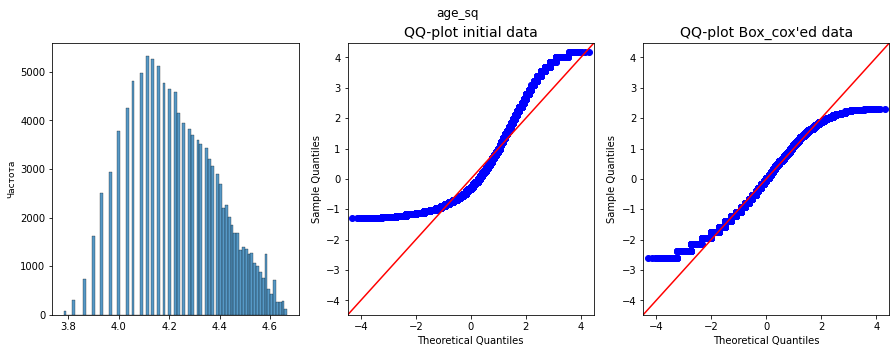

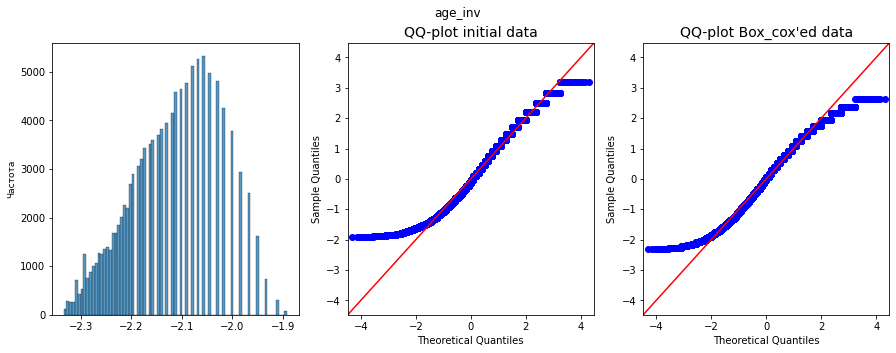

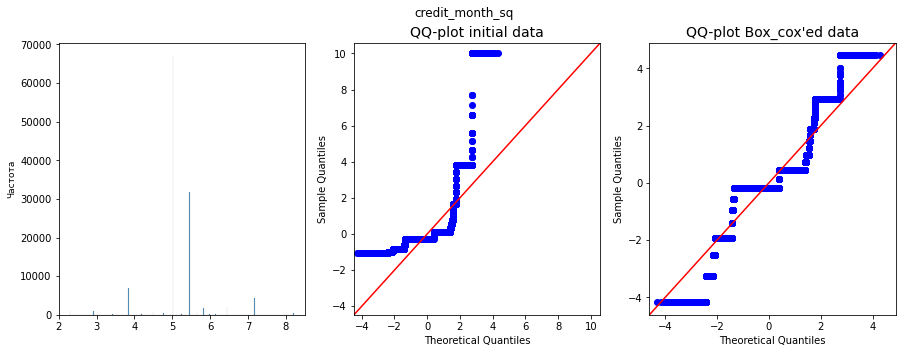

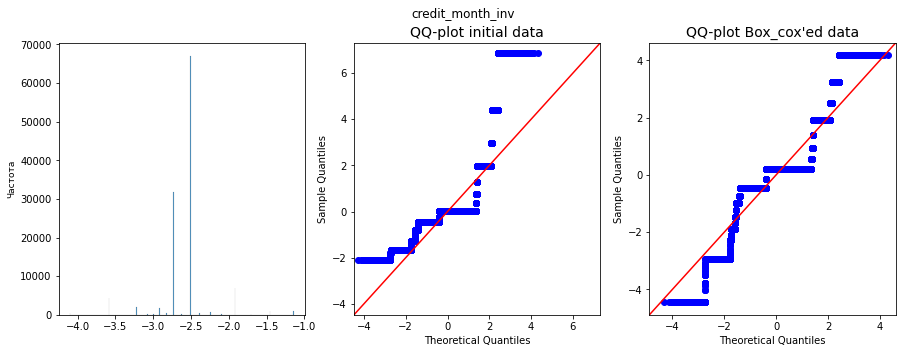

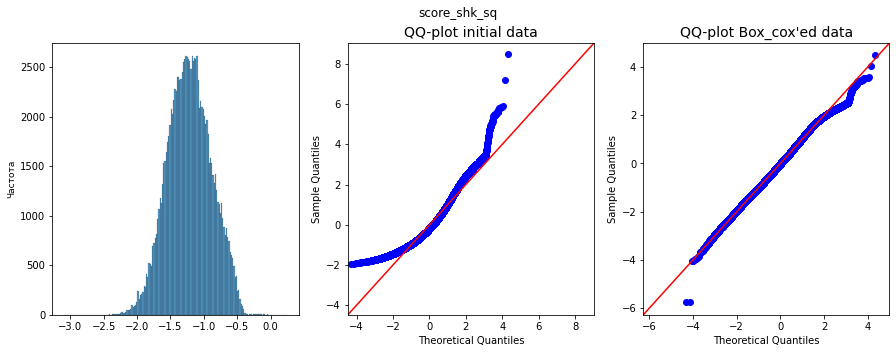

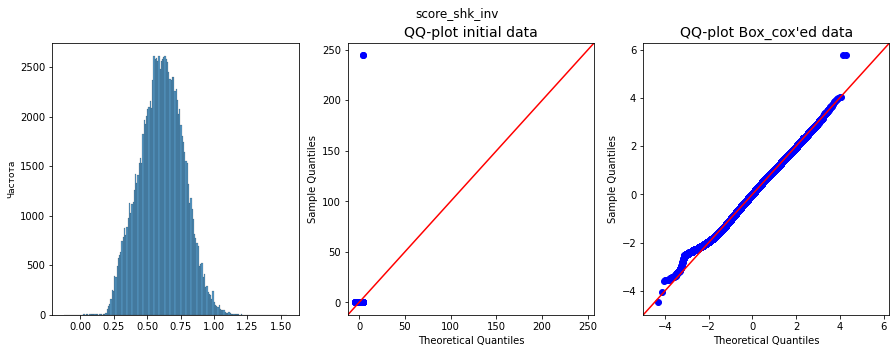

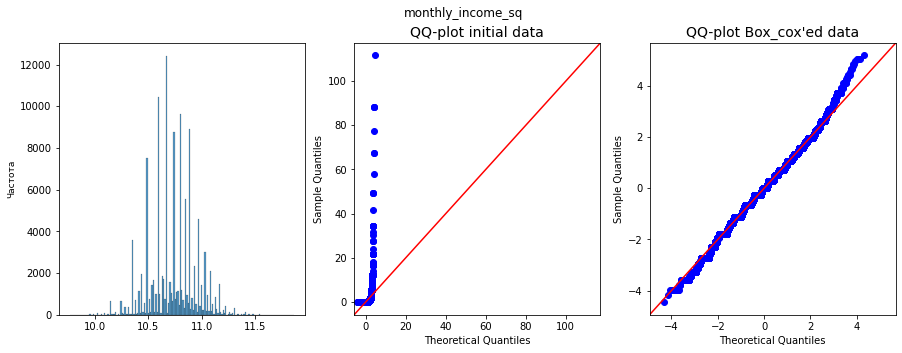

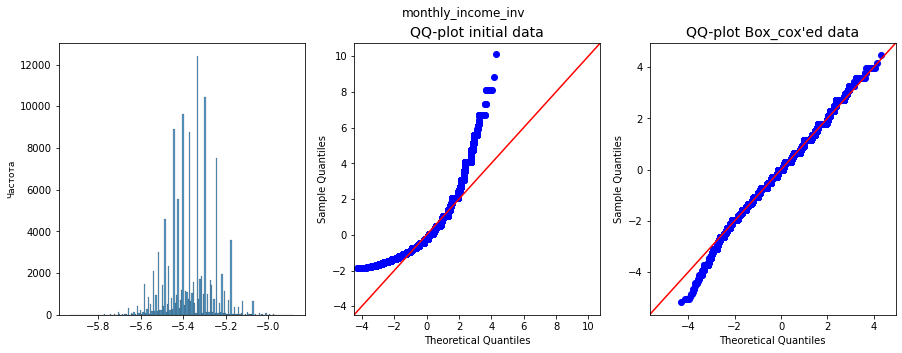

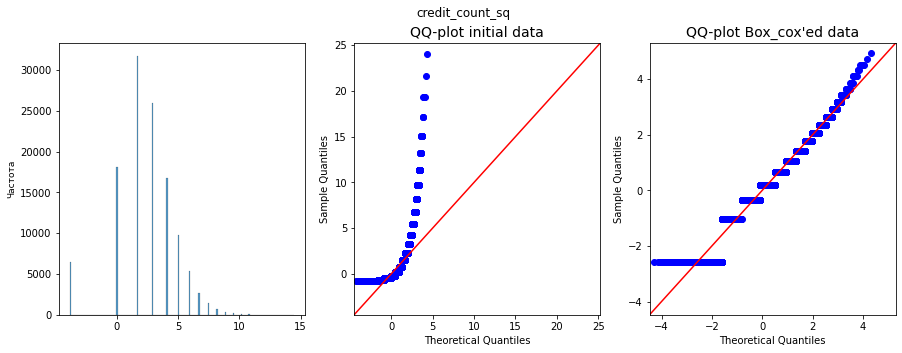

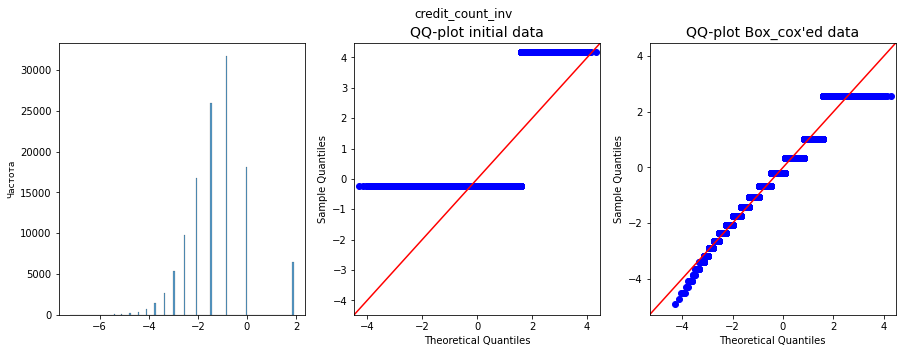

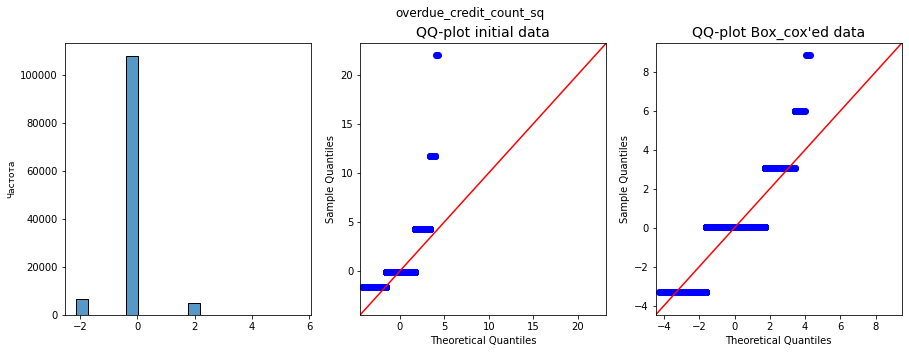

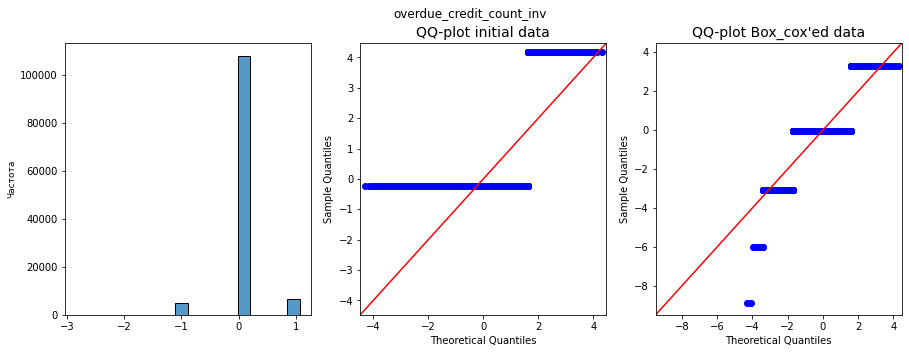

In [62]:
for col in quantitative_cols:
    transformed, lam = boxcox(train[col])
    print(f'Lambda for {col}: {lam:.3f}')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(transformed, ax=ax[0])
    qqplot(train[col], norm, fit=True, line='45', ax=ax[1])
    qqplot(transformed, norm, fit=True, line='45', ax=ax[2])

    ax[0].set_ylabel('Частота', fontsize=9)
    ax[1].set_title("QQ-plot initial data", fontsize=14)
    ax[2].set_title("QQ-plot Box_cox'ed data", fontsize=14)
    fig.suptitle(col)

In [63]:
boxcox_cols = ['age','credit_sum',
              'monthly_income', 'month_payment',
              'payment_income_part', 'age_sq',
              'age_inv', 'credit_sum_sq',
              'credit_sum_inv', 'credit_month_sq',
              'credit_month_inv', 'score_shk_sq',
              'score_shk_inv', 'monthly_income_sq',
              'monthly_income_inv', 'credit_count_inv',
              'overdue_credit_count_inv']

In [64]:
transformation_lambdas_wcols = {}
for col in tqdm(boxcox_cols):
    for ind, df in enumerate(datasets):
        df[col] = df[col] + 0.0001
        if ind == 0:
# Поскольку у нас тренировочный датасет первый в списке
            df[col], lam = boxcox(df[col])    
            transformation_lambdas_wcols[col] = lam
        else:
            df[col]= boxcox(df[col], transformation_lambdas_wcols[col])

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.21it/s]


In [65]:
cat_cols = train.dtypes[train.dtypes == 'object'].index

In [66]:
train_label = pd.get_dummies(train, columns=cat_cols, drop_first=True)
valid_label = pd.get_dummies(valid, columns=cat_cols, drop_first=True)
test_label = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Baseline-модель с новыми предикторами

In [67]:
X_train = train_label.drop('open_account_flg', axis=1)
y_train = train_label['open_account_flg']

X_valid = valid_label.drop('open_account_flg', axis=1)
y_valid = valid_label['open_account_flg']

X_test = test_label.drop('open_account_flg', axis=1)
y_test = test_label['open_account_flg']

Также необходимо стандартизовать данные (поскольку у нас не все предикторы имеют нормальное распределение, то лучше воспользоваться классом RobustScaler, который устойчив к выбросам).

In [68]:
scaler = RobustScaler()
scaler.fit(X_train)

X_tr_scaled_wcols = pd.DataFrame(scaler.transform(X_train.values),
                                 columns=X_train.columns,
                                 index=X_train.index)
X_val_scaled_wcols = pd.DataFrame(scaler.transform(X_valid.values),
                                  columns=X_valid.columns,
                                  index=X_valid.index)
X_test_scaled_wcols = pd.DataFrame(scaler.transform(X_test.values),
                                   columns=X_test.columns,
                                   index=X_test.index)

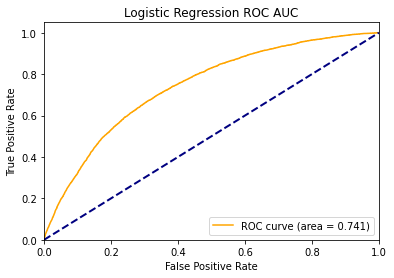

In [69]:
lr_baseline_wcols = make_log_reg(x_train=X_tr_scaled_wcols,
                                 y_train=y_train,
                                 x_valid=X_val_scaled_wcols,
                                 y_valid=y_valid,
                                 results_df=lr_metrics,
                                 model_name='lr_baseline_wcols')

In [70]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

Видим, что добавление новых предикторов позволило значительно увеличить качество модели. Логистическая регрессия хороша тем, что позволяет достаточно просто интерпретировать вклад каждой переменной на исход (таргетную переменную), однако, для этого необходимо устранить корреляцию между предикторами.

##  Попробуем модель, где отсутствует корреляция между переменными

Вследствие корреляции между предсказателями необходимо проявлять осторожность в интерпертации коэффициентов в множественной регрессии. Мультиколлинеарность может вызвать числовую нестабильность в подгонке уравнения регрессии. Таким образом, для корректной интерпертации коэффициентов регрессии нам необходимо избавиться от коррелированных переменных, что также сократит количество предикторов нашей модели - сделает ее проще, что есть хорошо, согласно бритве Оккама.

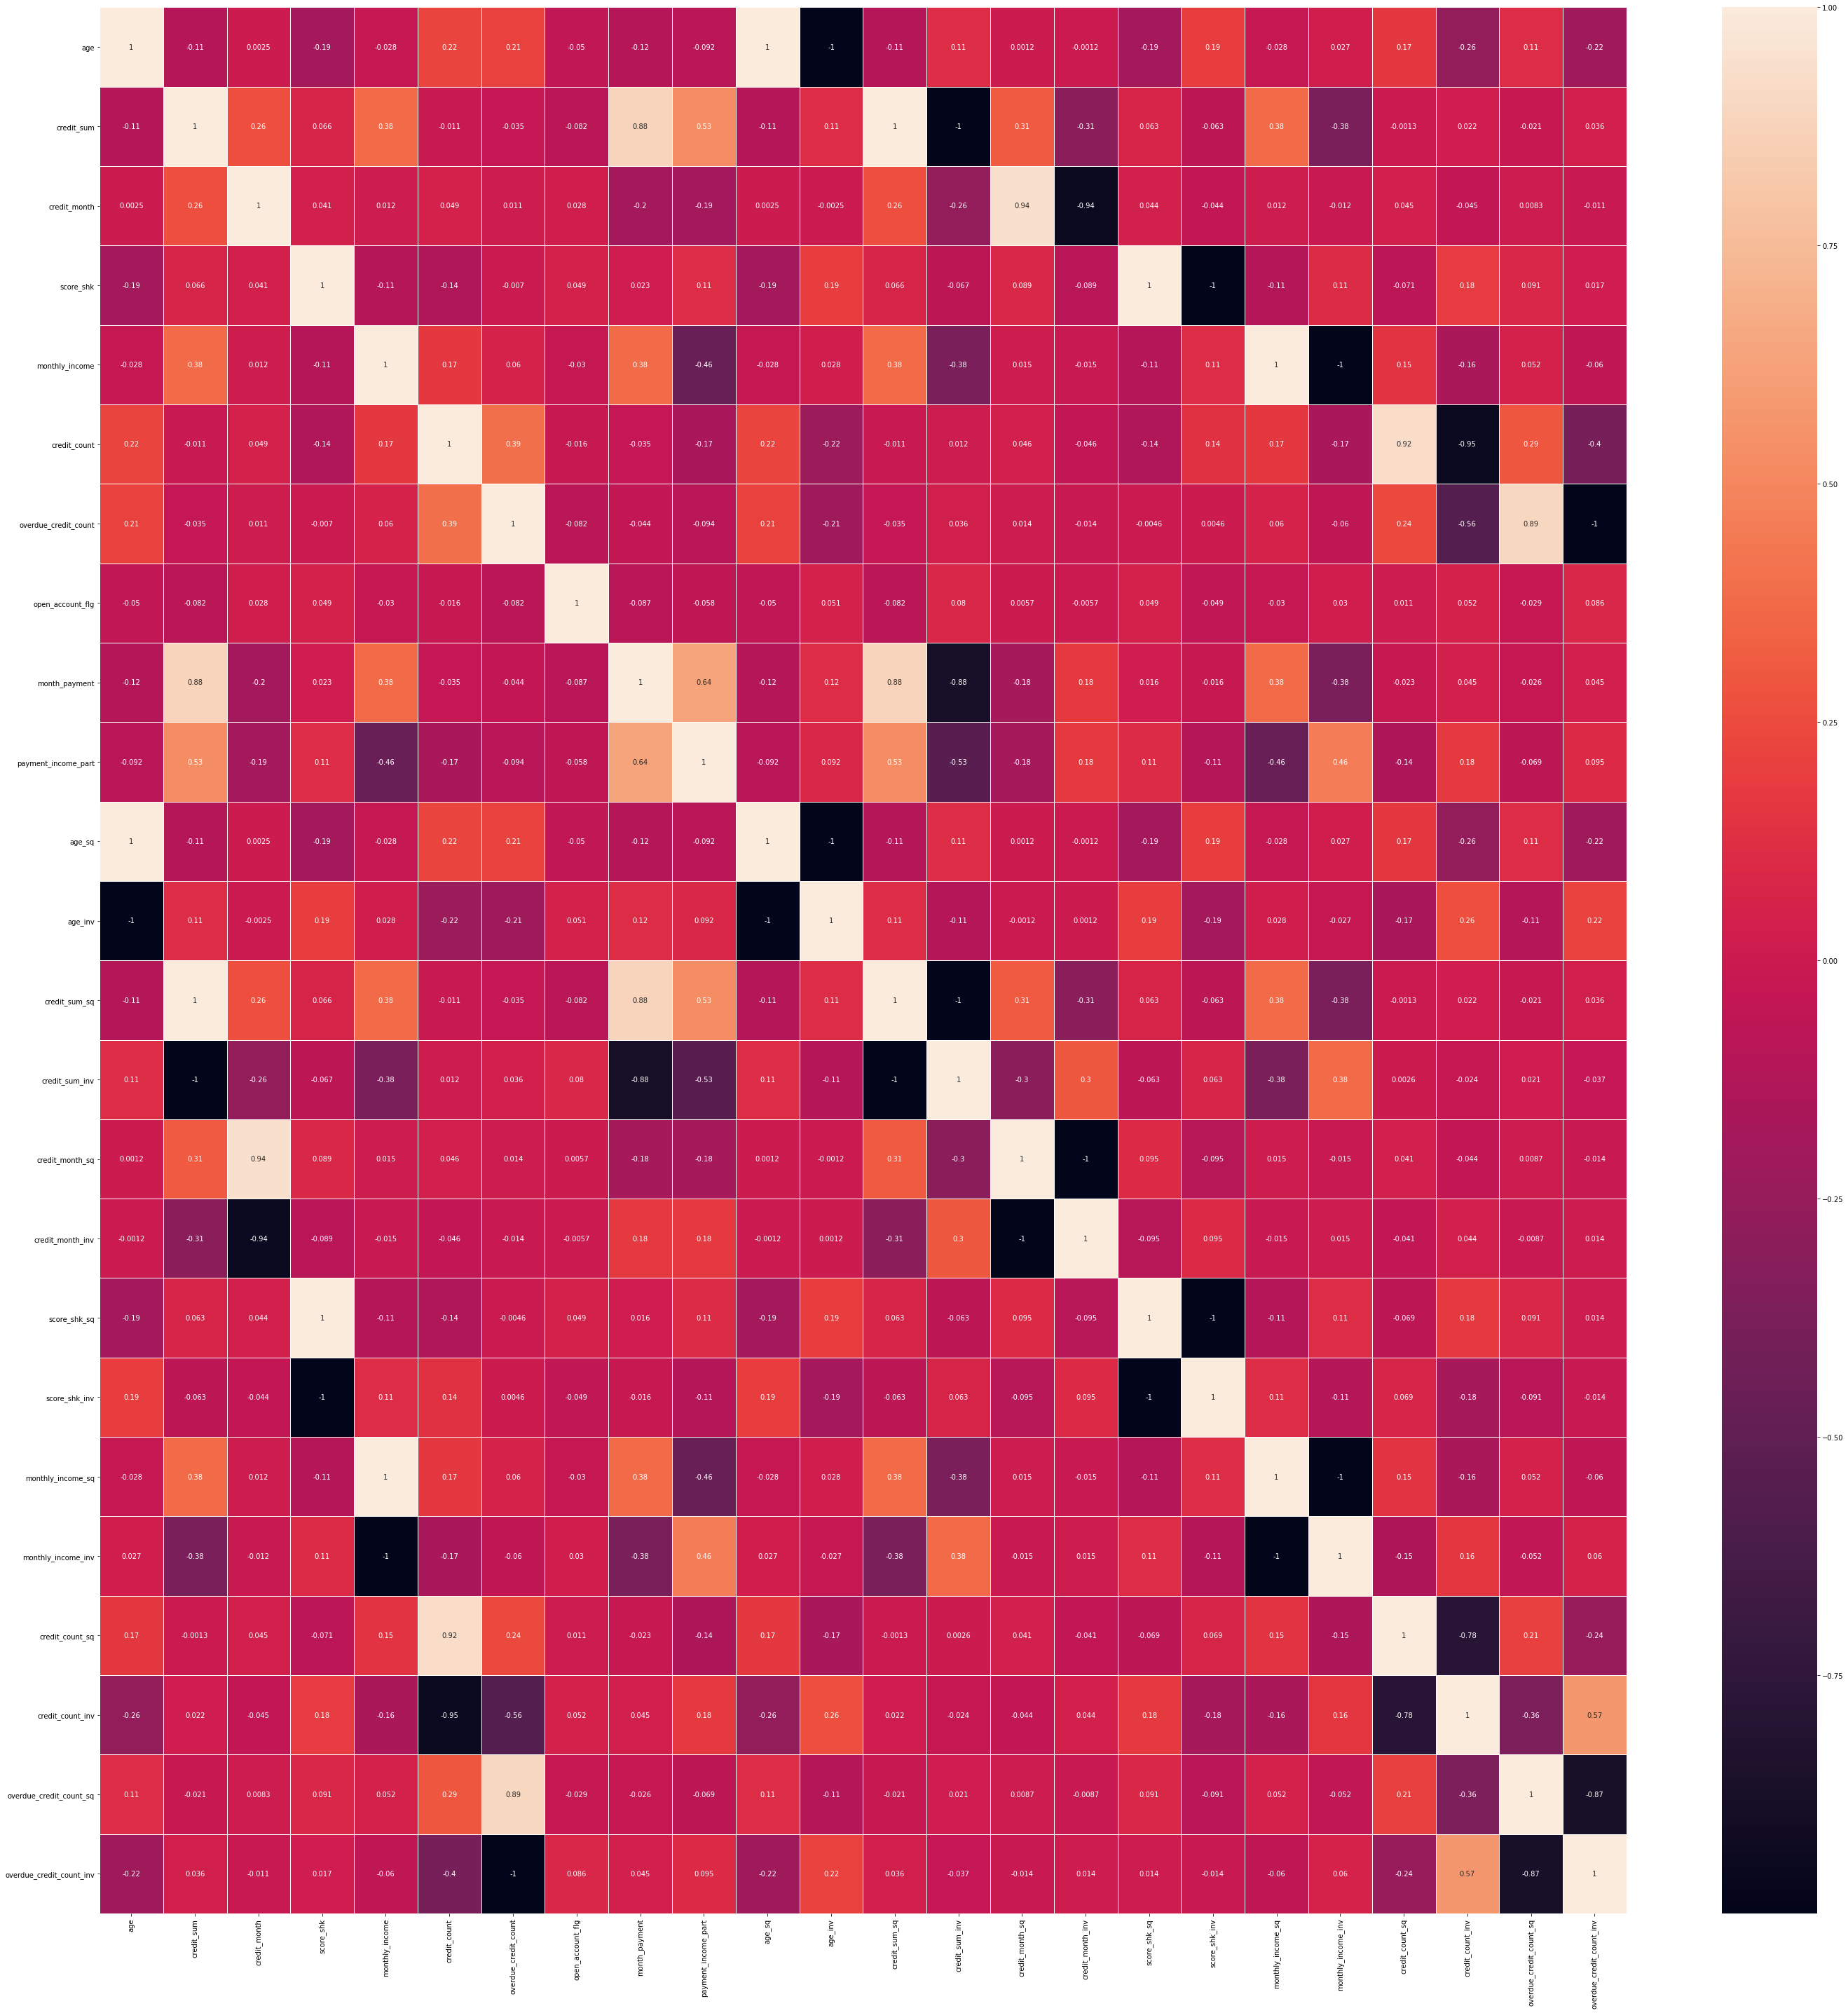

In [71]:
plt.figure(figsize=(40,40))
sns.heatmap(train.corr(method='pearson'), annot=True, linewidths=1)
plt.tight_layout()

Рассмотрим какие переменные имеют какое количество сильных корреляций.

In [72]:
corr_predictors = ((train.corr(method='pearson') > 0.7) |
                   (train.corr(method='pearson') < -0.7)).sum().sort_values(ascending=False)

In [73]:
corr_predictors

credit_sum_sq               4
credit_sum_inv              4
month_payment               4
credit_sum                  4
overdue_credit_count_sq     3
credit_count_inv            3
credit_count_sq             3
monthly_income_inv          3
monthly_income_sq           3
score_shk_inv               3
score_shk_sq                3
credit_month_inv            3
credit_month_sq             3
age                         3
age_inv                     3
age_sq                      3
overdue_credit_count        3
credit_count                3
monthly_income              3
score_shk                   3
credit_month                3
overdue_credit_count_inv    3
payment_income_part         1
open_account_flg            1
dtype: int64

In [74]:
cols_to_drop = corr_predictors[corr_predictors > 3].index
cols_to_drop

Index(['credit_sum_sq', 'credit_sum_inv', 'month_payment', 'credit_sum'], dtype='object')

In [75]:
train_ncorr = train.copy()
valid_ncorr = valid.copy()
test_ncorr = test.copy()    
dfs_ncorr = [train_ncorr, valid_ncorr, test_ncorr]

for df in dfs_ncorr:
    df.drop(cols_to_drop, axis=1, inplace=True)

In [76]:
cat_cols_ncorr = train_ncorr.dtypes[train_ncorr.dtypes == 'object'].index

In [77]:
train_label_ncorr = pd.get_dummies(train_ncorr, columns=cat_cols_ncorr, drop_first=True)
valid_label_ncorr = pd.get_dummies(valid_ncorr, columns=cat_cols_ncorr, drop_first=True)
test_label_ncorr = pd.get_dummies(test_ncorr, columns=cat_cols_ncorr, drop_first=True)

# Baseline-модель с новыми предикторами без корреляции

In [78]:
X_train_ncorr = train_label_ncorr.drop('open_account_flg', axis=1)
y_train_ncorr = train_label_ncorr['open_account_flg']

X_valid_ncorr = valid_label_ncorr.drop('open_account_flg', axis=1)
y_valid_ncorr = valid_label_ncorr['open_account_flg']

X_test_ncorr = test_label_ncorr.drop('open_account_flg', axis=1)
y_test_ncorr = test_label_ncorr['open_account_flg']

Также необходимо стандартизовать данные (поскольку у нас не все предикторы имеют нормальное распределение, то лучше воспользоваться классом RobustScaler, который устойчив к выбросам).

In [79]:
scaler = RobustScaler()
scaler.fit(X_train_ncorr)

X_tr_scaled_ncorr = pd.DataFrame(scaler.transform(X_train_ncorr.values),
                                 columns=X_train_ncorr.columns,
                                 index=X_train_ncorr.index)
X_val_scaled_ncorr = pd.DataFrame(scaler.transform(X_valid_ncorr.values),
                                  columns=X_valid_ncorr.columns,
                                  index=X_valid_ncorr.index)
X_test_scaled_ncorr = pd.DataFrame(scaler.transform(X_test_ncorr.values),
                                   columns=X_test_ncorr.columns,
                                   index=X_test_ncorr.index)

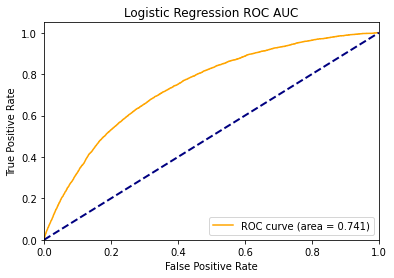

In [80]:
lr_wcols_nocorr = make_log_reg(x_train=X_tr_scaled_ncorr,
                                 y_train=y_train_ncorr,
                                 x_valid=X_val_scaled_ncorr,
                                 y_valid=y_valid_ncorr,
                                 results_df=lr_metrics,
                                 model_name='lr_wcols_nocorr')

In [81]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

С увеличением числа предикторов, качество модели улучшилось, однако, недообучение модели может вносить свою лепту, поскольку число итераций осталось прежним. Можно проверить зависимость ROC AUC от числа итераций.

In [82]:
iter_num_results = pd.DataFrame(columns=['roc_auc', 'precision_score',
                                         'recall_score', 'f1_score', 'log_loss'])

iter_num_results_funcs = [precision_score, recall_score, f1_score, log_loss]

In [83]:
for iter_num in tqdm(np.linspace(100, 3000, 30)):
    lr_baseline_wcols = LogisticRegression(class_weight = 'balanced',
                                           max_iter=iter_num,
                                           random_state=RND_STATE)
    lr_baseline_wcols.fit(X_tr_scaled, y_train)

    y_pred = lr_baseline_wcols.predict(X_val_scaled)
    y_score = lr_baseline_wcols.predict_proba(X_val_scaled)[:,1]
    
    iter_num_results.at[iter_num, 'roc_auc'] = roc_auc_score(y_valid, y_score)
    
    for i, col in enumerate(iter_num_results.columns[1:]):
        iter_num_results.at[iter_num, col] = iter_num_results_funcs[i](y_valid, y_pred)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  3%|██▊                                                                                | 1/30 [00:02<01:20,  2.79s/it]lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  7%|█████▌ 

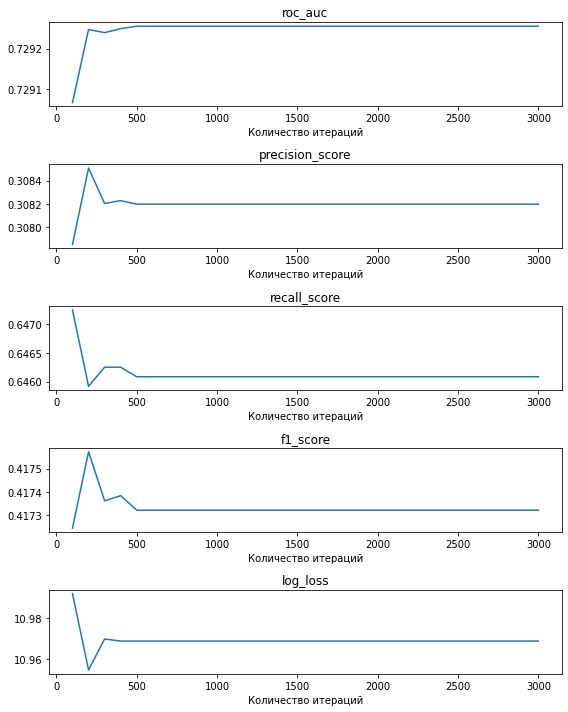

In [84]:
fig, ax = plt.subplots(5,1, figsize=(8,10))
for i, col in enumerate(iter_num_results.columns):
    iter_num_results[col].plot(ax=ax[i])
    ax[i].set_title(col)
    ax[i].set(xlabel='Количество итераций')

fig.tight_layout()

Видно, что при количестве итераций превышающих 1000 улучшение площади под кривой ROC не происходит, следовательно, использование большего количества итераций бессмысленно.

Таким образом, на основании выбранных показателей эффективности, можно заключить, что наилучшая модель - модель, с множеством дополнительных предикторов но без коррелированных переменных. Оптимизируем ее поиском гиперпараметров по сетке.

In [85]:
!telegram-send "grid_cv_wcols_ncorr optimization started!"

In [86]:
%%time
grid_cv_wcols_ncorr = find_optimal_params(x_train=X_tr_scaled_ncorr,
                                          y_train=y_train_ncorr,
                                          parameters_grid=parameters_grid)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


One or more of the test scores are non-finite: [       nan 0.74411493        nan ...        nan        nan        nan]
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Наилучший ROC AUC = 0.7474
Наилучшие параметры: {'C': 1000.0, 'l1_ratio': 0.2, 'max_iter': 400, 'penalty': 'l2', 'solver': 'liblinear'}
Wall time: 1d 11h 32min 50s


In [87]:
!telegram-send "grid_cv_wcols_ncorr optimization is over!"

In [88]:
best_params_wcols_ncorr = grid_cv_wcols_ncorr.best_params_

In [89]:
# best_params_wcols_ncorr = {'C': 1000.0,
#                            'max_iter': 400,
#                            'penalty': 'l2',
#                            'solver': 'liblinear'}

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


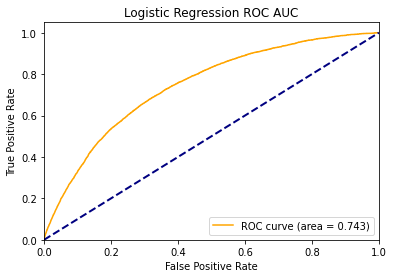

In [90]:
grid_LR_ncorr = make_log_reg(x_train=X_tr_scaled_ncorr,
                                 y_train=y_train_ncorr,
                                 x_valid=X_val_scaled_ncorr,
                                 y_valid=y_valid_ncorr,
                                 results_df=lr_metrics,
                                 parameters=best_params_wcols_ncorr,
                                 model_name='Grid_LR_ncorr')

In [91]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

Таким образом, удаление скоррелированных признаков с дальнейшей оптимизацией гиперпараметров позволили увеличить площадь под кривой ROC с 0.740 до 0.743. 

Далее проведем анализ важности признаков, чтобы отсеять неважные переменные не обладающие предсказательной силой.

# Анализ важности признаков

Важность признаков можно анализировать различными способами, например, в данном проекте будут использованы значения Шепли рассчитанные с использованием библиотеки [shap](https://shap.readthedocs.io/en/latest/api.html), Permutation Importance – это метод оценки важности переменной для предсказательной способности модели. Суть данного подхода заключается в произвольной перестановке или перетасовке одного столбца в наборе датасета (валидации или теста), оставив все остальные столбцы нетронутыми. Признак считается «важным», если точность модели падает и его изменение вызывает увеличение ошибок. С другой стороны, признак считается «неважным», если перетасовка его значений не влияет на точность модели. Для оценки Permutation Importance будут использованы feature_importance_permutation из библиотеки [mlxtend](https://rasbt.github.io/mlxtend/user_guide/evaluate/feature_importance_permutation/) и [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

Для более детального исследования корреляции данных будем использовать [коэффициент инфляции дисперсии](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) В статистике коэффициент инфляции дисперсии (VIF) - это отношение дисперсии оценки некоторой переменной в модели к дисперсии модели, построенной с использованием только одного члена. Он предоставляет индекс, который измеряет, насколько увеличилась дисперсия (квадрат стандартного отклонения оценки) оценочного коэффициента регрессии из-за коллинеарности.

Наличие сильной корреляционной взаимосвязи между предикторами (на уровне 0,7 и выше) называется мультиколлинеарностью.
Мультиколлинеарность в модели проявляется в следующем:
- сильный разброс оценок коэффициентов регрессии;
- большие положительные и большие отрицательные оценки коэффициентов регрессии, выше 1,0 по модулю.
- резкое изменение оценок коэффициентов регрессии при добавлении или удалении предиктора;
- неправильный знак перед коэффициентом регрессии (например, объем продаж по уравнению регрессии увеличивается при увеличении цены);
- присутствие в модели большого количества статистически незначимых оценок коэффициентов регрессии.

Для устранения мультиколлинеарности можно увеличить размер выборки (не всегда реально), выполнить анализ главных компонент или снизить разброс оценок коэффициентов регрессии с помощью методов регуляризации (упорядочения) регрессии.
Методы регуляризации сокращают вариабельность оценок коэффициентов регрессии путем сжимания оценок до близких к нулю
значений.

In [92]:
x_temp = add_constant(X_tr_scaled_ncorr) #добавляем константу
vif = pd.DataFrame()
vif["features"] = x_temp.columns
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.shape[1])]

# Значение признака не должно превышать 10, если этого нет, следовательно, признак коррелирован с другим.

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
divide by zero encountered in double_scalars


In [93]:
vif[vif["VIF Factor"] > 10].features.values

array(['const', 'age', 'credit_month', 'score_shk', 'monthly_income',
       'credit_count', 'overdue_credit_count', 'age_sq', 'age_inv',
       'credit_month_sq', 'credit_month_inv', 'score_shk_sq',
       'score_shk_inv', 'monthly_income_sq', 'monthly_income_inv',
       'credit_count_sq', 'credit_count_inv', 'overdue_credit_count_sq',
       'overdue_credit_count_inv', 'marital_status_MAR',
       'marital_status_UNM', 'job_position_SPC', 'tariff_id_1_1',
       'tariff_id_1_6', 'education_GRD', 'education_SCH', 'education_UGR',
       'living_region_АРХАНГЕЛЬСКАЯ', 'living_region_АСТРАХАНСКАЯ',
       'living_region_БАШКОРТОСТАН', 'living_region_БУРЯТИЯ',
       'living_region_ВЛАДИМИРСКАЯ', 'living_region_ВОЛГОГРАДСКАЯ',
       'living_region_ВОЛОГОДСКАЯ', 'living_region_ВОРОНЕЖСКАЯ',
       'living_region_ЗАБАЙКАЛЬСКИЙ', 'living_region_ИВАНОВСКАЯ',
       'living_region_ИРКУТСКАЯ', 'living_region_КАЛУЖСКАЯ',
       'living_region_КЕМЕРОВСКАЯ', 'living_region_КОМИ',
       'living

На основании полученных результатов можно заключить, что у нас все еще имеются коррелированные столбцы, помимо полученных при кодировании категориальных переменных.

Посмотрим на перутированные важности предикторов с помощью функции feature_importance_permutation библиотеки mlxtend.

In [94]:
from mlxtend.evaluate import feature_importance_permutation
 
imp_vals, _ = feature_importance_permutation(
                predict_method=grid_LR_ncorr.predict,
                X = X_tr_scaled_ncorr.values,
                y = y_train_ncorr.values,
                metric='accuracy',
                num_rounds=50,
                seed=RND_STATE)

In [95]:
!telegram-send "feature_importance_permutation ready!"

In [96]:
feat_imp = pd.DataFrame(index=X_tr_scaled_ncorr.columns,
                        data=imp_vals, columns=['Feature importance'])

<AxesSubplot:>

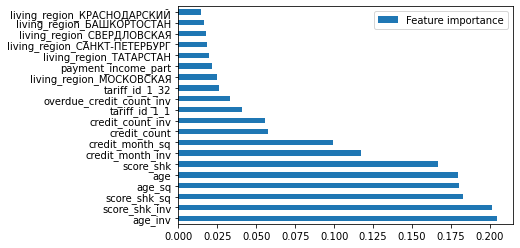

In [97]:
feat_imp.sort_values('Feature importance', ascending=False)[:20].plot(kind='barh')

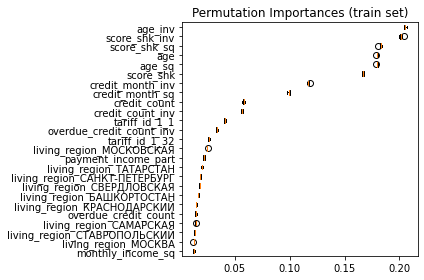

In [98]:
perm_imp_train = permutation_importance(grid_LR_ncorr,
                                        X_tr_scaled_ncorr,
                                        y_train_ncorr,
                                        n_repeats=10,
                                        random_state=RND_STATE)

sorted_idx = perm_imp_train.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_train.importances[sorted_idx][-25:].T, vert=False,
    labels=X_tr_scaled_ncorr.columns[sorted_idx][-25:]
)

ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

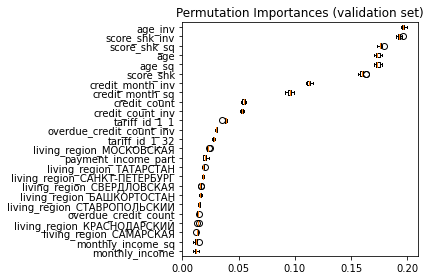

In [99]:
perm_imp_test = permutation_importance(grid_LR_ncorr,
                                       X_val_scaled_ncorr,
                                       y_valid_ncorr,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_val_scaled_ncorr.columns[sorted_idx][-25:]
)

ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

In [100]:
!telegram-send "permutation_importance ready!"

Ввиду мультиколлинеарности мы не можем достоверно определить важность каждого предиктора в модели. Нам необходимо провести очистку переменных от их коррелированных собратьев. Можно попробовать построить дендрограмму коррелированных переменных и выбрать из полученного кластера один предиктор.

In [101]:
quant_cols = ['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income',
              'credit_count', 'overdue_credit_count','month_payment',
              'payment_income_part', 'age_sq', 'age_inv',
              'credit_sum_sq', 'credit_sum_inv', 'credit_month_sq',
              'credit_month_inv', 'score_shk_sq', 'score_shk_inv',
              'monthly_income_sq', 'monthly_income_inv', 'credit_count_sq',
              'credit_count_inv', 'overdue_credit_count_sq',
              'overdue_credit_count_inv']

In [102]:
def find_corr_features(df, quant_cols):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    corr = spearmanr(df[quant_cols]).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = ward(squareform(distance_matrix))
    dendro = dendrogram(dist_linkage,
                        labels=df[quant_cols].columns.tolist(),
                        ax=ax1, leaf_rotation=90)

    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax2.set_yticklabels(dendro["ivl"])
    fig.tight_layout()
    plt.show()
    
    predictors_clusters = pd.DataFrame(index=dendro["ivl"])
    cluster_ids = fcluster(dist_linkage, 0, criterion="distance")
    predictors_clusters['Clusters'] = cluster_ids
    
    return predictors_clusters.sort_values('Clusters')

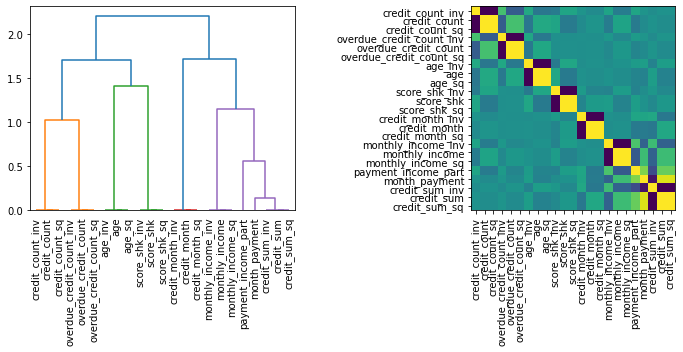

Clusters
credit_sum_inv                   1
month_payment                    1
overdue_credit_count_sq          1
credit_sum_sq                    2
credit_sum                       2
age_inv                          2
score_shk                        3
score_shk_inv                    3
credit_count_inv                 3
overdue_credit_count_inv         4
monthly_income_inv               4
monthly_income                   4
credit_month                     5
credit_month_sq                  5
credit_count_sq                  5
overdue_credit_count             6
monthly_income_sq                6
payment_income_part              6
credit_month_inv                 7
credit_count                     7
score_shk_sq                     7
age                              8
age_sq                           9

In [103]:
find_corr_features(X_tr_scaled_wcols, quant_cols)

Можно выбирать предикторы автоматически, однако, более целесообразно отбирать те,
которые не были созданы нами самостоятельно, чтобы в дальнейшем сделать pipeline 
попроще.

In [104]:
selected_features = [
    'month_payment', 'credit_sum', 'monthly_income',
    'age', 'credit_month', 'overdue_credit_count',
    'credit_count', 'score_shk', 'score_shk_sq'
]

In [105]:
cols_to_drop_dend = list(set(quant_cols) - set(selected_features))

In [106]:
cols_to_drop_dend 

['monthly_income_sq',
 'credit_sum_sq',
 'payment_income_part',
 'overdue_credit_count_inv',
 'credit_month_sq',
 'credit_month_inv',
 'age_sq',
 'credit_count_sq',
 'credit_sum_inv',
 'age_inv',
 'overdue_credit_count_sq',
 'score_shk_inv',
 'credit_count_inv',
 'monthly_income_inv']

In [107]:
X_tr_scaled_wcols_denddrop = X_tr_scaled_wcols.drop(cols_to_drop_dend, axis=1)
X_val_scaled_wcols_denddrop = X_val_scaled_wcols.drop(cols_to_drop_dend, axis=1)
X_test_scaled_wcols_denddrop = X_test_scaled_wcols.drop(cols_to_drop_dend, axis=1)

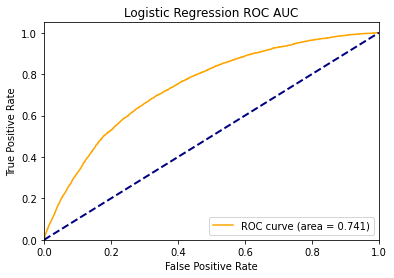

In [108]:
lr_denddrop = make_log_reg(x_train=X_tr_scaled_wcols_denddrop,
                                 y_train=y_train_ncorr,
                                 x_valid=X_val_scaled_wcols_denddrop,
                                 y_valid=y_valid_ncorr,
                                 results_df=lr_metrics,
                                 model_name='lr_denddrop')

In [109]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

Проверим важность признаков после удаления коррелированных столбцов.

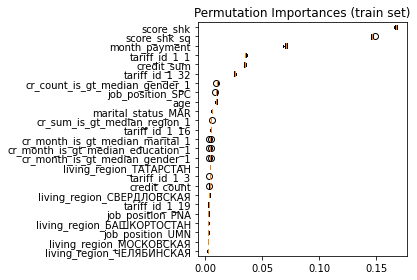

In [110]:
perm_imp_train = permutation_importance(lr_denddrop,
                                        X_tr_scaled_wcols_denddrop,
                                        y_train,
                                        n_repeats=10,
                                        random_state=RND_STATE)

sorted_idx = perm_imp_train.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_train.importances[sorted_idx][-25:].T, vert=False,
    labels=X_tr_scaled_wcols_denddrop.columns[sorted_idx][-25:]
)

ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

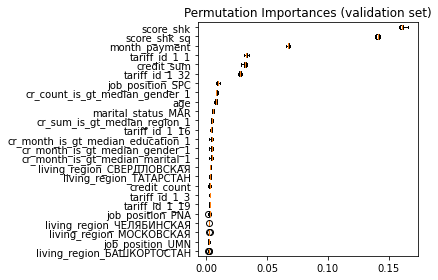

In [111]:
perm_imp_test = permutation_importance(lr_denddrop,
                                       X_val_scaled_wcols_denddrop,
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_val_scaled_wcols_denddrop.columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

Видим, что важность параметров модели изменилась, посмотрим на значения Шепли для них.

In [112]:
explainer = shap.LinearExplainer(lr_denddrop,
                                 X_tr_scaled_wcols_denddrop,
                                 feature_perturbation="interventional")

shap_values = explainer(X_val_scaled_wcols_denddrop)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


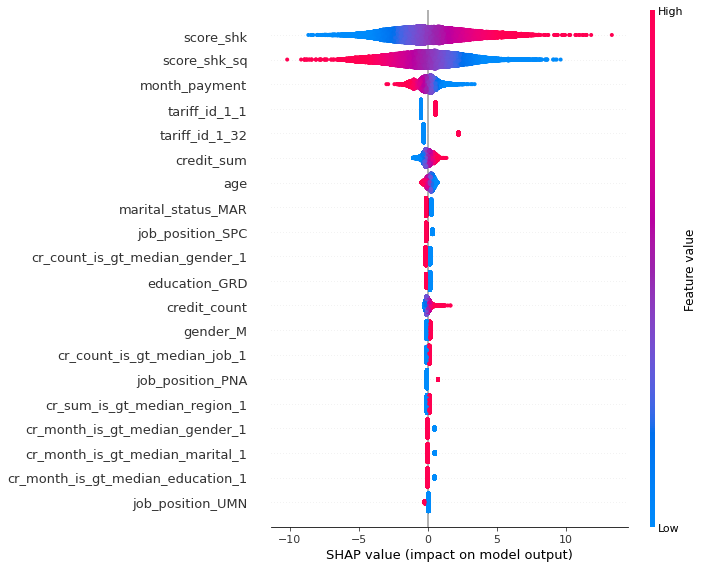

In [113]:
shap.summary_plot(shap_values, X_val_scaled_wcols_denddrop)

In [114]:
# explainer = shap.LinearExplainer(tuned_lr_gr_wcols_denddrop,
#                                  X_tr_scaled_wcols_denddrop,
#                                  feature_perturbation="correlation_dependent")
# shap_values = explainer(X_val_scaled_wcols_denddrop)

In [115]:
# shap.summary_plot(shap_values, X_val_scaled_wcols_denddrop)

Можно заметить, что на данном этапе наибольшую предиктивную способность носят тарифы 1-32, 1-1; людям, которым были предложены данные тарифы, имели большую конверсию. Также внутренняя скоринговая оценка вносит наибольшую разрешающую способность, люди с высокой оценкой более склонны открывать счет в банке Тинькофф. Высокий ежемесячный платеж, напротив, отпугивает клиентов.

Далее обучим модель с большей силой регуляризации, что позволит обнулить некоторые коэффициенты регрессии и, соответственно, откинуть те, которые вносят только шум.

In [116]:
parameters_grid_C_lt1 = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.2, 0.4, 0.6, 0.8, 1.],
    'solver': ['sag', 'liblinear', 'lbfgs'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(500, 1200, 100)
}

In [117]:
!telegram-send "_C_lt1 grid optimization started!"

In [118]:
%%time
grid_cv_wcols_C_lt1 = find_optimal_params(x_train=X_tr_scaled_wcols_denddrop,
                                          y_train=y_train,
                                          parameters_grid=parameters_grid_C_lt1)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


One or more of the test scores are non-finite: [       nan 0.74478201        nan ...        nan        nan        nan]
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Наилучший ROC AUC = 0.7449
Наилучшие параметры: {'C': 1.0, 'l1_ratio': 0.2, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Wall time: 4h 3min 47s


In [119]:
!telegram-send "_C_lt1 grid optimization is over!"

In [120]:
best_params_wcols_C_lt1 = grid_cv_wcols_C_lt1.best_params_

In [121]:
# best_params_wcols_C_lt1 = {
#     'C': 1.0,
#     'max_iter': 500,
#     'penalty': 'l2',
#     'solver': 'liblinear'
# }

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


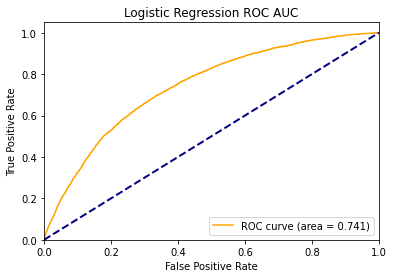

In [122]:
tuned_lr_gr_wcols_C_lt1 = make_log_reg(x_train=X_tr_scaled_wcols_denddrop,
                                       y_train=y_train,
                                       x_valid=X_val_scaled_wcols_denddrop,
                                       y_valid=y_valid,
                                       results_df=lr_metrics,
                                       parameters=best_params_wcols_C_lt1,
                                       model_name='lr_tuned_denddrop_C_lt1')

In [123]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

### Отсев переменных не обладающих предсказательной способностью

Далее мы проведем отсев сконструированных переменных на основании значения их коэффициентов в уравнении регресии.

In [124]:
tuned_lr_gr_wcols_C_lt1_coef = pd.DataFrame(
    index=['intercept'] + X_tr_scaled_wcols_denddrop.columns.to_list(),
    data=[tuned_lr_gr_wcols_C_lt1.intercept_[0]] + tuned_lr_gr_wcols_C_lt1.coef_[0].tolist(),
    columns=['coef']).sort_values('coef', ascending=False)

In [125]:
indices_to_drop = tuned_lr_gr_wcols_C_lt1_coef.query('-0.1 < coef < 0.1').index
indices_to_drop = indices_to_drop[indices_to_drop.str.contains('_is_gt_')]

In [126]:
def filter_coefs(X_train, X_valid, coef_df, results_df, threshold, model_params):
    indices_to_drop = coef_df.iloc[:,[-1]].query('-@threshold < coef < @threshold').index
    indices_to_drop = indices_to_drop[indices_to_drop.str.contains('_is_gt_')]
    step = 0
    
    while indices_to_drop.shape[0] != 0:
        X_train = X_train.drop(indices_to_drop, axis=1)
        X_valid = X_valid.drop(indices_to_drop, axis=1)
        print(f'Шаг номер: {step}')
        print(f'Были выброшены: {indices_to_drop}')
        print('-' * 25)
        
        log_reg = make_log_reg(x_train=X_train,
                               y_train=y_train,
                               x_valid=X_valid,
                               y_valid=y_valid,
                               results_df=results_df,
                               parameters=model_params,
                               model_name='filter_coefs_' + str(step))
        
        coefs = pd.DataFrame(
            index=['intercept'] + X_valid.columns.to_list(),
            data=[log_reg.intercept_[0]] + log_reg.coef_[0].tolist(),
            columns=['coef_step_' + str(step)])
        
        coef_df = coef_df.merge(coefs, how='left', left_index=True, right_index=True)
        
        query_str = f'-@threshold < coef_step_{step} < @threshold'
        indices_to_drop = coef_df.query(query_str).index
        indices_to_drop = indices_to_drop[indices_to_drop.str.contains('_is_gt_')]
        step += 1
        
    return coef_df

Для максимального обнуления коэффициентов регрессии можно применить лассо регрессию - L1. Полученные малые значения коэффициентов будут основанием для удаления переменной из модели.

Шаг номер: 0
Были выброшены: Index(['age_is_gt_median_education_1', 'cr_sum_is_gt_median_education_1',
       'score_is_gt_median_job_1', 'age_is_gt_median_marital_1',
       'score_is_gt_median_marital_1', 'cr_month_is_gt_median_region_1',
       'cr_sum_is_gt_median_gender_1', 'age_is_gt_median_region_1',
       'score_is_gt_median_education_1', 'cr_count_is_gt_median_marital_1',
       'income_is_gt_median_job_1', 'cr_count_is_gt_median_education_1',
       'age_is_gt_median_gender_1', 'cr_sum_is_gt_median_job_1',
       'score_is_gt_median_region_1', 'income_is_gt_median_marital_1',
       'income_is_gt_median_gender_1', 'cr_count_is_gt_median_region_1',
       'income_is_gt_median_education_1', 'cr_sum_is_gt_median_marital_1',
       'income_is_gt_median_region_1', 'age_is_gt_median_job_1',
       'cr_month_is_gt_median_job_1', 'score_is_gt_median_gender_1'],
      dtype='object')
-------------------------


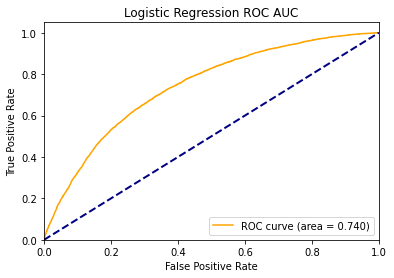

Шаг номер: 1
Были выброшены: Index(['overdue_count_is_gt_median_education_1',
       'overdue_count_is_gt_median_region_1',
       'overdue_count_is_gt_median_gender_1',
       'overdue_count_is_gt_median_marital_1',
       'overdue_count_is_gt_median_job_1'],
      dtype='object')
-------------------------


In [127]:
params = {
    'penalty':'l1',
    'C':0.2,
    'solver':'liblinear',
    'max_iter':1500
}

coef_df = filter_coefs(X_tr_scaled_wcols_denddrop,
             X_val_scaled_wcols_denddrop,
             tuned_lr_gr_wcols_C_lt1_coef,
             lr_metrics, 0.1, params)

lr_metrics.style.highlight_max(axis=1, color='lightblue')

Таким образом, на основании близости к нулю коэффициентов при переменных будут выброшены вышеуказанные предикторы.

In [128]:
cols_to_drop = coef_df.loc[coef_df.iloc[:,[-1]].isna()['coef_step_1'].values,:].index
cols_to_drop

Index(['age_is_gt_median_education_1', 'cr_sum_is_gt_median_education_1',
       'score_is_gt_median_job_1', 'age_is_gt_median_marital_1',
       'score_is_gt_median_marital_1', 'cr_month_is_gt_median_region_1',
       'cr_sum_is_gt_median_gender_1', 'age_is_gt_median_region_1',
       'score_is_gt_median_education_1', 'cr_count_is_gt_median_marital_1',
       'income_is_gt_median_job_1', 'cr_count_is_gt_median_education_1',
       'age_is_gt_median_gender_1', 'cr_sum_is_gt_median_job_1',
       'score_is_gt_median_region_1', 'income_is_gt_median_marital_1',
       'income_is_gt_median_gender_1', 'cr_count_is_gt_median_region_1',
       'income_is_gt_median_education_1', 'cr_sum_is_gt_median_marital_1',
       'income_is_gt_median_region_1', 'age_is_gt_median_job_1',
       'cr_month_is_gt_median_job_1', 'score_is_gt_median_gender_1',
       'overdue_count_is_gt_median_education_1',
       'overdue_count_is_gt_median_region_1',
       'overdue_count_is_gt_median_gender_1',
       'over

Видим, что теперь у нас нет сконструированных признаков с низким коэффициентом. Следовательно мы убрали лишние переменные.

Также можно проверить как изменится предсказательная сила переменной при удалении `score_shk_sq`.

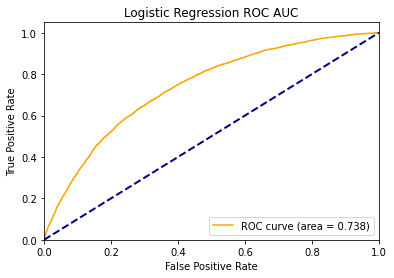

In [129]:
cols_to_drop_1 = cols_to_drop.append(pd.Index(['score_shk_sq']))
lr_drop_shk_sq = make_log_reg(x_train=X_tr_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                              y_train=y_train,
                              x_valid=X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                              y_valid=y_valid,
                              results_df=lr_metrics,
                              parameters=params,
                              model_name='lr_drop_shk_sq')

In [130]:
lr_metrics.style.highlight_max(axis=1, color='lightblue')

In [131]:
explainer = shap.LinearExplainer(lr_drop_shk_sq,
                                 X_tr_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                                 feature_perturbation="interventional")
shap_values = explainer(X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1))

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


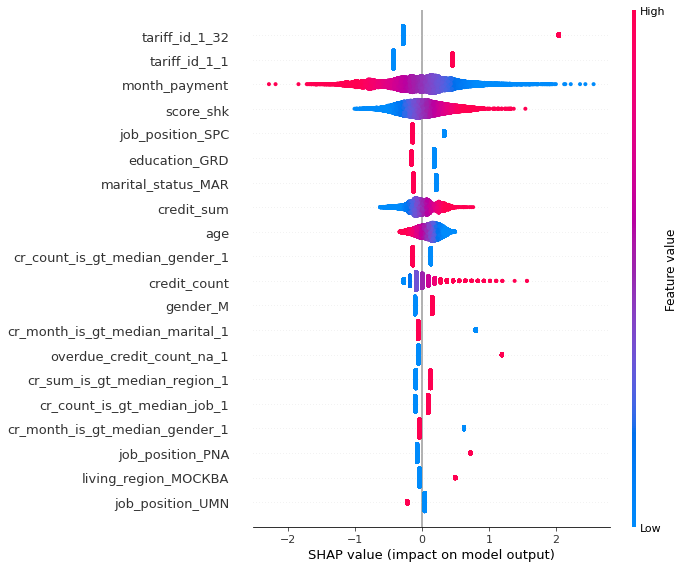

In [132]:
shap.summary_plot(shap_values, X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1))

Согласно полученным результатам, можно заключить, что удаление столбца `score_shk_sq` приводит ко значительному ухудшению предсказательной способности модели. Значения Шепли при этом также уменьшаются в абсолютном значении в 3 раза.

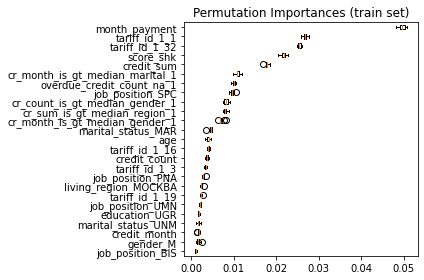

In [133]:
perm_imp_train = permutation_importance(lr_drop_shk_sq,
                                        X_tr_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                                        y_train,
                                        n_repeats=10,
                                        random_state=RND_STATE)

sorted_idx = perm_imp_train.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_train.importances[sorted_idx][-25:].T, vert=False,
    labels=X_tr_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1).columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

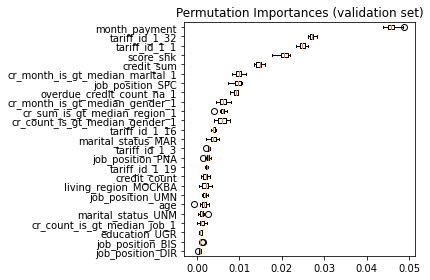

In [134]:
perm_imp_test = permutation_importance(lr_drop_shk_sq,
                                       X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1),
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_val_scaled_wcols_denddrop.drop(cols_to_drop_1, axis=1).columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

$logit(p) = log(\frac{p}{1-p}) = \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k.$

# Конструирование попарных взаимодействий

До этого момента в моделях не были заложены попарные взаимодействия между предикторами, также для улучшения предсказательной способности модели произведем биннинг некоторых количественных переменных. 

Для оценки качества и целесообразности биннинга переменных воспользуемся библиотекой [PyWoE](https://pypi.org/project/pywoe/).

In [4]:
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col = 0).copy()
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col = 0).copy()
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col = 0).copy()

In [5]:
X_train = train.drop('open_account_flg', axis=1)
y_train = train['open_account_flg']

X_valid = valid.drop('open_account_flg', axis=1)
y_valid = valid['open_account_flg']

X_test = test.drop('open_account_flg', axis=1)
y_test = test['open_account_flg']

In [6]:
X_train.dtypes

gender                   object
age                     float64
marital_status           object
job_position             object
credit_sum              float64
credit_month              int64
tariff_id                object
score_shk               float64
education                object
living_region            object
monthly_income          float64
credit_count            float64
overdue_credit_count    float64
month_payment           float64
payment_income_part     float64
dtype: object

In [7]:
qua_cols = X_train.dtypes[X_train.dtypes != 'object'].index

In [8]:
(X_train[qua_cols] == 0).sum()

age                          0
credit_sum                   0
credit_month                 0
score_shk                    2
monthly_income               0
credit_count             18062
overdue_credit_count    107933
month_payment                0
payment_income_part          0
dtype: int64

In [9]:
X_train[qua_cols] = X_train[qua_cols] - 0.001
(X_train[qua_cols] == 0).sum()

age                     0
credit_sum              0
credit_month            0
score_shk               0
monthly_income          0
credit_count            0
overdue_credit_count    0
month_payment           0
payment_income_part     0
dtype: int64

In [10]:
Xs_datasets = [X_train, X_valid, X_test]

In [11]:
for indicator in tqdm(qua_cols):
    for df in Xs_datasets:
        df[indicator + '_sq'] = df[indicator] ** 2
        df[indicator + '_inv'] = (1 / df[indicator]).replace([np.inf, -np.inf], -1)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.46it/s]


In [12]:
qua_cols = X_train.dtypes[X_train.dtypes != 'object'].index

In [13]:
X_train[qua_cols]

age  credit_sum  credit_month  score_shk  monthly_income  \
87470   29.999    4989.999         5.999   0.437890       23999.999   
77449   44.999   27346.999         9.999   0.667692       24999.999   
97073   41.999   11509.999        23.999   0.377687       29999.999   
6498    38.999   30312.999         9.999   0.495607       29999.999   
156564  25.999   46971.899         9.999   0.430449       69999.999   
...        ...         ...           ...        ...             ...   
83528   38.999   20976.999         9.999   0.403381       27999.999   
138673  64.999   25190.999         9.999   0.321701       13699.999   
141915  36.999   46277.999         9.999   0.613858       37499.999   
35227   25.999    5283.999         9.999   0.368292       34999.999   
125619  55.999   56257.999         9.999   0.692419       79999.999   

        credit_count  overdue_credit_count  month_payment  \
87470          2.999                 0.999     831.665667   
77449          2.999                -0.001    2734.699000   
97073          2.999                -0.001     479.582333   
6498           1.999                -0.001    3031.299000   
156564         0.999                -0.001    4697.189000   
...              ...                   ...            ...   
83528          0.999                -0.001    2097.699000   
138673        -0.001                -0.001    2519.099000   
141915         1.999                -0.001    4627.799000   
35227          3.999                -0.001     528.399000   
125619         5.999                 0.999    5625.799000   

        payment_income_part       age_sq  ...  monthly_income_sq  \
87470              0.033653   899.940001  ...       5.760000e+08   
77449              0.108388  2024.910001  ...       6.250000e+08   
97073              0.014986  1763.916001  ...       8.999999e+08   
6498               0.100043  1520.922001  ...       8.999999e+08   
156564             0.066103   675.948001  ...       4.900000e+09   
...                     ...          ...  ...                ...   
83528              0.073918  1520.922001  ...       7.839999e+08   
138673             0.182876  4224.870001  ...       1.876900e+08   
141915             0.122408  1368.926001  ...       1.406250e+09   
35227              0.014097   675.948001  ...       1.225000e+09   
125619             0.069322  3135.888001  ...       6.400000e+09   

        monthly_income_inv  credit_count_sq  credit_count_inv  \
87470             0.000042         8.994001          0.333444   
77449             0.000040         8.994001          0.333444   
97073             0.000033         8.994001          0.333444   
6498              0.000033         3.996001          0.500250   
156564            0.000014         0.998001          1.001001   
...                    ...              ...               ...   
83528             0.000036         0.998001          1.001001   
138673            0.000073         0.000001      -1000.000000   
141915            0.000027         3.996001          0.500250   
35227             0.000029        15.992001          0.250063   
125619            0.000013        35.988001          0.166694   

        overdue_credit_count_sq  overdue_credit_count_inv  month_payment_sq  \
87470                  0.998001                  1.001001      6.916678e+05   
77449                  0.000001              -1000.000000      7.478579e+06   
97073                  0.000001              -1000.000000      2.299992e+05   
6498                   0.000001              -1000.000000      9.188774e+06   
156564                 0.000001              -1000.000000      2.206358e+07   
...                         ...                       ...               ...   
83528                  0.000001              -1000.000000      4.400341e+06   
138673                 0.000001              -1000.000000      6.345860e+06   
141915                 0.000001              -1000.000000      2.141652e+07   
35227                  0.000001      

Далее проведем степенное преобразование [Йео-Джонсона](https://en.wikipedia.org/wiki/Power_transform), которое также допускает нулевые и отрицательные значения. Закон преобразования гласит:


<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/2a99e24c81226f3d0547c471281197ea265553c5">

In [14]:
rs = RobustScaler(with_scaling=True,
                  unit_variance=True)

rs.fit(X_train[qua_cols])

for df in Xs_datasets:
    df[qua_cols] = rs.transform(df[qua_cols])

In [15]:
pt = PowerTransformer(standardize=True,
                      method='yeo-johnson')

pt.fit(X_train[qua_cols])

for df in Xs_datasets:
    df[qua_cols] = pt.transform(df[qua_cols])

<AxesSubplot:>

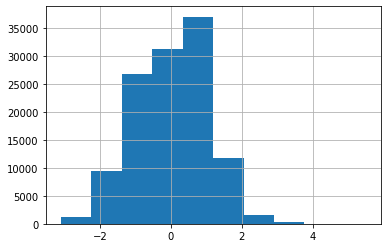

In [16]:
X_train['monthly_income'].hist()

В качестве меры целесообразности и качества биннинга будем использовать вес каждой категории (Weight of evidence - *WoE*), который может быть расчитан по формуле: <img src='https://4.bp.blogspot.com/-X1m0w40w0xg/V9V_7LS1AQI/AAAAAAAAFWc/f4bgPvE1In8Q13kGGBghp98MeWma8KgqACLcB/s1600/woe.png' img>
т.е. как логарифм отношения относительных частот двух классов в данной категории. Группировка выполняется так, чтобы максимизировать разницу между классами таргетной переменной.

При работе с данным показателем нужно придерживаться четырех правил:
* Количество категорий не должно превышать 10
* Каждая категория должна содержать не менее 5% наблюдений
* Категории не должны содержать нулевого окличества событий или не-событий
* Пропущенные значения группируются в отдельную категорию

Также стоит учесть, что в идеале *WoE* непропущенных значений должно быть монотонным, восходя от отрицательных значений к положительным или наоборот. Важно не столько абсолютное значение *WoE*, как разница между *WoE* групп. Чем больше разница между последующими категориями, тум выше прогнозная сила данной переменной.


In [17]:
import woe1

In [18]:
not_int_cols = qua_cols[~qua_cols.isin(['credit_month',
                                        'credit_month_sq',
                                        'credit_month_inv'])]

In [150]:
for col in not_int_cols:
    woe = woe1.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')
    # Зададим 10 бинов с не менее 10 записей, количественный предиктор и бинарный таргет.
    woe.fit(X_train[col], y_train.astype('int'))
    woe.transform(X_train[col])
    try:
        woe_mon = woe.force_monotonic()
    except:
        print(col, ' - unable to force_monotonic')
    print(f'\n{col}\n{woe_mon.bins}\n')


age
       mean   bad    obs   good       woe      bins labels
0  0.236624  4971  21008  16037 -0.372229      -inf      0
1  0.163369  6342  38820  32478  0.089863 -1.099322      1
2  0.162931  9726  59694  49968  0.093074 -0.061003      2


credit_sum
       mean    bad    obs   good       woe      bins labels
0  0.275881   2998  10867   7869 -0.578520      -inf      0
1  0.178840  11662  65209  53547 -0.019282 -1.315133      1
2  0.169936   3690  21714  18024  0.042572  0.347444      2
3  0.127646   1387  10866   9479  0.378430  1.042906      3
4  0.119823   1302  10866   9564  0.450598  1.462933      4

score_shk  - unable to force_monotonic

score_shk
       mean    bad    obs   good       woe      bins labels
0  0.275881   2998  10867   7869 -0.578520      -inf      0
1  0.178840  11662  65209  53547 -0.019282 -1.315133      1
2  0.169936   3690  21714  18024  0.042572  0.347444      2
3  0.127646   1387  10866   9479  0.378430  1.042906      3
4  0.119823   1302  10866   9564  0


payment_income_part_sq
       mean   bad    obs   good       woe      bins labels
0  0.214246  2328  10866   8538 -0.243989      -inf      0
1  0.201362  2188  10866   8678 -0.165703 -1.348355      1
2  0.194570  2114  10865   8751 -0.122920 -1.060975      2
3  0.187558  2038  10866   8828 -0.077547 -0.783051      3
4  0.178095  1935  10865   8930 -0.014197 -0.493981      4
5  0.176606  1919  10866   8947 -0.003992 -0.194172      5
6  0.171644  3730  21731  18001  0.030513  0.105396      6
7  0.160147  1740  10865   9125  0.113627  0.705867      7
8  0.148445  1613  10866   9253  0.203346  1.039161      8
9  0.131971  1434  10866   9432  0.340134  1.448029      9

payment_income_part_inv  - unable to force_monotonic

payment_income_part_inv
       mean   bad    obs   good       woe      bins labels
0  0.214246  2328  10866   8538 -0.243989      -inf      0
1  0.201362  2188  10866   8678 -0.165703 -1.348355      1
2  0.194570  2114  10865   8751 -0.122920 -1.060975      2
3  0.187558 

По результатам разбиения можно сказать, что для `age`, `overdue_credit_count` и `credit_count` и их производных биннинг не даст результатов, поскольку количество бинов - 2. Теперь оптимизируем бины  по метрике *roc_auc* с использованием CART.

In [19]:
bin_cols = ['credit_sum', 'score_shk', 'monthly_income',
            'month_payment', 'payment_income_part',
            'credit_sum_sq', 'credit_sum_inv', 'score_shk_sq',
            'score_shk_inv', 'monthly_income_sq', 'monthly_income_inv',
            'month_payment_sq', 'month_payment_inv',
            'payment_income_part_sq', 'payment_income_part_inv'] 

In [20]:
columns = []
fitted_bins = []
column_IV = []
bins_number = []

for col in bin_cols:
    woe = woe1.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')
    woe.fit(X_train[col], train['open_account_flg'].astype('int'))
    
    woe_optimized = woe.optimize(max_depth=4,
                                 scoring='roc_auc',
                                 cv=5,
                                 min_samples_leaf=50)
    columns.append(col)
    fitted_bins.append(woe_optimized.bins.bins.values)
    column_IV.append(woe_optimized.iv)
    bins_number.append(woe_optimized.bins.bins.shape[0])
    
binning_info = pd.DataFrame({'Переменная':columns,
                             'Бины':fitted_bins,
                             'IV':column_IV,
                             'Количество бинов':bins_number})\
                            .sort_values('IV', ascending=False)\
                            .set_index('Переменная')

In [21]:
binning_info

Бины  \
Переменная                                                                   
month_payment            [-inf, -2.0729215145111084, -1.349581480026245...   
month_payment_sq         [-inf, -1.7017749547958374, -1.325356781482696...   
month_payment_inv        [-inf, -2.1911081075668335, -1.323523700237274...   
credit_sum               [-inf, -2.33443284034729, -1.7860615849494934,...   
credit_sum_sq            [-inf, -1.7578452825546265, -1.56692636013031,...   
credit_sum_inv           [-inf, -1.9214598536491394, -1.168094694614410...   
score_shk                [-inf, -2.6325167417526245, -0.502278685569763...   
score_shk_sq             [-inf, -2.3391940593719482, -0.527974128723144...   
score_shk_inv            [-inf, -1.0486171245574951, -0.937468498945236...   
payment_income_part_sq   [-inf, -1.3832840323448181, -0.531706184148788...   
payment_income_part_inv  [-inf, -0.2940923720598221, -0.236789673566818...   
payment_income_part      [-inf, -1.4390771985054016, -0.414799556136131...   
monthly_income           [-inf, -2.6960264444351196, -2.405094981193542...   
monthly_income_sq        [-inf, -1.9952123165130615, -1.902463972568512...   
monthly_income_inv       [-inf, -2.480838418006897, -1.6150245070457458...   

                               IV  Количество бинов  
Переменная                                           
month_payment            0.077199                 8  
month_payment_sq         0.077199                 8  
month_payment_inv        0.077199                 8  
credit_sum               0.076708                 8  
credit_sum_sq            0.076708                 8  
credit_sum_inv           0.076708                 8  
score_shk                0.028251                 8  
score_shk_sq             0.028251                 8  
score_shk_inv            0.028135                 8  
payment_income_part_sq   0.026898                 8  
payment_income_part_inv  0.026891                 8  
payment_income_part      0.026878                 8  
monthly_income           0.008734                 8  
monthly_income_sq        0.008734                 8  
monthly_income_inv       0.008734                 8

Нашей задачей является категоризация переменной при условии максимально эффективного разделения одного класса от другого. Существует возможность разбить все переменные на множество категорий, однако, это чревато переобучением и усложнием модели. Возможным вариантом является сравнение "полезности" предиктора с остальными переменными. Самый простой вариант - использовать IV (от [information value](https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/)) или информационное значение. Его можно вычислить для отдельной категории и для всей переменной. Информационное значение для категории вычисляется как разность между относительной частотой класса 0 и относительной частотой класса 1 в данной категории, умноженная на натуральный логарифм отношения этих частот.

$ IV = \sum_{i = 1}^k(IV_i) = \sum_{i = 1}^k(F_i^0 - F_i^1)ln(\frac{F_i^0}{F_i^1})$




<table  width="50%" cellspacing="2" style="margin: 0px auto;">
    <tbody>
        <tr>
            <th>Information Value</th>
            <th>Предсказательная способность</th>
        </tr>
        <tr>
            <td>&lt;0.02</td>
            <th>не обладает</th>
        </tr>
        <tr>
            <td>0.02-0.1</td>
            <th>слабая</th>
        </tr>
        <tr>
            <td>0.1-0.3</td>
            <th>средняя</th>
        </tr>
        <tr>
            <td>0.3-0.5</td>
            <th>сильная</th>
        </tr>
        <tr>
            <td>&gt;0.5</td>
            <th>подозрительная (утечка?)</th>
        </tr>
    </tbody>
</table>


Отбросим `monthly_income_sq` и `monthly_income_inv` поскольку они не обладают никакой предсказательной силой. Для остальных переменных создадим соответствующие категории на основе полученных бинов.

In [22]:
for indicator in tqdm(['monthly_income_sq', 'monthly_income_inv']):
    for df in Xs_datasets:
        df.drop(indicator, axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 43.59it/s]


In [23]:
cols_to_categorize = binning_info[binning_info.IV > 0.02].index

for col in cols_to_categorize:
    for df in Xs_datasets:
        df[col + '_cat'] = pd.cut(df[col], binning_info.loc[col,'Бины']).astype('object')

In [24]:
cat_cols = X_train.dtypes[X_train.dtypes == 'object'].index

In [25]:
X_train_label = pd.get_dummies(X_train, columns=cat_cols, drop_first=True).copy()
X_valid_label = pd.get_dummies(X_valid, columns=cat_cols, drop_first=True).copy()
X_test_label = pd.get_dummies(X_test, columns=cat_cols, drop_first=True).copy()

In [26]:
labeled_Xs_datasets = [X_train_label, X_valid_label, X_test_label]

## Построение модели с категориями количественных переменных

In [27]:
lr_metrics_cat = pd.DataFrame(index=['roc-auc', 'precision',
                                 'recall', 'f1', 'logloss'])

In [30]:
lr_baseline_cat = make_log_reg(x_train=X_train_label,
                               y_train=y_train,
                               x_valid=X_valid_label,
                               y_valid=y_valid,
                               results_df=lr_metrics_cat,
                               model_name='lr_baseline_cat')

In [31]:
lr_metrics_cat

lr_baseline_cat
roc-auc           0.744886
precision         0.282262
recall            0.790763
f1                0.416024
logloss          13.496773

## Построение взаимодействия категории и значения переменных

Как можно заметить, мы увеличили характеристику ROC AUC за счет добавления новых переменных, т.о. мы создали модель логистической регрессии с дискретизированными признаками и одним глобальным наклоном гиперплоскости, теперь можно включить взаимодействие, указывающее на категорию точки данных и ее точное расположение по данной оси в пространстве - произведение индикатора категории и исходной переменной.

In [32]:
for df in labeled_Xs_datasets:
    for qua_col in cols_to_categorize:
        cols_to_mul = [col for col in df.columns
                       if (qua_col + '_cat') in col]
        for cat_col in cols_to_mul:
            df[cat_col + '_mul'] = df[qua_col] * df[cat_col]
        df.drop(qua_col, axis=1, inplace=True)

In [33]:
X_train_label.columns

Index(['age', 'credit_month', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'age_sq', 'age_inv', 'credit_month_sq',
       'credit_month_inv', 'credit_count_sq',
       ...
       'payment_income_part_inv_cat_(-0.201, -0.167]_mul',
       'payment_income_part_inv_cat_(-0.167, -0.0189]_mul',
       'payment_income_part_inv_cat_(-0.0189, -0.0183]_mul',
       'payment_income_part_inv_cat_(-0.0183, 0.351]_mul',
       'payment_income_part_cat_(-1.439, -0.415]_mul',
       'payment_income_part_cat_(-0.415, -0.412]_mul',
       'payment_income_part_cat_(-0.412, 0.627]_mul',
       'payment_income_part_cat_(0.627, 0.999]_mul',
       'payment_income_part_cat_(0.999, 1.531]_mul',
       'payment_income_part_cat_(1.531, 3.163]_mul'],
      dtype='object', length=283)

## Построение модели с взаимодействием категорий и количественных переменных

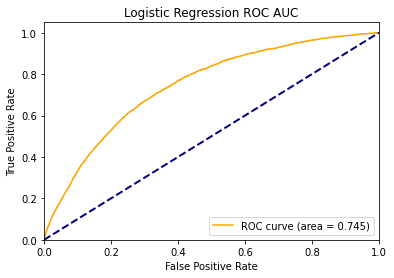

In [163]:
lr_qua_cat = make_log_reg(x_train=X_train_label,
                          y_train=y_train,
                          x_valid=X_valid_label,
                          y_valid=y_valid,
                          results_df=lr_metrics_cat,
                          model_name='lr_qua_cat')

In [164]:
lr_metrics_cat

lr_baseline_cat  lr_qua_cat
roc-auc           0.744886    0.744928
precision         0.282262    0.281058
recall            0.790763    0.796557
f1                0.416024    0.415508
logloss          13.496773   13.624586

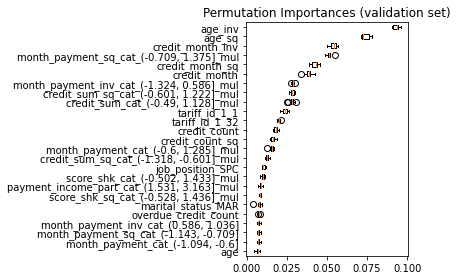

In [165]:
perm_imp_test = permutation_importance(lr_qua_cat,
                                       X_valid_label,
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_valid_label.columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

## Снижение размерности путем отсеивания признаков


На данном этапе отбираем признаки по их важности, для этого воспользуемся рекурсивным удалением признаков с перекрестной проверкой, которая реализована в классе RFECV библиотеки scikit-learn.

In [58]:
from sklearn.feature_selection import RFECV

lr_qua_cat_2 = LogisticRegression(class_weight='balanced',
                                  random_state=RND_STATE)

rfecv = RFECV(lr_qua_cat_2,
              scoring='roc_auc',
              n_jobs=-1,
              verbose=5)

In [59]:
%%time
rfecv.fit(X_train_label, y_train)

Fitting estimator with 283 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 282 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 281 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 280 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 279 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 278 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 277 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 276 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 275 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 274 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 273 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 272 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 271 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 270 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 269 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 268 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 267 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 266 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 265 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 264 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 263 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 262 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 261 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 260 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 259 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 258 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 257 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 256 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 255 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 254 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 253 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 252 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 251 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 250 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 249 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 248 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 247 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 246 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 245 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 244 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 243 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 242 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 241 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 240 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 239 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 238 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 237 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 236 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 235 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 234 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 233 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 232 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 231 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 230 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 229 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 228 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 227 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 226 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 225 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 224 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 223 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 222 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 221 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 220 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 219 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 218 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 217 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 216 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 215 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 214 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 213 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 212 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 211 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 210 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 209 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 208 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting estimator with 207 features.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Wall time: 31min 23s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


RFECV(estimator=LogisticRegression(class_weight='balanced', random_state=777),
      n_jobs=-1, scoring='roc_auc', verbose=5)

In [60]:
print(rfecv.n_features_)
print(X_train_label.loc[:,rfecv.support_].columns)

206
Index(['credit_month', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'age_sq', 'age_inv', 'credit_month_sq',
       'credit_month_inv', 'credit_count_sq', 'overdue_credit_count_sq',
       ...
       'score_shk_inv_cat_(-0.855, -0.854]_mul',
       'score_shk_inv_cat_(-0.763, 0.0871]_mul',
       'score_shk_inv_cat_(0.0871, 5.429]_mul',
       'payment_income_part_sq_cat_(-1.383, -0.532]_mul',
       'payment_income_part_sq_cat_(-0.532, -0.529]_mul',
       'payment_income_part_sq_cat_(0.691, 1.094]_mul',
       'payment_income_part_sq_cat_(1.094, 1.588]_mul',
       'payment_income_part_cat_(-0.415, -0.412]_mul',
       'payment_income_part_cat_(0.999, 1.531]_mul',
       'payment_income_part_cat_(1.531, 3.163]_mul'],
      dtype='object', length=206)


In [169]:
# predictive_cols = ['age', 'credit_sum', 'credit_month', 'score_shk',
#                    'monthly_income', 'credit_count', 'overdue_credit_count',
#                    'month_payment', 'age_sq', 'age_inv', 'credit_sum_sq',
#                    'credit_sum_inv', 'credit_month_sq', 'credit_month_inv',
#                    'score_shk_inv', 'credit_count_sq', 'overdue_credit_count_sq',
#                    'month_payment_inv', 'payment_income_part_sq', 'payment_income_part_inv',
#                    'gender_M', 'marital_status_MAR', 'job_position_BIS', 'job_position_BIU',
#                    'job_position_DIR', 'job_position_INP', 'job_position_NOR',
#                    'job_position_PNA', 'job_position_PNI', 'job_position_SPC',
#                    'job_position_UMN', 'job_position_WRK', 'job_position_WRP',
#                    'tariff_id_1_1', 'tariff_id_1_16', 'tariff_id_1_17',
#                    'tariff_id_1_19', 'tariff_id_1_2', 'tariff_id_1_21',
#                    'tariff_id_1_23', 'tariff_id_1_24', 'tariff_id_1_25',
#                    'tariff_id_1_3', 'tariff_id_1_32', 'tariff_id_1_41',
#                    'tariff_id_1_43', 'tariff_id_1_5', 'tariff_id_1_7',
#                    'tariff_id_1_9', 'tariff_id_1_91', 'tariff_id_1_99',
#                    'education_PGR', 'education_SCH', 'living_region_АДЫГЕЯ',
#                    'living_region_АСТРАХАНСКАЯ', 'living_region_БАШКОРТОСТАН',
#                    'living_region_ВЛАДИМИРСКАЯ', 'living_region_ВОЛОГОДСКАЯ',
#                    'living_region_ДАГЕСТАН', 'living_region_ЕВРЕЙСКАЯ',
#                    'living_region_КАБАРДИНО-БАЛКАРСКАЯ', 'living_region_КАЛИНИНГРАДСКАЯ',
#                    'living_region_КАЛМЫКИЯ', 'living_region_КАРАЧАЕВО-ЧЕРКЕССКАЯ',
#                    'living_region_КАРЕЛИЯ', 'living_region_КОСТРОМСКАЯ',
#                    'living_region_КУРГАНСКАЯ', 'living_region_ЛИПЕЦКАЯ',
#                    'living_region_МАГАДАНСКАЯ', 'living_region_МАРИЙЭЛ',
#                    'living_region_МОРДОВИЯ', 'living_region_МОСКВА',
#                    'living_region_МУРМАНСКАЯ', 'living_region_НЕ УКАЗАН',
#                    'living_region_НЕНЕЦКИЙ', 'living_region_НИЖЕГОРОДСКАЯ',
#                    'living_region_НОВГОРОДСКАЯ', 'living_region_ОРЕНБУРГСКАЯ',
#                    'living_region_ПЕНЗЕНСКАЯ', 'living_region_ПЕРМСКИЙ',
#                    'living_region_ПРИМОРСКИЙ', 'living_region_ПСКОВСКАЯ',
#                    'living_region_РЯЗАНСКАЯ', 'living_region_САМАРСКАЯ',
#                    'living_region_САРАТОВСКАЯ', 'living_region_САХА/ЯКУТИЯ/',
#                    'living_region_САХАЛИНСКАЯ', 'living_region_СВЕРДЛОВСКАЯ',
#                    'living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ', 'living_region_СМОЛЕНСКАЯ',
#                    'living_region_СТАВРОПОЛЬСКИЙ', 'living_region_ТАМБОВСКАЯ',
#                    'living_region_ТАТАРСТАН', 'living_region_ТОМСКАЯ',
#                    'living_region_ТЫВА', 'living_region_УЛЬЯНОВСКАЯ',
#                    'living_region_ХАКАСИЯ', 'living_region_ЯМАЛО-НЕНЕЦКИЙ',
#                    'living_region_ЯРОСЛАВСКАЯ', 'credit_sum_cat_(-1.33, -0.49]',
#                    'credit_sum_cat_(-0.49, 1.119]', 'credit_sum_cat_(1.119, 2.016]',
#                    'credit_sum_sq_cat_(-1.315, -0.6]', 'credit_sum_sq_cat_(-0.6, 1.214]',
#                    'credit_sum_sq_cat_(1.214, 1.922]', 'credit_sum_inv_cat_(-1.888, -1.16]',
#                    'credit_sum_inv_cat_(-1.16, 0.486]', 'credit_sum_inv_cat_(0.486, 1.27]',
#                    'month_payment_cat_(-1.919, -1.35]', 'month_payment_cat_(-1.096, -0.507]',
#                    'month_payment_cat_(-0.507, 1.228]', 'month_payment_cat_(1.228, 2.481]',
#                    'month_payment_sq_cat_(-1.639, -1.326]', 'month_payment_sq_cat_(-1.144, -0.615]',
#                    'month_payment_sq_cat_(-0.615, 1.322]', 'month_payment_sq_cat_(1.322, 2.183]',
#                    'month_payment_inv_cat_(-2.185, -1.269]', 'month_payment_inv_cat_(-1.269, 0.502]',
#                    'month_payment_inv_cat_(0.502, 1.038]', 'month_payment_inv_cat_(1.102, 1.29]',
#                    'month_payment_inv_cat_(1.29, 1.963]', 'score_shk_cat_(1.43, 1.847]',
#                    'score_shk_cat_(2.197, 3.088]', 'score_shk_sq_cat_(1.433, 1.831]',
#                    'score_shk_sq_cat_(2.162, 2.996]', 'score_shk_inv_cat_(-1.106, -0.964]',
#                    'score_shk_inv_cat_(-0.894, -0.795]', 'score_shk_inv_cat_(0.0887, 5.137]',
#                    'payment_income_part_cat_(0.504, 0.505]', 'payment_income_part_sq_cat_(0.547, 0.549]',
#                    'payment_income_part_inv_cat_(-0.51, -0.508]', 'credit_sum_cat_(-2.338, -1.816]_mul',
#                    'credit_sum_cat_(-1.816, -1.516]_mul', 'credit_sum_cat_(-1.516, -1.33]_mul',
#                    'credit_sum_cat_(-0.49, 1.119]_mul', 'credit_sum_sq_cat_(-1.76, -1.581]_mul',
#                    'credit_sum_sq_cat_(-1.581, -1.429]_mul', 'credit_sum_sq_cat_(-1.429, -1.315]_mul',
#                    'credit_sum_inv_cat_(-1.16, 0.486]_mul', 'credit_sum_inv_cat_(1.27, 1.471]_mul',
#                    'credit_sum_inv_cat_(1.471, 1.836]_mul', 'month_payment_cat_(-1.919, -1.35]_mul',
#                    'month_payment_cat_(-1.096, -0.507]_mul', 'month_payment_cat_(1.228, 2.481]_mul',
#                    'month_payment_sq_cat_(-1.144, -0.615]_mul', 'month_payment_sq_cat_(-0.615, 1.322]_mul',
#                    'month_payment_inv_cat_(-1.269, 0.502]_mul', 'month_payment_inv_cat_(0.502, 1.038]_mul',
#                    'month_payment_inv_cat_(1.29, 1.963]_mul', 'score_shk_cat_(-0.487, 1.43]_mul',
#                    'score_shk_cat_(1.43, 1.847]_mul', 'score_shk_cat_(1.847, 2.181]_mul',
#                    'score_shk_sq_cat_(1.831, 2.146]_mul', 'score_shk_inv_cat_(-1.106, -0.964]_mul',
#                    'score_shk_inv_cat_(-0.795, 0.0887]_mul', 'payment_income_part_cat_(1.283, 1.287]_mul',
#                    'payment_income_part_sq_cat_(1.371, 1.375]_mul',
#                    'payment_income_part_inv_cat_(-1.332, -1.328]_mul']

In [61]:
dropped = X_train_label.loc[:,~rfecv.support_].columns
print(dropped)

Index(['age', 'credit_count_inv', 'job_position_PNI', 'education_GRD',
       'education_UGR', 'living_region_АЛТАЙСКИЙ', 'living_region_АМУРСКАЯ',
       'living_region_БЕЛГОРОДСКАЯ', 'living_region_БРЯНСКАЯ',
       'living_region_ВОЛГОГРАДСКАЯ', 'living_region_ИРКУТСКАЯ',
       'living_region_КАЛУЖСКАЯ', 'living_region_КУРСКАЯ',
       'living_region_ЛЕНИНГРАДСКАЯ', 'living_region_ЛИПЕЦКАЯ',
       'living_region_НОВОСИБИРСКАЯ', 'living_region_ОМСКАЯ',
       'living_region_ОРЕНБУРГСКАЯ', 'living_region_РОСТОВСКАЯ',
       'living_region_САНКТ-ПЕТЕРБУРГ', 'living_region_ТВЕРСКАЯ',
       'living_region_ТУЛЬСКАЯ', 'living_region_УДМУРТСКАЯ',
       'living_region_ХАКАСИЯ', 'living_region_ЧЕЛЯБИНСКАЯ',
       'month_payment_cat_(-1.163, -1.094]',
       'month_payment_sq_cat_(-1.702, -1.325]',
       'month_payment_sq_cat_(-1.325, -1.194]',
       'month_payment_sq_cat_(-1.194, -1.143]',
       'month_payment_inv_cat_(1.036, 1.103]',
       'credit_sum_cat_(-1.349, -1.336]', 'credit_

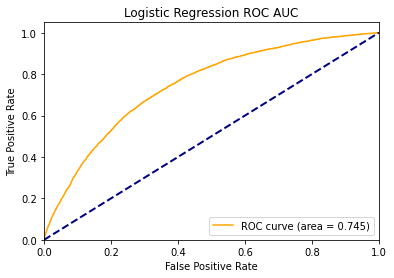

In [62]:
lr_qua_cat_rfe = make_log_reg(x_train=X_train_label.loc[:,rfecv.support_],
                               y_train=y_train,
                               x_valid=X_valid_label.loc[:,rfecv.support_],
                               y_valid=y_valid,
                               results_df=lr_metrics_cat,
                               model_name='lr_qua_cat_rfe')

In [63]:
lr_metrics_cat

lr_baseline_cat  tuned_lr_qua_cat_wo_drop  lr_baseline_cat1  \
roc-auc           0.744886                  0.745291          0.745291   
precision         0.282262                  0.284605          0.284605   
recall            0.790763                  0.788611          0.788611   
f1                0.416024                  0.418262          0.418262   
logloss          13.496773                 13.336755         13.336755   

           lr_qua_cat_rfe  
roc-auc          0.744899  
precision        0.281800  
recall           0.795067  
f1               0.416114  
logloss         13.565208

Попробуем провести отброс параметров еще раз, но в этот раз передадим в линейную регрессию большее число итераций.

In [173]:
lr_qua_cat_3 = LogisticRegression(class_weight='balanced',
                                  random_state=RND_STATE,
                                  max_iter=1000)

rfecv1 = RFECV(lr_qua_cat_3,
              scoring='roc_auc',
              n_jobs=-1,
              verbose=5)

In [174]:
rfecv1.fit(X_train_label.loc[:,rfecv.support_], y_train)

RFECV(estimator=LogisticRegression(class_weight='balanced', max_iter=1000,
                                   random_state=777),
      n_jobs=-1, scoring='roc_auc', verbose=5)

In [175]:
print(rfecv.n_features_)
print(X_train_label.loc[:,rfecv.support_].columns)

206
Index(['credit_month', 'monthly_income', 'credit_count',
       'overdue_credit_count', 'age_sq', 'age_inv', 'credit_month_sq',
       'credit_month_inv', 'credit_count_sq', 'overdue_credit_count_sq',
       ...
       'score_shk_inv_cat_(-0.855, -0.854]_mul',
       'score_shk_inv_cat_(-0.763, 0.0871]_mul',
       'score_shk_inv_cat_(0.0871, 5.429]_mul',
       'payment_income_part_sq_cat_(-1.383, -0.532]_mul',
       'payment_income_part_sq_cat_(-0.532, -0.529]_mul',
       'payment_income_part_sq_cat_(0.691, 1.094]_mul',
       'payment_income_part_sq_cat_(1.094, 1.588]_mul',
       'payment_income_part_cat_(-0.415, -0.412]_mul',
       'payment_income_part_cat_(0.999, 1.531]_mul',
       'payment_income_part_cat_(1.531, 3.163]_mul'],
      dtype='object', length=206)


Можно заметить, что это не принесло результатов. Таким образом, можно взять на заметку, что отсеивание переменных можно проводить при низком количестве итераций оптимизатора.


###  Кривая заучивания
С помощью данной кривой оценим эффект влияния количества наблюдений в тренировочном наборе на метрический показатель roc-auc.

In [176]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(max_iter=1000),
                                        X_train_label.loc[:,rfecv.support_],
                                        y_train,
                                        cv=7,
                                        scoring='roc_auc',
                                        n_jobs=-1,
                                        train_sizes=np.linspace(0.01, 1.0, 40))

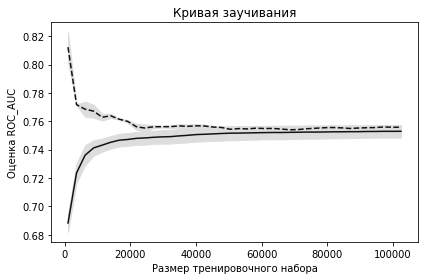

In [177]:
# Создать средние и стандартные отклонения оценок тренировочного набора
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Создать средние и стандартные отклонения оценок тестового набора
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Нанести линии
plt.plot(train_sizes, train_mean, "--", color="#111111",
         label="Тренировочная оценка")
plt.plot(train_sizes, test_mean, color="#111111",
         label="Перекрестно-проверочная оценка")
# Нанести полосы
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color="#DDDDDD")
# Построить график
plt.title("Кривая заучивания")
plt.xlabel("Размер тренировочного набора")
plt.ylabel("Оценка ROC_AUC")
plt.tight_layout()

**Можно заключить, что сбор дополнительной информации (тренировочных данных) в данном случае не обязателен, поскольку, как мы видим, оценка ROC AUC вышла на плато при размере тренировочного набора в 60000 записей.**

In [178]:
! telegram-send 'learning_curve ready'

###  Эффект значений гиперпараметра
На данном этапе постараемся разобраться в том, как результативность модели изменяется по мере изменения значений некоторого гиперпараметра. Для этого построим график валидационной кривой.

In [179]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(LogisticRegression(penalty='l1', solver="liblinear"),
                                            X_train_label.loc[:,rfecv.support_],
                                            y_train,
                                            param_name='C',
                                            param_range=np.linspace(0.1, 10., 40),
                                            cv=3,
                                            scoring='roc_auc',
                                            n_jobs=-1)

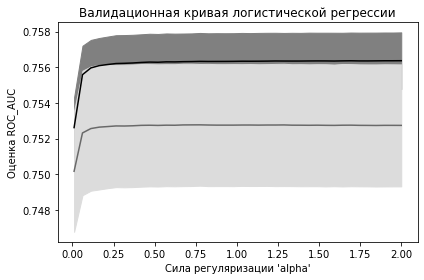

In [180]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Вычислить среднее и стандартное отклонение для оценок
# тестового набора
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Построить график средних оценок точности
# для тренировочного и тестового наборов
plt.plot(np.linspace(0.01, 2.0, 40), train_mean, color="black",
         label="Тренировочная оценка")
plt.plot(np.linspace(0.01, 2.0, 40), test_mean, color="dimgrey",
         label="Перекрестно-проверочная оценка")

# Нанести полосы точности для тренировочного и тестового наборов
plt.fill_between(np.linspace(0.01, 2.0, 40), train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(np.linspace(0.01, 2.0, 40), test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

plt.title("Валидационная кривая логистической регрессии")
plt.xlabel("Сила регуляризации 'С'")
plt.ylabel("Оценка ROC_AUC")
plt.tight_layout()

In [181]:
! telegram-send 'validation_curve ready'

## Оптимизация модели с взаимодействием категорий и количественных переменных

In [182]:
parameters_grid = {
    'penalty': ['l1', 'l2' 'elasticnet'],
    'C': np.linspace(0.1, 2, num=5),
    'solver': ['sag', 'saga', 'lbfgs', 'liblinear'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(1000, 1500, 100)
}

In [183]:
!telegram-send "lr_qua_cat_1 optimization started!"

In [184]:
%%time
grid_cv_wcols_ncorr = find_optimal_params(x_train=X_train_label.loc[:,rfecv.support_],
                                          y_train=y_train,
                                          parameters_grid=parameters_grid)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


One or more of the test scores are non-finite: [       nan 0.75225513        nan 0.75221536        nan        nan
        nan        nan        nan 0.75225513        nan 0.75221536
        nan        nan        nan        nan        nan 0.75225513
        nan 0.75221536        nan        nan        nan        nan
        nan 0.75225513        nan 0.75221536        nan        nan
        nan        nan        nan 0.75225513        nan 0.75221536
        nan        nan        nan        nan        nan 0.75225513
        nan 0.75221536        nan        nan        nan        nan
        nan 0.75225513        nan 0.75221536        nan        nan
        nan        nan        nan 0.75225513        nan 0.75221536
        nan        nan        nan        nan        nan 0.75225513
        nan 0.75221536        nan        nan        nan        nan
        nan 0.75225513        nan 0.75221536        nan        nan
        nan        nan        nan 0.75225513        nan 0.75221536
        nan    

Наилучший ROC AUC = 0.7533
Наилучшие параметры: {'C': 2.0, 'l1_ratio': 0.2, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Wall time: 7h 44min 20s


In [185]:
!telegram-send "lr_qua_cat_1 optimization is over!"

In [188]:
best_params_qua_cat = grid_cv_wcols_ncorr.best_params_

In [45]:
# best_params_qua_cat = {'C': 2.0,
#                        'max_iter': 1000,
#                        'penalty': 'l1',
#                        'solver': 'saga'}

In [189]:
tuned_lr_qua_cat = make_log_reg(x_train=X_train_label.loc[:,rfecv.support_],
                                y_train=y_train,
                                x_valid=X_valid_label.loc[:,rfecv.support_],
                                y_valid=y_valid,
                                results_df=lr_metrics_cat,
                                parameters=best_params_qua_cat,
                                model_name='tuned_lr_qua_cat')

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


In [190]:
lr_metrics_cat.style.highlight_max(axis=1, color='lightblue')

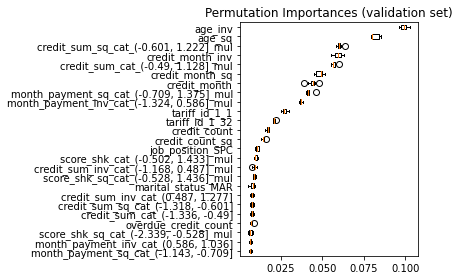

In [191]:
perm_imp_test = permutation_importance(tuned_lr_qua_cat,
                                       X_valid_label.loc[:,rfecv.support_],
                                       y_valid,
                                       n_repeats=10,
                                       random_state=RND_STATE)

sorted_idx = perm_imp_test.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp_test.importances[sorted_idx][-25:].T, vert=False,
    labels=X_valid_label.loc[:,rfecv.support_].columns[sorted_idx][-25:]
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

Поскольку после оптимизации гиперпараметров было обнаружено, что оптимум лежит на краю исследуемого диапазона, то необходимо провести его расширение для поиска глобального максимума.

In [64]:
parameters_grid_2 = {
    'penalty': ['l1', 'l2' 'elasticnet'],
    'C': np.linspace(2, 12, num=5),
    'solver': ['sag', 'saga', 'lbfgs', 'liblinear'],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8],
    'max_iter': np.arange(500, 1000, 100)
}

In [65]:
!telegram-send "lr_qua_cat_2 optimization started!"

In [66]:
%%time
grid_cv_wcols_ncorr_2 = find_optimal_params(x_train=X_train_label.loc[:,rfecv.support_],
                                            y_train=y_train,
                                            parameters_grid=parameters_grid_2,
                                            n_jobs=1)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 1/5; 1/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag.
[CV 1/5; 1/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 1/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag.


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 1/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 1/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag.
[CV 3/5; 1/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 1/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag.


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 1/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 1/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag.
[CV 5/5; 1/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 2/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 2/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 2.5min
[CV 2/5; 2/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 2/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 2.6min
[CV 3/5; 2/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 2/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 2.2min
[CV 4/5; 2/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 2/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 2.7min
[CV 5/5; 2/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 5/5; 2/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 2.4min
[CV 1/5; 3/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 3/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 3/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 3/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 3/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 3/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 3/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 3/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 3/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 5/5; 3/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 4/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 4/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 2.4min
[CV 2/5; 4/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 4/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 2.7min
[CV 3/5; 4/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 4/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 2.8min
[CV 4/5; 4/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 4/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 3.0min
[CV 5/5; 4/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 4/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.8min
[CV 1/5; 5/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 5/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 5/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 5/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 5/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 5/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 5/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 5/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 5/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 5/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 6/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 6/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 6/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 6/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 6/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 3/5; 6/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 6/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 6/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 6/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 6/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 7/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 7/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 7/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 7/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 7/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 7/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 7/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 7/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 7/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 7/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 8/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 8/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 8/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 8/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 8/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 8/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 8/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 8/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 8/800] START C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 8/800] END C=2.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 9/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag.
[CV 1/5; 9/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 9/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag.


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 9/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 9/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag.
[CV 3/5; 9/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 9/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag.


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 9/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 9/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag.
[CV 5/5; 9/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 10/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 10/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.6min
[CV 2/5; 10/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 10/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.5min
[CV 3/5; 10/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 10/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.8min
[CV 4/5; 10/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 10/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.6min
[CV 5/5; 10/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 10/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 11/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 11/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 11/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 11/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 11/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 11/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 11/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 11/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 11/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 11/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 12/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 12/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 3.0min
[CV 2/5; 12/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 12/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 2.9min
[CV 3/5; 12/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 12/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 2.6min
[CV 4/5; 12/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 12/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 3.2min
[CV 5/5; 12/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 12/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.6min
[CV 1/5; 13/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 13/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 13/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 13/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 13/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 13/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 13/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 13/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 13/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 13/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 14/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 14/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 14/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 14/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 14/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 14/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 14/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 14/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 14/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 14/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 15/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 15/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 15/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 15/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 15/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 15/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 15/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 15/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 15/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 15/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 16/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 16/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 16/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 16/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 16/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 16/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 16/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 16/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 16/800] START C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 16/800] END C=2.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 17/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 17/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 17/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 17/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 17/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 17/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 17/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 17/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 17/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 17/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 18/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 18/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.6min
[CV 2/5; 18/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 18/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.3min
[CV 3/5; 18/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 18/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.5min
[CV 4/5; 18/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 18/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.4min
[CV 5/5; 18/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 18/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.3min
[CV 1/5; 19/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 19/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 19/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 19/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 19/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 19/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 19/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 19/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 19/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 19/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 20/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 20/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 3.0min
[CV 2/5; 20/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 20/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 2.8min
[CV 3/5; 20/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 20/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 2.7min
[CV 4/5; 20/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 20/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 3.2min
[CV 5/5; 20/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 20/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.8min
[CV 1/5; 21/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 21/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 21/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 21/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 21/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 21/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 21/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 21/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 21/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 21/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 22/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 22/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 22/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 22/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 22/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 22/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 22/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 4/5; 22/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 22/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 22/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 23/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 23/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 23/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 23/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 23/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 23/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 23/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 23/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 23/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 23/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 24/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 24/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 24/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 24/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 24/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 24/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 24/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 24/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 24/800] START C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 24/800] END C=2.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 25/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 25/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 25/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 25/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 25/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 25/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 25/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 25/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 25/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 5/5; 25/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 26/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 26/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.2min
[CV 2/5; 26/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 26/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.1min
[CV 3/5; 26/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 26/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 26/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 26/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.749 total time= 6.2min
[CV 5/5; 26/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 26/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.3min
[CV 1/5; 27/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 27/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 27/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 27/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 27/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 27/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 27/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 27/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 27/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 27/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 28/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 28/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 3.4min
[CV 2/5; 28/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 28/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.0min
[CV 3/5; 28/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 28/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 3.1min
[CV 4/5; 28/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 28/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 3.6min
[CV 5/5; 28/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 28/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 1/5; 29/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 29/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 29/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 29/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 29/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 29/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 29/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 4/5; 29/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 29/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 29/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 30/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 1/5; 30/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 30/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 30/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 30/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 30/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 30/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 30/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 30/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 5/5; 30/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 31/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 31/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 31/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 31/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 31/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 31/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 31/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 31/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 31/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 31/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 32/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 32/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 32/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 32/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 32/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 32/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 32/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 32/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 32/800] START C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 32/800] END C=2.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 33/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 1/5; 33/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 33/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 33/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 33/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 33/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 33/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 33/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 33/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 5/5; 33/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 34/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 34/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.1min
[CV 2/5; 34/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 34/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.5min
[CV 3/5; 34/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 34/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 34/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 34/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.749 total time= 6.8min
[CV 5/5; 34/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 34/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.1min
[CV 1/5; 35/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 35/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 35/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 35/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 35/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 35/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 35/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 35/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 35/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 35/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 36/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 36/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 3.1min
[CV 2/5; 36/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 36/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.3min
[CV 3/5; 36/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 36/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 3.2min
[CV 4/5; 36/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 36/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 3.4min
[CV 5/5; 36/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 36/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 1/5; 37/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 37/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 37/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 37/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 37/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 37/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 37/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 37/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 37/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 37/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 38/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 38/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 38/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 38/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 38/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 38/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 38/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 38/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 38/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 38/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 39/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 39/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 39/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 39/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 39/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 39/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 39/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 39/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 39/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 39/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 40/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 40/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 40/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 40/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 40/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 40/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 40/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 40/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 40/800] START C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 40/800] END C=2.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 41/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 41/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 41/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 2/5; 41/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 41/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 41/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 41/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 4/5; 41/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 41/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 41/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 42/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 42/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 42/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 42/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 42/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 42/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.9min
[CV 4/5; 42/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 42/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 42/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 42/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 4.0min
[CV 1/5; 43/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 43/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 43/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 43/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 43/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 43/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 43/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 43/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 43/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 43/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 44/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 44/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 3.3min
[CV 2/5; 44/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 44/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 2.9min
[CV 3/5; 44/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 44/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 3.1min
[CV 4/5; 44/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 44/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 44/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 44/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 1/5; 45/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 45/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 45/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 45/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 45/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 45/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 45/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 45/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 45/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 45/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 46/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 46/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 46/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 46/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 46/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 46/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 46/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 46/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 46/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 46/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 47/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 47/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 47/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 47/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 47/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 47/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 47/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 47/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 47/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 47/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 48/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 48/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 48/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 48/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 48/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 48/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 48/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 48/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 48/800] START C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 48/800] END C=2.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 49/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 1/5; 49/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 49/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 49/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 49/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 3/5; 49/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 49/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 49/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 49/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 5/5; 49/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 50/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 50/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.8min
[CV 2/5; 50/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 50/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.8min
[CV 3/5; 50/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 50/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.6min
[CV 4/5; 50/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 50/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.6min
[CV 5/5; 50/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 50/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 51/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 51/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 51/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 51/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 51/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 51/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 51/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 51/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 51/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 51/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 52/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 52/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 3.3min
[CV 2/5; 52/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 52/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.1min
[CV 3/5; 52/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 52/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 3.1min
[CV 4/5; 52/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 52/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 3.6min
[CV 5/5; 52/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 52/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 4.1min
[CV 1/5; 53/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 53/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 53/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 53/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 53/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 53/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 53/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 53/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 53/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 53/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 54/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 54/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 54/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 54/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 54/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 54/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 54/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 54/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 54/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 54/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 55/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 55/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 55/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 55/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 55/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 55/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 55/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 55/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 55/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 55/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 56/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 56/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 56/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 56/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 56/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 56/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 56/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 56/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 56/800] START C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 56/800] END C=2.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 57/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 57/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 57/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 57/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 57/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 57/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 57/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 57/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 57/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 57/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 58/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 58/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.4min
[CV 2/5; 58/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 58/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 3/5; 58/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 58/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.5min
[CV 4/5; 58/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 58/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.4min
[CV 5/5; 58/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 58/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 1/5; 59/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 59/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 59/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 59/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 59/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 59/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 59/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 59/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 59/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 59/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 60/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 60/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 3.1min
[CV 2/5; 60/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 60/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 60/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 60/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 2.9min
[CV 4/5; 60/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 60/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 3.4min
[CV 5/5; 60/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 60/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 1/5; 61/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 61/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 61/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 61/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 61/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 61/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 61/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 61/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 61/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 61/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 62/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 62/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 62/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 62/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 62/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 62/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 62/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 4/5; 62/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 62/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 62/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 63/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 63/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 63/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 63/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 63/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 63/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 63/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 63/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 63/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 63/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 64/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 64/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 64/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 64/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 64/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 64/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 64/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 64/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 64/800] START C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 64/800] END C=2.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 65/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 65/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 65/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 2/5; 65/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 65/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 65/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 65/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 65/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 65/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 65/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 66/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 66/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.2min
[CV 2/5; 66/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 66/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 3/5; 66/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 66/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.1min
[CV 4/5; 66/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 66/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.749 total time= 6.1min
[CV 5/5; 66/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 66/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.1min
[CV 1/5; 67/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 67/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 67/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 67/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 67/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 67/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 67/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 67/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 67/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 67/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 68/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 68/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 3.5min
[CV 2/5; 68/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 68/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 68/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 68/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 3.1min
[CV 4/5; 68/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 68/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 3.8min
[CV 5/5; 68/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 68/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 4.1min
[CV 1/5; 69/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 69/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 69/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 69/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 69/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 69/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 69/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 69/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 69/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 69/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 70/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 70/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 70/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 70/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 70/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 70/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 70/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 70/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 70/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 70/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 71/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 71/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 71/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 71/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 71/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 71/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 71/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 71/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 71/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 71/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 72/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 72/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 72/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 2/5; 72/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 72/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 72/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 72/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 72/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 72/800] START C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 72/800] END C=2.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 73/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 73/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 73/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 73/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 73/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 73/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 73/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 73/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 73/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 73/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 74/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga
[CV 1/5; 74/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.0min
[CV 2/5; 74/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 74/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.8min
[CV 3/5; 74/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 74/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 74/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 74/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.749 total time= 6.8min
[CV 5/5; 74/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 74/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.1min
[CV 1/5; 75/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 75/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 75/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 75/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 75/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 75/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 75/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 4/5; 75/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 75/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 75/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 76/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 76/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 3.3min
[CV 2/5; 76/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 76/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.1min
[CV 3/5; 76/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 76/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 3.1min
[CV 4/5; 76/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 76/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 3.7min
[CV 5/5; 76/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 76/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 1/5; 77/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 77/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 77/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 2/5; 77/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 77/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 77/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 77/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 4/5; 77/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 77/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 77/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 78/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 78/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 78/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 78/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 78/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 78/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 78/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 78/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 78/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 5/5; 78/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 79/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 79/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 79/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 2/5; 79/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 79/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 79/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 79/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 79/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 79/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 79/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 80/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 80/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 80/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 80/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 80/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 80/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 80/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 80/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 80/800] START C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 80/800] END C=2.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 81/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 81/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 81/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 81/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 81/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 81/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 81/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 81/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 81/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 81/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 82/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 82/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 4.0min
[CV 2/5; 82/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 82/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 3/5; 82/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 3/5; 82/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.8min
[CV 4/5; 82/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 82/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.8min
[CV 5/5; 82/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 82/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 83/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 83/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 83/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 83/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 83/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 83/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 83/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 4/5; 83/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 83/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 83/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 84/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 84/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 3.5min
[CV 2/5; 84/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 84/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.3min
[CV 3/5; 84/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 84/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 3.3min
[CV 4/5; 84/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 84/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 84/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 84/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 4.4min
[CV 1/5; 85/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 85/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 85/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 85/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 85/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 85/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 85/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 85/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 85/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 85/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 86/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 1/5; 86/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 86/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 86/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 86/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 3/5; 86/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 86/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 86/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 86/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 5/5; 86/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 87/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 87/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 87/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 87/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 87/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 87/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 87/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 87/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 87/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 87/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 88/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 88/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 88/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 88/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 88/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 88/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 88/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 88/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 88/800] START C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 88/800] END C=2.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 89/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li


[CV 1/5; 89/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 89/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 89/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 89/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 89/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 89/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 89/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 89/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 89/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 90/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 90/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.6min
[CV 2/5; 90/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 90/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.6min
[CV 3/5; 90/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 90/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.6min
[CV 4/5; 90/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 90/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.5min
[CV 5/5; 90/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 90/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 91/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 91/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 91/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 91/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 91/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 91/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 91/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 91/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 91/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 91/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 92/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 92/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 3.3min
[CV 2/5; 92/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 92/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.1min
[CV 3/5; 92/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 92/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 3.2min
[CV 4/5; 92/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 92/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 3.7min
[CV 5/5; 92/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 92/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 1/5; 93/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 93/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 93/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 93/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 93/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 93/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 93/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 93/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 93/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 93/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 94/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 94/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 94/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 94/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 94/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 94/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 94/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 94/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 94/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 94/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 95/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 95/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 95/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 95/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 95/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 95/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 95/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 95/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 95/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 95/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 96/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 96/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 96/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 96/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 96/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 96/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 96/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 96/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 96/800] START C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 96/800] END C=2.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 97/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 97/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 97/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 97/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 97/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 97/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 97/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 97/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 97/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 97/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 98/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 98/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.4min
[CV 2/5; 98/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 98/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.3min
[CV 3/5; 98/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 98/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.4min
[CV 4/5; 98/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 98/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.6min
[CV 5/5; 98/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 98/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 1/5; 99/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 99/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 99/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 99/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 99/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 99/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 99/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 4/5; 99/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 99/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 99/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 100/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 100/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 3.2min
[CV 2/5; 100/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 100/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 100/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 100/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 3.0min
[CV 4/5; 100/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 100/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 100/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 100/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 4.4min
[CV 1/5; 101/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 101/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 101/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 2/5; 101/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 101/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 101/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 101/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 4/5; 101/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 101/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 101/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 102/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 1/5; 102/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 102/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 102/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 102/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 102/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 102/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 102/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 102/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 102/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 103/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.




[CV 1/5; 103/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 103/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 103/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 103/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 103/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 103/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 103/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 103/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 103/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 104/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 104/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 104/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 104/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 104/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 104/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 104/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 104/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 104/800] START C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 104/800] END C=2.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 105/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 105/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 105/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 105/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 105/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 105/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 105/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 105/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 105/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 5/5; 105/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 106/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 106/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.1min
[CV 2/5; 106/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 106/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 3/5; 106/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 106/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.3min
[CV 4/5; 106/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 106/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.749 total time= 6.2min
[CV 5/5; 106/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 106/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 1/5; 107/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 107/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 107/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 107/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 107/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 107/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 107/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 107/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 107/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 107/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 108/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 108/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 3.2min
[CV 2/5; 108/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 108/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.3min
[CV 3/5; 108/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 108/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 3.0min
[CV 4/5; 108/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 108/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 3.7min
[CV 5/5; 108/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 108/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 4.1min
[CV 1/5; 109/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 109/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 109/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 109/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 109/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 109/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 109/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 109/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 109/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 109/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 110/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 110/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 110/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 110/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 110/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 110/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 110/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 110/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 110/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 110/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 111/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 111/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 111/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 111/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 111/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 111/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 111/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 111/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 111/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 111/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 112/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 112/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 112/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 112/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 112/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 112/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 112/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 112/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 112/800] START C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 112/800] END C=2.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 113/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 1/5; 113/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 113/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 113/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 113/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 113/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 113/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 113/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 113/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 5/5; 113/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 114/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 114/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 6.9min
[CV 2/5; 114/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 114/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.7min
[CV 3/5; 114/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 114/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 6.4min
[CV 4/5; 114/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 114/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.749 total time= 7.1min
[CV 5/5; 114/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 114/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 1/5; 115/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 115/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 115/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 2/5; 115/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 115/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 115/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 115/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 115/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 115/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 115/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 116/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 116/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 3.2min
[CV 2/5; 116/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 116/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.1min
[CV 3/5; 116/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 116/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 3.1min
[CV 4/5; 116/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 116/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 116/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 116/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 4.4min
[CV 1/5; 117/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 117/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 117/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 117/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 117/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 117/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 117/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 117/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 117/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 117/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 118/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 118/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 118/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 118/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 118/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 118/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 118/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 118/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 118/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 118/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 119/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 119/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 119/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 119/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 119/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 119/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 119/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 119/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 119/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 119/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 120/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 120/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 120/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 120/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 120/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 120/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 120/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 120/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 120/800] START C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 120/800] END C=2.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 121/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 121/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 121/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 2/5; 121/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 121/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 121/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 121/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 4/5; 121/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 121/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 5/5; 121/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 122/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 122/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 122/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 122/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 122/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 122/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.9min
[CV 4/5; 122/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 122/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 122/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 122/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 123/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 123/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 123/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 123/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 123/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 123/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 123/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 4/5; 123/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 123/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 123/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 124/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 124/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 3.3min
[CV 2/5; 124/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 124/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.1min
[CV 3/5; 124/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 124/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 3.3min
[CV 4/5; 124/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 124/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 3.4min
[CV 5/5; 124/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 124/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 4.4min
[CV 1/5; 125/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 125/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 125/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 125/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 125/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 125/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 125/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 125/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 125/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 125/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 126/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 126/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 126/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 126/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 126/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 126/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 126/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 126/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 126/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 126/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 127/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 127/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 127/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 127/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 127/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 127/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 127/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 127/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 127/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 127/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 128/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 128/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 128/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 2/5; 128/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 128/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 128/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 128/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 128/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 128/800] START C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 128/800] END C=2.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 129/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 129/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 129/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 129/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 129/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 129/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 129/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 129/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 129/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 129/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 130/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 130/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.6min
[CV 2/5; 130/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 130/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 3/5; 130/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 130/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.7min
[CV 4/5; 130/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 130/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.6min
[CV 5/5; 130/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 130/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.6min
[CV 1/5; 131/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 131/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 131/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 131/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 131/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 131/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 131/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 131/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 131/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 131/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 132/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 132/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 3.4min
[CV 2/5; 132/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 132/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.1min
[CV 3/5; 132/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 132/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 3.3min
[CV 4/5; 132/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 132/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 3.6min
[CV 5/5; 132/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 132/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 4.3min
[CV 1/5; 133/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 133/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 133/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 133/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 133/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 133/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 133/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 133/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 133/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 133/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 134/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 134/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 134/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 134/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 134/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 134/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 134/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 134/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 134/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 134/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 135/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 135/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 135/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 135/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 135/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 135/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 135/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 135/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 135/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 135/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 136/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 136/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 136/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 136/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 136/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 136/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 136/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 136/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 136/800] START C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 136/800] END C=2.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 137/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 1/5; 137/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 137/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 2/5; 137/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 137/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 137/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 137/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 4/5; 137/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 137/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 137/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 138/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 138/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 138/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 138/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 3/5; 138/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 138/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.5min
[CV 4/5; 138/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 138/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 138/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 138/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 1/5; 139/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 139/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 139/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 139/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 139/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 139/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 139/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 4/5; 139/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 139/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 139/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 140/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 140/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 3.1min
[CV 2/5; 140/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 140/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 140/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 140/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 3.2min
[CV 4/5; 140/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 140/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 3.7min
[CV 5/5; 140/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 140/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 4.1min
[CV 1/5; 141/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 141/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 141/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 2/5; 141/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 141/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 141/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 141/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 4/5; 141/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 141/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 141/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 142/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 142/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 142/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 142/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 142/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 142/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 142/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 142/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 142/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 142/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 143/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 143/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 143/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 143/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 143/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 143/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 143/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 143/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 143/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 143/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 144/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 144/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 144/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 144/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 144/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 144/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 144/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 144/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 144/800] START C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 144/800] END C=2.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 145/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 145/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 145/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 2/5; 145/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 145/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 145/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 145/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 145/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 145/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 145/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 146/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 146/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.2min
[CV 2/5; 146/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 146/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 3/5; 146/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 146/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.1min
[CV 4/5; 146/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 146/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.749 total time= 6.2min
[CV 5/5; 146/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 146/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 1/5; 147/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 147/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 147/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 147/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 147/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 147/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 147/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 147/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 147/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 147/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 148/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 148/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 3.5min
[CV 2/5; 148/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 148/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.1min
[CV 3/5; 148/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 148/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 3.2min
[CV 4/5; 148/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 148/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 148/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 148/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 4.1min
[CV 1/5; 149/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 149/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 149/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 149/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 149/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 149/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 149/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 149/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 149/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 149/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 150/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 150/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 150/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 150/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 150/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 150/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 150/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 150/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 150/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 5/5; 150/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 151/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 151/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 151/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 151/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 151/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 151/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 151/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 151/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 151/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 151/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 152/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 152/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 152/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 2/5; 152/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 152/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 152/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 152/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 152/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 152/800] START C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 152/800] END C=2.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 153/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 153/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 153/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 153/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 153/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 153/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 153/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 153/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 153/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 5/5; 153/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 154/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 154/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.0min
[CV 2/5; 154/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 154/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.6min
[CV 3/5; 154/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 154/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 154/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 154/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.749 total time= 6.9min
[CV 5/5; 154/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 154/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 1/5; 155/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 155/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 155/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 155/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 155/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 155/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 155/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 155/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 155/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 5/5; 155/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 156/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 156/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 3.5min
[CV 2/5; 156/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 156/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 156/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 156/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 3.2min
[CV 4/5; 156/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 156/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 3.8min
[CV 5/5; 156/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 156/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 1/5; 157/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 157/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 157/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 157/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 157/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 157/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 157/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 157/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 157/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 157/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 158/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 158/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 158/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 158/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 158/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 158/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 158/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 158/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 158/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 158/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 159/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 159/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 159/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 159/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 159/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 159/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 159/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 159/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 159/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 159/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 160/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 160/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 160/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 160/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 160/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 160/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 160/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 160/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 160/800] START C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 160/800] END C=2.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 161/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 161/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 161/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 161/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 161/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 161/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 161/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 161/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 161/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 161/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 162/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 162/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 4.0min
[CV 2/5; 162/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 162/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 4.0min
[CV 3/5; 162/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 162/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.9min
[CV 4/5; 162/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 162/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 4.0min
[CV 5/5; 162/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 162/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 163/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 1/5; 163/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 163/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 2/5; 163/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 163/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 163/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 163/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 4/5; 163/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 163/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 163/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 164/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 164/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 4.0min
[CV 2/5; 164/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 164/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.6min
[CV 3/5; 164/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 164/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 5.3min
[CV 4/5; 164/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 164/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 4.4min
[CV 5/5; 164/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 164/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 165/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 165/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 165/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 165/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 165/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 165/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 165/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 165/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 165/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 165/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 166/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 166/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 166/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 166/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 166/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 166/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 166/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 166/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 166/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 166/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 167/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 167/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 167/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 167/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 167/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 167/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 167/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 167/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 167/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 167/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 168/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 168/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 168/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 168/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 168/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 168/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 168/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 168/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 168/800] START C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 168/800] END C=4.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 169/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 1/5; 169/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 169/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 169/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 169/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag
[CV 3/5; 169/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 169/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 169/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 169/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag
[CV 5/5; 169/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 170/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 170/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.7min
[CV 2/5; 170/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 170/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.6min
[CV 3/5; 170/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 170/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.7min
[CV 4/5; 170/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 170/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.9min
[CV 5/5; 170/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 170/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 171/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 1/5; 171/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 171/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 2/5; 171/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 171/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 171/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 171/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 171/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 171/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



[CV 5/5; 171/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 172/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 172/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 4.1min
[CV 2/5; 172/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 172/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 3/5; 172/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 172/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 5.1min
[CV 4/5; 172/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 172/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 4.5min
[CV 5/5; 172/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 172/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 5.6min
[CV 1/5; 173/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 173/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 173/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 173/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 173/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 173/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 173/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 173/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 173/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 173/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 174/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 1/5; 174/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 174/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 174/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 174/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 174/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 174/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 174/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 174/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 174/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 175/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 175/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 175/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 175/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 175/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 175/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 175/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 175/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 175/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 175/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 176/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 176/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 176/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 176/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 176/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 176/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 176/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 176/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 176/800] START C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 5/5; 176/800] END C=4.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 177/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 177/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 177/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 177/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 177/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 177/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 177/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 177/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 177/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 177/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 178/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 178/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 178/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 178/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 3/5; 178/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 178/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.5min
[CV 4/5; 178/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 178/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 178/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 178/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 1/5; 179/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 1/5; 179/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 179/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 179/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 179/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 179/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 179/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 179/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 179/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 179/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 180/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



[CV 1/5; 180/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 4.1min
[CV 2/5; 180/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 180/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.8min
[CV 3/5; 180/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 180/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 5.0min
[CV 4/5; 180/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 180/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 4.3min
[CV 5/5; 180/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 180/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 5.7min
[CV 1/5; 181/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 181/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 181/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 181/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 181/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 181/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 181/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 181/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 181/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 181/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 182/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 1/5; 182/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 182/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 182/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 182/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 182/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 182/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 182/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 182/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 182/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 183/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 183/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 183/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 183/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 183/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 183/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 183/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 183/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 183/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 183/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 184/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 184/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 184/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 184/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 184/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.




[CV 3/5; 184/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 184/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 184/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 184/800] START C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 184/800] END C=4.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 185/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 185/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 185/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 2/5; 185/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 185/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 185/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 185/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 185/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 185/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 185/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 186/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 186/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.2min
[CV 2/5; 186/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 186/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 3/5; 186/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 186/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.1min
[CV 4/5; 186/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 186/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.4min
[CV 5/5; 186/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 186/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.4min
[CV 1/5; 187/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 1/5; 187/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 187/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 2/5; 187/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 187/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 187/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 187/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 4/5; 187/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 187/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 187/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 188/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear
[CV 1/5; 188/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 4.0min
[CV 2/5; 188/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 188/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 3/5; 188/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 188/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 5.0min
[CV 4/5; 188/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 188/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 4.3min
[CV 5/5; 188/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 188/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 5.9min
[CV 1/5; 189/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 189/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 189/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 189/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 189/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 189/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 189/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 189/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 189/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 189/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 190/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.




[CV 1/5; 190/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 190/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 190/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 190/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 190/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 190/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 190/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 190/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 5/5; 190/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 191/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 191/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 191/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 191/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 191/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 191/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 191/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 191/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 191/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 191/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 192/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 192/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 192/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 192/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 192/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 192/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 192/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 192/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 192/800] START C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 192/800] END C=4.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 193/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 193/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 193/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 193/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 193/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 193/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 193/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 193/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 193/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 193/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 194/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 194/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.0min
[CV 2/5; 194/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 194/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 3/5; 194/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 194/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 7.0min
[CV 4/5; 194/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 194/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 6.9min
[CV 5/5; 194/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 194/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 1/5; 195/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 195/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 195/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 195/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 195/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 195/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 195/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 195/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 195/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 195/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 196/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 196/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 4.3min
[CV 2/5; 196/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 196/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 3/5; 196/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 196/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 5.1min
[CV 4/5; 196/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 196/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 4.4min
[CV 5/5; 196/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 196/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 5.6min
[CV 1/5; 197/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 197/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 197/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 197/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 197/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 197/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 197/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 197/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 197/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 197/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 198/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 198/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 198/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 198/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 198/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 198/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 198/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 198/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 198/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 5/5; 198/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 199/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 199/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 199/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 199/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 199/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 199/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 199/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 199/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 199/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 199/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 200/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 200/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 200/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 200/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 200/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 200/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 200/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 200/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 200/800] START C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 200/800] END C=4.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 201/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 201/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 201/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 2/5; 201/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 201/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 201/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 201/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 4/5; 201/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 201/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 201/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 202/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 202/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 202/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 202/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 202/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 202/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.9min
[CV 4/5; 202/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 202/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 202/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 202/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 1/5; 203/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 203/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 203/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 2/5; 203/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 203/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 203/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 203/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 4/5; 203/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 203/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 203/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 204/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 204/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 4.4min
[CV 2/5; 204/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 204/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.8min
[CV 3/5; 204/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 204/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 5.5min
[CV 4/5; 204/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 204/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 4.3min
[CV 5/5; 204/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 204/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 5.6min
[CV 1/5; 205/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 205/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 205/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 205/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 205/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 205/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 205/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 205/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 205/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 205/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 206/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 1/5; 206/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 206/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 206/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 206/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 3/5; 206/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 206/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 206/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 206/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 5/5; 206/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 207/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 207/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 207/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 207/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 207/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 207/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 207/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 207/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 207/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 207/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 208/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 208/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 208/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 208/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 208/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 208/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 208/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 208/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 208/800] START C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 208/800] END C=4.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 209/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 209/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 209/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 209/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 209/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 209/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 209/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 209/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 209/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 209/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 210/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 210/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.7min
[CV 2/5; 210/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 210/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 3/5; 210/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 210/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.6min
[CV 4/5; 210/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 210/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.6min
[CV 5/5; 210/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 210/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 211/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 211/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 211/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 211/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 211/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 211/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 211/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 211/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 211/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 211/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 212/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 212/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 4.1min
[CV 2/5; 212/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 212/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.7min
[CV 3/5; 212/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 212/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 5.4min
[CV 4/5; 212/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 212/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 4.1min
[CV 5/5; 212/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 212/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 213/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 213/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 213/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 213/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 213/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 213/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 213/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 213/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 213/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 213/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 214/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 214/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 214/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 214/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 214/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 214/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 214/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 214/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 214/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 214/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 215/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 215/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 215/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 215/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 215/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 215/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 215/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 215/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 215/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 215/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 216/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 216/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 216/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 216/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 216/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 216/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 216/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 216/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 216/800] START C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 216/800] END C=4.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 217/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 217/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 217/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 217/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 217/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 217/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 217/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 217/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 217/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 217/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 218/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 218/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 218/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 218/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 3/5; 218/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 218/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.5min
[CV 4/5; 218/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 218/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 218/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 218/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 1/5; 219/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 219/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 219/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 219/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 219/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 219/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 219/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 4/5; 219/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 219/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 219/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 220/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 220/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 4.3min
[CV 2/5; 220/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 220/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.8min
[CV 3/5; 220/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 220/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 5.4min
[CV 4/5; 220/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 220/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 4.7min
[CV 5/5; 220/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 220/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 221/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 221/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 221/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 221/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 221/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 221/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 221/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 221/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 221/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 221/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 222/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 1/5; 222/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 222/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 222/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 222/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 222/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 222/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 222/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 222/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 222/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 223/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 223/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 223/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 223/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 223/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 223/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 223/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 223/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 223/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 223/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 224/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 224/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 224/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 224/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 224/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 224/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 224/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 224/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 224/800] START C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 224/800] END C=4.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 225/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 225/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 225/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 225/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 225/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 225/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 225/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 225/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 225/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 5/5; 225/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 226/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 226/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.1min
[CV 2/5; 226/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 226/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 3/5; 226/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 226/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.3min
[CV 4/5; 226/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 226/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.3min
[CV 5/5; 226/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 226/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 1/5; 227/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 227/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 227/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 227/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 227/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 227/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 227/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 227/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 227/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 227/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 228/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 228/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 4.1min
[CV 2/5; 228/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 228/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.8min
[CV 3/5; 228/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 228/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 5.1min
[CV 4/5; 228/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 228/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 4.5min
[CV 5/5; 228/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 228/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 229/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 229/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 229/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 229/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 229/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 229/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 229/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 229/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 229/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 229/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 230/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 230/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 230/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 230/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 230/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 230/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 230/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 230/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 230/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 230/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 231/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 231/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 231/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 231/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 231/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 231/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 231/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 231/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 231/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 231/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 232/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 232/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 232/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 232/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 232/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 232/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 232/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 232/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 232/800] START C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 232/800] END C=4.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 233/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 1/5; 233/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 233/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 2/5; 233/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 233/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 233/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 233/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 233/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 233/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 233/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 234/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 234/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 6.9min
[CV 2/5; 234/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 234/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.9min
[CV 3/5; 234/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 234/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 6.9min
[CV 4/5; 234/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 234/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 7.1min
[CV 5/5; 234/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 234/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.9min
[CV 1/5; 235/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 235/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 235/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 235/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 235/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 235/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 235/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 235/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 235/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 5/5; 235/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 236/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 236/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 4.2min
[CV 2/5; 236/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 236/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.7min
[CV 3/5; 236/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 236/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 5.1min
[CV 4/5; 236/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 236/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 4.5min
[CV 5/5; 236/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 236/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 5.9min
[CV 1/5; 237/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 237/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 237/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 237/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 237/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 237/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 237/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 4/5; 237/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 237/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 237/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 238/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 1/5; 238/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 238/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 238/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 238/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 3/5; 238/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 238/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 238/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 238/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 5/5; 238/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 239/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 239/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 239/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 239/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 239/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 239/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 239/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 239/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 239/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 239/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 240/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 240/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 240/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 240/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 240/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 240/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 240/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 240/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 240/800] START C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 240/800] END C=4.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 241/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 241/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 241/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 241/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 241/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 241/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 241/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 241/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 241/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 241/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 242/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 242/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 242/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 242/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 242/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 242/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 4.0min
[CV 4/5; 242/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 242/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 4.0min
[CV 5/5; 242/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 242/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 243/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 243/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 243/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 243/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 243/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 243/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 243/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 4/5; 243/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 243/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 243/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 244/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 244/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 4.0min
[CV 2/5; 244/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 244/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.7min
[CV 3/5; 244/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 244/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 5.1min
[CV 4/5; 244/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 244/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 4.5min
[CV 5/5; 244/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 244/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 5.7min
[CV 1/5; 245/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 245/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 245/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 245/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 245/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 245/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 245/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 245/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 245/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 245/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 246/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 246/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 246/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 246/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 246/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 246/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 246/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 246/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 246/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 246/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 247/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 247/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 247/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 247/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 247/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 247/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 247/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 247/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 247/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 247/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 248/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 248/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 248/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 248/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 248/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 248/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 248/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 248/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 248/800] START C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 248/800] END C=4.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 249/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 249/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 249/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 249/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 249/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 249/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 249/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 249/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 249/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 249/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 250/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 250/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.7min
[CV 2/5; 250/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 250/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.6min
[CV 3/5; 250/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 250/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.5min
[CV 4/5; 250/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 250/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.7min
[CV 5/5; 250/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 250/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.8min
[CV 1/5; 251/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 251/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 251/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 251/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 251/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 251/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 251/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 251/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 251/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 251/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 252/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 252/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 4.1min
[CV 2/5; 252/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 252/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.7min
[CV 3/5; 252/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 252/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 5.5min
[CV 4/5; 252/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 252/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 4.1min
[CV 5/5; 252/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 252/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 5.4min
[CV 1/5; 253/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 253/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 253/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 253/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 253/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 253/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 253/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 253/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 253/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 253/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 254/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 254/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 254/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 254/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 254/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 254/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 254/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 254/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 254/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 254/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 255/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 255/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 255/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 255/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 255/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 255/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 255/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 255/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 255/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 255/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 256/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 256/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 256/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 256/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 256/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 256/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 256/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 256/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 256/800] START C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 256/800] END C=4.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 257/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 1/5; 257/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 257/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 257/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 257/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 257/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 257/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 257/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 257/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 257/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 258/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 258/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 258/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 258/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 3/5; 258/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 258/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.4min
[CV 4/5; 258/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 258/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 258/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 258/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 1/5; 259/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 259/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 259/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 259/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 259/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 259/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 259/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 4/5; 259/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 259/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 259/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 260/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 260/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 4.1min
[CV 2/5; 260/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 260/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.7min
[CV 3/5; 260/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 260/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 5.1min
[CV 4/5; 260/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 260/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 4.5min
[CV 5/5; 260/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 260/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 5.6min
[CV 1/5; 261/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 261/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 261/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 261/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 261/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 261/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 261/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 261/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 261/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 261/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 262/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 262/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 262/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 262/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 262/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 262/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 262/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 262/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 262/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 262/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 263/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 263/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 263/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 263/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 263/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 263/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 263/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 263/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 263/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 263/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 264/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 264/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 264/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 264/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 264/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 264/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 264/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 264/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 264/800] START C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 264/800] END C=4.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 265/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 265/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 265/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 265/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 265/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 265/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 265/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 265/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 265/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 5/5; 265/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 266/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 266/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.2min
[CV 2/5; 266/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 266/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.3min
[CV 3/5; 266/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 266/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 266/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 266/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.3min
[CV 5/5; 266/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 266/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 1/5; 267/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 267/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 267/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 267/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 267/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 267/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 267/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 267/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 267/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 267/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 268/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 268/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 4.4min
[CV 2/5; 268/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 268/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.7min
[CV 3/5; 268/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 268/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 5.1min
[CV 4/5; 268/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 268/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 4.5min
[CV 5/5; 268/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 268/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 269/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 269/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 269/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 269/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 269/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 269/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 269/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 269/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 269/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 269/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 270/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 270/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 270/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 270/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 270/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 270/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 270/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 270/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 270/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 270/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 271/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 271/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 271/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 271/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 271/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 271/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 271/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 271/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 271/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 271/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 272/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 272/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 272/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 272/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 272/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 272/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 272/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 272/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 272/800] START C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 5/5; 272/800] END C=4.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 273/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 273/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 273/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 273/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 273/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 273/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 273/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 273/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 273/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 273/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 274/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 274/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.0min
[CV 2/5; 274/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 274/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.1min
[CV 3/5; 274/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 274/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 7.0min
[CV 4/5; 274/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 274/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 6.9min
[CV 5/5; 274/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 274/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 1/5; 275/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 275/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 275/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 275/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 275/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 275/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 275/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 275/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 275/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.




[CV 5/5; 275/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 276/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 276/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 4.2min
[CV 2/5; 276/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 276/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.6min
[CV 3/5; 276/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 276/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 4.9min
[CV 4/5; 276/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 276/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 4.1min
[CV 5/5; 276/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 276/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 277/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 277/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 277/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 277/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 277/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 277/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 277/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 277/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 277/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 277/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 278/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 278/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 278/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 278/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 278/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 278/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 278/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 278/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 278/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 278/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 279/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 279/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 279/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 279/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 279/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 279/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 279/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 279/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 279/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 279/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 280/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 280/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 280/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 280/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 280/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 280/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 280/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 280/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 280/800] START C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 280/800] END C=4.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 281/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 281/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 281/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 281/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 281/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 281/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 281/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 281/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 281/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 281/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 282/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 282/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 282/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 282/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 282/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 282/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 4.0min
[CV 4/5; 282/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 282/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 282/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 282/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 4.1min
[CV 1/5; 283/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 283/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 283/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 283/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 283/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 283/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 283/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 4/5; 283/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 283/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 283/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 284/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 284/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 4.4min
[CV 2/5; 284/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 284/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.8min
[CV 3/5; 284/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 284/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 5.0min
[CV 4/5; 284/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 284/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 4.4min
[CV 5/5; 284/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 284/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 285/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 285/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 285/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 285/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 285/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 285/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 285/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 285/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 285/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 285/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 286/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 286/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 286/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 286/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 286/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 286/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 286/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 286/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 286/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 286/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 287/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 287/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 287/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 287/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 287/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 287/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 287/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 287/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 287/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 287/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 288/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 288/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 288/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 288/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 288/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 288/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 288/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 288/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 288/800] START C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 288/800] END C=4.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 289/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 289/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 289/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 289/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 289/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 289/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 289/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 289/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 289/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 5/5; 289/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 290/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 290/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.7min
[CV 2/5; 290/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 290/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.8min
[CV 3/5; 290/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 290/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.6min
[CV 4/5; 290/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 290/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.7min
[CV 5/5; 290/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 290/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.6min
[CV 1/5; 291/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 291/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 291/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 291/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 291/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 291/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 291/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 291/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 291/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 291/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 292/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 292/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 4.1min
[CV 2/5; 292/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 292/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.8min
[CV 3/5; 292/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 292/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 5.0min
[CV 4/5; 292/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 292/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 4.2min
[CV 5/5; 292/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 292/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 5.7min
[CV 1/5; 293/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 293/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 293/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 293/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 293/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 293/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 293/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 4/5; 293/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 293/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 293/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 294/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 1/5; 294/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 294/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 294/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 294/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 3/5; 294/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 294/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 294/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 294/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 294/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 295/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 295/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 295/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 295/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 295/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 295/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 295/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 295/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 295/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 295/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 296/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 296/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 296/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 296/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 296/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 296/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 296/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 296/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 296/800] START C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 296/800] END C=4.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 297/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 297/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 297/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 2/5; 297/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 297/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 297/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 297/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 4/5; 297/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 297/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 297/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 298/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 298/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 298/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 298/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 3/5; 298/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 298/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.4min
[CV 4/5; 298/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 298/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.7min
[CV 5/5; 298/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 298/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 1/5; 299/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 299/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 299/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 299/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 299/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 299/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 299/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 299/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 299/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 299/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 300/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 300/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 3.8min
[CV 2/5; 300/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 300/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 300/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 300/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 4.6min
[CV 4/5; 300/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 300/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 3.7min
[CV 5/5; 300/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 300/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 4.8min
[CV 1/5; 301/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 301/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 301/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 301/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 301/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 301/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 301/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 301/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 301/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 301/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 302/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 1/5; 302/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 302/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 302/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 302/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 302/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 302/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 302/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 302/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 302/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 303/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 303/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 303/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 303/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 303/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 303/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 303/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 303/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 303/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 303/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 304/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 304/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 304/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 304/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 304/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 304/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 304/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 304/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 304/800] START C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 304/800] END C=4.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 305/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 305/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 305/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 305/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 305/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 305/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 305/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 305/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 305/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 5/5; 305/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 306/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 306/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.3min
[CV 2/5; 306/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 306/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.3min
[CV 3/5; 306/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 306/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 306/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 306/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.4min
[CV 5/5; 306/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 306/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.1min
[CV 1/5; 307/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 307/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 307/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 307/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 307/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 307/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 307/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 307/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 307/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 307/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 308/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 308/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 3.6min
[CV 2/5; 308/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 308/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 308/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 308/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 4.4min
[CV 4/5; 308/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 308/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 3.8min
[CV 5/5; 308/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 308/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 4.8min
[CV 1/5; 309/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 309/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 309/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 309/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 309/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 309/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 309/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 309/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 309/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 309/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 310/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 310/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 310/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 310/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 310/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 3/5; 310/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 310/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 310/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 310/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 5/5; 310/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 311/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 311/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 311/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 311/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 311/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 311/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 311/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 311/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 311/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 311/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 312/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 312/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 312/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 312/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 312/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 312/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 312/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 312/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 312/800] START C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 312/800] END C=4.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 313/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 1/5; 313/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 313/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 313/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 313/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 313/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 313/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 313/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 313/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 5/5; 313/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 314/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 314/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.0min
[CV 2/5; 314/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 314/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 3/5; 314/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 314/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 6.9min
[CV 4/5; 314/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 314/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 7.1min
[CV 5/5; 314/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 314/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.8min
[CV 1/5; 315/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 315/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 315/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 315/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 315/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 315/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 315/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 315/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 315/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 5/5; 315/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 316/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 316/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 3.5min
[CV 2/5; 316/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 316/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 316/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 316/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 4.4min
[CV 4/5; 316/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 316/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 3.8min
[CV 5/5; 316/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 316/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 4.8min
[CV 1/5; 317/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 317/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 317/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 317/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 317/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 317/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 317/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 317/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 317/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 317/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 318/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 1/5; 318/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 318/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 318/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 318/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 3/5; 318/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 318/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 318/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 318/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 5/5; 318/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 319/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 319/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 319/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 319/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 319/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 319/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 319/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 319/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 319/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 319/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 320/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 320/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 320/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 320/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 320/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 320/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 320/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 320/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 320/800] START C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 320/800] END C=4.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 321/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 321/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 321/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 2/5; 321/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 321/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 321/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 321/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 4/5; 321/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 321/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 321/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 322/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 322/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 322/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 322/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 322/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 322/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.8min
[CV 4/5; 322/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 322/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 322/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 322/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 1/5; 323/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 323/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 323/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 323/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 323/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 323/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 323/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 323/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 323/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 5/5; 323/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 324/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 324/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 4.7min
[CV 2/5; 324/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 324/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.5min
[CV 3/5; 324/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 324/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 6.9min
[CV 4/5; 324/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 324/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 6.3min
[CV 5/5; 324/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 324/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 325/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 325/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 325/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 325/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 325/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 325/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 325/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 325/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 325/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 325/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 326/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 326/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 326/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 326/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 326/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 3/5; 326/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 326/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 326/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 326/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 326/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 327/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 327/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 327/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 327/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 327/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 327/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 327/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 327/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 327/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 327/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 328/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 328/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 328/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 328/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 328/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 328/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 328/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 328/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 328/800] START C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 328/800] END C=7.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 329/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag
[CV 1/5; 329/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 329/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 329/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 329/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag
[CV 3/5; 329/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 329/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 329/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 329/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 329/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 330/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 330/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.8min
[CV 2/5; 330/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 330/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.6min
[CV 3/5; 330/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 330/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.6min
[CV 4/5; 330/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 330/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.8min
[CV 5/5; 330/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 330/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 331/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 331/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 331/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 331/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 331/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 331/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 331/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 331/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 331/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 331/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 332/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 332/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 5.1min
[CV 2/5; 332/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 332/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.7min
[CV 3/5; 332/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 332/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 6.8min
[CV 4/5; 332/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 332/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 6.3min
[CV 5/5; 332/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 332/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.2min
[CV 1/5; 333/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 333/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 333/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 333/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 333/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 333/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 333/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 4/5; 333/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 333/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 333/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 334/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 1/5; 334/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 334/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 334/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 334/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 3/5; 334/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 334/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 334/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 334/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 334/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 335/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 335/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 335/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 335/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 335/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 335/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 335/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 335/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 335/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 335/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 336/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 336/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 336/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 336/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 336/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 336/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 336/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 336/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 336/800] START C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 336/800] END C=7.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 337/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 337/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 337/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 337/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 337/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 337/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 337/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 337/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 337/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 337/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 338/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 338/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.6min
[CV 2/5; 338/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 338/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 3/5; 338/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 338/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.5min
[CV 4/5; 338/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 338/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 338/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 5/5; 338/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 1/5; 339/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 339/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 339/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 339/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 339/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 339/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 339/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 339/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 339/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 339/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 340/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 340/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 5.0min
[CV 2/5; 340/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 340/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.7min
[CV 3/5; 340/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 340/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 6.7min
[CV 4/5; 340/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 340/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 6.4min
[CV 5/5; 340/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 340/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 341/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 341/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 341/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 341/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 341/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 341/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 341/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 341/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 341/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 341/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 342/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 1/5; 342/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 342/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 342/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 342/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 342/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 342/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 342/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 342/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 342/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 343/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 343/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 343/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 343/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 343/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 343/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 343/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 343/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 343/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 343/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 344/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 344/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 344/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 344/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 344/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 344/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 344/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 344/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 344/800] START C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 344/800] END C=7.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 345/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 345/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 345/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 2/5; 345/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 345/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 345/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 345/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 345/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 345/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 345/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 346/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 346/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.1min
[CV 2/5; 346/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 346/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.3min
[CV 3/5; 346/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 346/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.3min
[CV 4/5; 346/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 346/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.2min
[CV 5/5; 346/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 346/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 1/5; 347/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 347/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 347/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 347/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 347/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 347/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 347/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 347/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 347/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 347/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 348/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 348/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 4.9min
[CV 2/5; 348/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 348/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 3/5; 348/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 348/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 7.0min
[CV 4/5; 348/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 348/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 6.0min
[CV 5/5; 348/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 348/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 5.7min
[CV 1/5; 349/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 349/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 349/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 349/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 349/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 349/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 349/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 349/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 349/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 349/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 350/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 350/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 350/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 350/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 350/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 350/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 350/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 350/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 350/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 350/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 351/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 351/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 351/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 351/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 351/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 351/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 351/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 351/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 351/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 351/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 352/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 352/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 352/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 352/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 352/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 3/5; 352/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 352/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 352/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 352/800] START C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 352/800] END C=7.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 353/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 1/5; 353/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 353/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 353/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 353/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 353/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 353/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 353/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 353/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 5/5; 353/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 354/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 354/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.0min
[CV 2/5; 354/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 354/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.9min
[CV 3/5; 354/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 354/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 6.9min
[CV 4/5; 354/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 354/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 6.9min
[CV 5/5; 354/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 354/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.9min
[CV 1/5; 355/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 355/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 355/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 355/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 355/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 355/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 355/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 355/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 355/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 355/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 356/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 356/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 5.4min
[CV 2/5; 356/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 356/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.8min
[CV 3/5; 356/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 356/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 6.8min
[CV 4/5; 356/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 356/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 6.0min
[CV 5/5; 356/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 356/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 357/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 357/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 357/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 2/5; 357/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 357/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 357/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 357/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 357/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 357/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 357/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 358/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 358/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 358/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 358/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 358/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 358/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 358/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 358/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 358/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 358/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 359/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 359/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 359/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 359/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 359/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 359/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 359/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 359/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 359/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 359/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 360/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 360/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 360/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 360/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 360/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 360/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 360/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 360/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 360/800] START C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 360/800] END C=7.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 361/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 361/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 361/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 361/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 361/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 361/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 361/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 361/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 361/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 361/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 362/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 362/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 362/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 362/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 362/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 362/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.9min
[CV 4/5; 362/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 362/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 362/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 362/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 1/5; 363/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 1/5; 363/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 363/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 363/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 363/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 363/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 363/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 363/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 363/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 5/5; 363/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 364/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 364/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 5.1min
[CV 2/5; 364/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 364/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 3/5; 364/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 364/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 6.8min
[CV 4/5; 364/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 364/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 6.0min
[CV 5/5; 364/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 364/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 365/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 365/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 365/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 365/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 365/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 365/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 365/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 365/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 365/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 365/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 366/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 366/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 366/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 366/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 366/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 366/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 366/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 366/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 366/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 366/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 367/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 367/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 367/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 367/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 367/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 367/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 367/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 367/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 367/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 367/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 368/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 368/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 368/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 368/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 368/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 368/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 368/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 368/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 368/800] START C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 368/800] END C=7.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 369/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 369/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 369/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 369/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 369/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 369/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 369/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 369/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 369/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 5/5; 369/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 370/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 370/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.6min
[CV 2/5; 370/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 370/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.8min
[CV 3/5; 370/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 370/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.6min
[CV 4/5; 370/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 370/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.6min
[CV 5/5; 370/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 370/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.9min
[CV 1/5; 371/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 371/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 371/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 371/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 371/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 371/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 371/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 371/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 371/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 371/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 372/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 372/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 5.4min
[CV 2/5; 372/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 372/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.9min
[CV 3/5; 372/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 372/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 7.4min
[CV 4/5; 372/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 372/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 6.1min
[CV 5/5; 372/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 372/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.2min
[CV 1/5; 373/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 373/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 373/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 373/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 373/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 373/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 373/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 373/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 373/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 373/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 374/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 374/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 374/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 374/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 374/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 374/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 374/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 374/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 374/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 374/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 375/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 375/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 375/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 375/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 375/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 375/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 375/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 375/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 375/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 375/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 376/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 376/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 376/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 376/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 376/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 376/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 376/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 376/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 376/800] START C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 376/800] END C=7.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 377/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 377/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 377/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 2/5; 377/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 377/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 377/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 377/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 377/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 377/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 377/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 378/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 378/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 378/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 378/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 3/5; 378/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 378/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.4min
[CV 4/5; 378/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 378/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.3min
[CV 5/5; 378/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 378/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 1/5; 379/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 379/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 379/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 379/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 379/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 379/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 379/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 379/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 379/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 379/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 380/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 380/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 5.6min
[CV 2/5; 380/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 380/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 3/5; 380/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 380/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 7.4min
[CV 4/5; 380/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 380/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 6.6min
[CV 5/5; 380/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 380/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.4min
[CV 1/5; 381/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 381/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 381/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 381/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 381/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 381/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 381/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 381/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 381/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 381/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 382/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 382/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 382/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 382/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 382/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 382/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 382/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 4/5; 382/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 382/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 382/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 383/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 383/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 383/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 383/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 383/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 383/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 383/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 383/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 383/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.




[CV 5/5; 383/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 384/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 384/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 384/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 384/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 384/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 384/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 384/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 384/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 384/800] START C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 384/800] END C=7.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 385/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 385/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 385/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 385/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 385/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 385/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 385/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 385/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 385/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 5/5; 385/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 386/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 386/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.2min
[CV 2/5; 386/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 386/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 3/5; 386/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 386/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.6min
[CV 4/5; 386/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 386/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.2min
[CV 5/5; 386/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 386/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.4min
[CV 1/5; 387/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 387/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 387/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 2/5; 387/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 387/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 387/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 387/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 4/5; 387/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 387/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 387/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 388/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear
[CV 1/5; 388/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 5.3min
[CV 2/5; 388/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 388/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 3/5; 388/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 388/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 7.1min
[CV 4/5; 388/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 388/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 6.3min
[CV 5/5; 388/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 388/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 6.1min
[CV 1/5; 389/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 389/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 389/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 2/5; 389/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 389/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 389/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 389/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 4/5; 389/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 389/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 389/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 390/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 1/5; 390/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 390/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 390/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 390/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 390/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 390/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 390/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 390/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 390/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 391/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 391/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 391/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 391/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 391/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 391/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 391/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 391/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 391/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 391/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 392/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 392/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 392/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 392/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 392/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 392/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 392/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 392/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 392/800] START C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 392/800] END C=7.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 393/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 393/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 393/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 393/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 393/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 393/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 393/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 393/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 393/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 5/5; 393/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 394/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 394/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.0min
[CV 2/5; 394/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 394/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 3/5; 394/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 394/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 7.0min
[CV 4/5; 394/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 394/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 7.0min
[CV 5/5; 394/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 394/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 1/5; 395/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 395/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 395/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 395/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 395/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 395/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 395/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 4/5; 395/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 395/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 395/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 396/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 396/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 5.6min
[CV 2/5; 396/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 396/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 3/5; 396/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 396/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 7.6min
[CV 4/5; 396/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 396/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 6.5min
[CV 5/5; 396/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 396/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 5.9min
[CV 1/5; 397/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 397/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 397/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 397/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 397/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 397/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 397/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 397/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 397/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 397/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 398/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 398/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 398/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 398/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 398/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 398/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 398/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 398/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 398/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 398/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 399/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 399/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 399/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 399/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 399/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 399/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 399/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 399/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 399/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 399/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 400/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 400/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 400/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 400/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 400/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 400/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 400/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 400/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 400/800] START C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 400/800] END C=7.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 401/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 401/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 401/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 401/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 401/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 401/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 401/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 401/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 401/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 401/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 402/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 402/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 402/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 402/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 4.0min
[CV 3/5; 402/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 402/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.8min
[CV 4/5; 402/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 402/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 402/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 402/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 403/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 403/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 403/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 403/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 403/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 403/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 403/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 403/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 403/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 403/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 404/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 404/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 5.3min
[CV 2/5; 404/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 404/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 3/5; 404/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 404/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 7.0min
[CV 4/5; 404/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 404/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 6.5min
[CV 5/5; 404/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 404/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 405/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 405/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 405/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 405/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 405/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 405/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 405/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 405/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 405/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 405/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 406/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 406/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 406/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 406/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 406/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 406/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 406/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 406/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 406/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 406/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 407/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 407/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 407/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 407/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 407/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 407/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 407/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 407/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 407/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 407/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 408/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 408/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 408/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 408/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 408/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 408/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 408/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 408/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 408/800] START C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 408/800] END C=7.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 409/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 409/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 409/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 409/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 409/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 409/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 409/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 409/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 409/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 5/5; 409/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 410/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 410/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.9min
[CV 2/5; 410/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 410/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 3/5; 410/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 410/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.7min
[CV 4/5; 410/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 410/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.6min
[CV 5/5; 410/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 410/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.8min
[CV 1/5; 411/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 411/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 411/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 411/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 411/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 411/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 411/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 411/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 411/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 411/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 412/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 412/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 5.2min
[CV 2/5; 412/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 412/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.9min
[CV 3/5; 412/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 412/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 7.5min
[CV 4/5; 412/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 412/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 6.6min
[CV 5/5; 412/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 412/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.1min
[CV 1/5; 413/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 413/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 413/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 413/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 413/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 413/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 413/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 413/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 413/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 413/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 414/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 414/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 414/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 414/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 414/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 414/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 414/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 414/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 414/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 414/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 415/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 415/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 415/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 415/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 415/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 415/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 415/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 415/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 415/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 415/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 416/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 416/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 416/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 416/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 416/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 416/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 416/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 416/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 416/800] START C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 416/800] END C=7.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 417/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 417/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 417/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 2/5; 417/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 417/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 417/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 417/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 417/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 417/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 417/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 418/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 418/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 418/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 418/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 3/5; 418/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 418/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.4min
[CV 4/5; 418/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 418/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.6min
[CV 5/5; 418/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 418/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 1/5; 419/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 419/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 419/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 2/5; 419/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 419/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 419/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 419/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 4/5; 419/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 419/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 419/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 420/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 420/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 5.5min
[CV 2/5; 420/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 420/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.9min
[CV 3/5; 420/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 420/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 7.2min
[CV 4/5; 420/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 420/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 6.7min
[CV 5/5; 420/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 420/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.4min
[CV 1/5; 421/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 421/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 421/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 421/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 421/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 421/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 421/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 421/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 421/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 421/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 422/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 1/5; 422/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 422/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 422/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 422/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 422/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 422/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 422/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 422/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 422/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 423/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 423/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 423/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 423/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 423/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 423/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 423/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 423/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 423/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 423/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 424/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 424/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 424/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 424/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 424/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 424/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 424/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 424/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 424/800] START C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 424/800] END C=7.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 425/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 425/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 425/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 2/5; 425/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 425/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 425/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 425/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 425/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 425/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 425/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 426/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 426/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.2min
[CV 2/5; 426/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 426/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.4min
[CV 3/5; 426/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 426/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 426/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 426/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.2min
[CV 5/5; 426/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 426/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.4min
[CV 1/5; 427/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 427/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 427/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 427/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 427/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 427/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 427/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 427/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 427/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 427/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 428/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 428/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 5.7min
[CV 2/5; 428/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 428/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.7min
[CV 3/5; 428/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 428/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 7.4min
[CV 4/5; 428/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 428/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 6.5min
[CV 5/5; 428/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 428/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 5.9min
[CV 1/5; 429/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 429/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 429/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 429/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 429/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 429/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 429/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 429/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 429/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 429/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 430/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 430/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 430/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 430/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 430/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 430/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 430/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 430/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 430/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 430/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 431/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 431/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 431/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 431/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 431/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 431/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 431/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 431/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 431/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 431/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 432/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 432/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 432/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 432/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 432/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 432/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 432/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 432/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 432/800] START C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 432/800] END C=7.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 433/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 433/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 433/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 433/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 433/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 433/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 433/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 433/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 433/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 433/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 434/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 434/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.5min
[CV 2/5; 434/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 434/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.1min
[CV 3/5; 434/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 434/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 7.2min
[CV 4/5; 434/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 434/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 7.1min
[CV 5/5; 434/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 434/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.1min
[CV 1/5; 435/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 435/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 435/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 435/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 435/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 435/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 435/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 435/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 435/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 435/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 436/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 436/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 5.2min
[CV 2/5; 436/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 436/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 3/5; 436/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 436/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 7.1min
[CV 4/5; 436/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 436/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 6.7min
[CV 5/5; 436/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 436/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 437/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 437/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 437/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 437/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 437/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 437/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 437/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 437/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 437/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 437/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 438/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 438/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 438/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 438/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 438/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 438/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 438/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 438/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 438/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 438/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 439/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 439/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 439/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 439/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 439/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 439/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 439/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 439/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 439/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 439/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 440/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 440/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 440/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 440/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 440/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 440/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 440/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 440/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 440/800] START C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 440/800] END C=7.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 441/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 441/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 441/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 441/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 441/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 441/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 441/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 441/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 441/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 441/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 442/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 442/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 4.0min
[CV 2/5; 442/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 442/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 4.0min
[CV 3/5; 442/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 442/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 4.1min
[CV 4/5; 442/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 442/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 4.0min
[CV 5/5; 442/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 442/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 4.1min
[CV 1/5; 443/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 443/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 443/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 443/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 443/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 443/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 443/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 4/5; 443/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 443/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 443/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 444/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 444/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 5.3min
[CV 2/5; 444/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 444/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.9min
[CV 3/5; 444/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 444/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 7.1min
[CV 4/5; 444/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 444/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 6.7min
[CV 5/5; 444/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 444/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.4min
[CV 1/5; 445/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 445/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 445/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 445/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 445/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 445/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 445/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 445/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 445/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 445/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 446/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 446/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 446/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 446/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 446/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 3/5; 446/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 446/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 446/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 446/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 5/5; 446/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 447/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 447/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 447/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 447/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 447/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 447/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 447/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 447/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 447/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 447/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 448/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 448/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 448/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 448/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 448/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 448/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 448/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 448/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 448/800] START C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 448/800] END C=7.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 449/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 1/5; 449/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 449/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 449/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 449/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 3/5; 449/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 449/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 449/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 449/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 5/5; 449/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 450/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 450/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.7min
[CV 2/5; 450/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 450/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.9min
[CV 3/5; 450/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 450/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.9min
[CV 4/5; 450/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 450/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.7min
[CV 5/5; 450/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 450/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.6min
[CV 1/5; 451/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 451/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 451/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 451/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 451/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 451/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 451/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 451/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 451/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 451/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 452/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 452/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 5.8min
[CV 2/5; 452/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 452/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 3/5; 452/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 452/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 7.1min
[CV 4/5; 452/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 452/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 6.4min
[CV 5/5; 452/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 452/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.3min
[CV 1/5; 453/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 453/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 453/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 453/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 453/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 453/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 453/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 453/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 453/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 453/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 454/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 454/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 454/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 454/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 454/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 454/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 454/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 454/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 454/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 454/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 455/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 455/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 455/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 455/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 455/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 455/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 455/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 455/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 455/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 455/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 456/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 456/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 456/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 456/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 456/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 456/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 456/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 456/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 456/800] START C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 456/800] END C=7.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 457/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 457/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 457/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 457/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 457/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 457/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 457/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 457/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 457/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 457/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 458/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 458/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 458/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 458/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 3/5; 458/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 458/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.4min
[CV 4/5; 458/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 458/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 458/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 458/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.6min
[CV 1/5; 459/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 459/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 459/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 2/5; 459/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 459/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 459/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 459/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 459/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 459/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 459/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 460/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 460/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 5.3min
[CV 2/5; 460/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 460/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 4.2min
[CV 3/5; 460/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 460/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 7.0min
[CV 4/5; 460/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 460/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 6.4min
[CV 5/5; 460/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 460/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.2min
[CV 1/5; 461/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 461/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 461/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 461/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 461/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 461/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 461/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 461/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 461/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 461/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 462/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 462/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 462/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 462/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 462/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 462/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 462/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 4/5; 462/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 462/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 462/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 463/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 463/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 463/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 463/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 463/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 463/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 463/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 463/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 463/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 463/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 464/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 464/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 464/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 464/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 464/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 464/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 464/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 464/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 464/800] START C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 464/800] END C=7.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 465/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 465/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 465/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 465/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 465/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 465/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 465/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 465/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 465/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 5/5; 465/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 466/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 466/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.2min
[CV 2/5; 466/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 2/5; 466/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 3/5; 466/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 466/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 466/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 466/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.5min
[CV 5/5; 466/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 466/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.3min
[CV 1/5; 467/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 467/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 467/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 467/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 467/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 467/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 467/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 467/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 467/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 467/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 468/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 468/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 5.3min
[CV 2/5; 468/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 468/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 4.0min
[CV 3/5; 468/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 468/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 7.2min
[CV 4/5; 468/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 468/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 6.3min
[CV 5/5; 468/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 468/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 469/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 469/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 469/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 469/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 469/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 469/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 469/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 469/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 469/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 469/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 470/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 470/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 470/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 470/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 470/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 470/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 470/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 470/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 470/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 470/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 471/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 471/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 471/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 471/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 471/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 471/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 471/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 471/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 471/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 471/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 472/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 472/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 472/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 472/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 472/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 472/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 472/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 472/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 472/800] START C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 472/800] END C=7.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 473/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 473/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 473/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 2/5; 473/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 473/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 473/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 473/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 473/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 473/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 5/5; 473/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 474/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 474/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.2min
[CV 2/5; 474/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 474/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.1min
[CV 3/5; 474/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 474/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 7.0min
[CV 4/5; 474/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 474/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 7.2min
[CV 5/5; 474/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 474/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.2min
[CV 1/5; 475/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 475/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 475/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 475/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 475/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 475/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 475/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 475/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 475/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 475/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 476/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 476/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 5.3min
[CV 2/5; 476/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 476/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.9min
[CV 3/5; 476/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 476/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 7.7min
[CV 4/5; 476/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 476/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 6.5min
[CV 5/5; 476/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 476/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 6.6min
[CV 1/5; 477/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 477/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 477/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 477/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 477/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 477/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 477/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 477/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 477/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 477/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 478/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 478/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 478/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 478/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 478/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 478/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 478/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 478/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 478/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 5/5; 478/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 479/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 479/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 479/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 479/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 479/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 479/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 479/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 479/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 479/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 479/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 480/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 480/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 480/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 480/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 480/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 480/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 480/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 480/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 480/800] START C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 480/800] END C=7.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 481/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 481/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 481/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 481/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 481/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 481/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 481/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 481/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 481/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 481/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 482/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 482/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 4.0min
[CV 2/5; 482/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 482/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 482/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 482/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 4.0min
[CV 4/5; 482/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 482/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 4.0min
[CV 5/5; 482/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 482/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 483/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 483/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 483/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 483/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 483/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 483/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 483/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 483/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 483/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 483/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 484/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 484/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 5.4min
[CV 2/5; 484/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 484/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.8min
[CV 3/5; 484/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 484/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 7.3min
[CV 4/5; 484/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 484/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 7.9min
[CV 5/5; 484/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 484/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 485/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 485/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 485/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 485/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 485/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 485/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 485/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 485/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 485/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 485/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 486/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 486/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 486/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 486/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 486/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 486/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 486/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 486/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 486/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 486/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 487/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 487/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 487/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 487/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 487/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 487/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 487/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 487/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 487/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 487/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 488/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 488/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 488/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 488/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 488/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 488/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 488/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 488/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 488/800] START C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 488/800] END C=9.5, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 489/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag
[CV 1/5; 489/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 489/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 489/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 489/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag
[CV 3/5; 489/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 489/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 489/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 489/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag
[CV 5/5; 489/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 490/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 490/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.7min
[CV 2/5; 490/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 490/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.9min
[CV 3/5; 490/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 490/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.9min
[CV 4/5; 490/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 490/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.6min
[CV 5/5; 490/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 490/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.8min
[CV 1/5; 491/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 491/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 491/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 491/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 491/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 491/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 491/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 491/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 491/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 491/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 492/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 492/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 5.4min
[CV 2/5; 492/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 492/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.6min
[CV 3/5; 492/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 492/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 7.5min
[CV 4/5; 492/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 492/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 7.6min
[CV 5/5; 492/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 492/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.2min
[CV 1/5; 493/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 493/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 493/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 493/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 493/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 493/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 493/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 493/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 493/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 493/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 494/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 494/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 494/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 494/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 494/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 494/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 494/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 494/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 494/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 494/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 495/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 495/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 495/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 495/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 495/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 495/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 495/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 495/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 495/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 495/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 496/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 496/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 496/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 496/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 496/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 496/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 496/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 496/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 496/800] START C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 496/800] END C=9.5, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 497/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 497/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 497/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 2/5; 497/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 497/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 497/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 497/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 4/5; 497/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 497/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 497/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 498/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 498/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.6min
[CV 2/5; 498/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 498/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.6min
[CV 3/5; 498/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 498/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.5min
[CV 4/5; 498/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 498/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 498/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 498/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 1/5; 499/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 499/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 499/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 499/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 499/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 499/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 499/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 499/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 499/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 499/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 500/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 500/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 5.5min
[CV 2/5; 500/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 500/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.9min
[CV 3/5; 500/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 500/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 7.3min
[CV 4/5; 500/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 500/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 8.3min
[CV 5/5; 500/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 500/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.2min
[CV 1/5; 501/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 501/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 501/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 501/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 501/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 501/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 501/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 501/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 501/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 501/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 502/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 502/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 502/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 502/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 502/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 502/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 502/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 502/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 502/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 502/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 503/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 503/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 503/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 503/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 503/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 503/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 503/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 503/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 503/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 503/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 504/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 504/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 504/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 504/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 504/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 504/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 504/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 504/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 504/800] START C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 504/800] END C=9.5, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 505/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 505/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 505/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 2/5; 505/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 505/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 505/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 505/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 505/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 505/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 505/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 506/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 506/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.3min
[CV 2/5; 506/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 506/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.3min
[CV 3/5; 506/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 506/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.4min
[CV 4/5; 506/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 506/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.4min
[CV 5/5; 506/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 506/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.3min
[CV 1/5; 507/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 507/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 507/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 507/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 507/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 507/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 507/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 4/5; 507/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 507/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 507/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 508/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear
[CV 1/5; 508/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 5.4min
[CV 2/5; 508/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 508/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 7.3min
[CV 3/5; 508/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 508/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 7.8min
[CV 4/5; 508/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 508/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 7.7min
[CV 5/5; 508/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 508/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 6.1min
[CV 1/5; 509/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 509/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 509/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 2/5; 509/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 509/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 509/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 509/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 509/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 509/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 509/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 510/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 1/5; 510/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 510/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 510/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 510/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 510/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 510/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 510/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 510/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 5/5; 510/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 511/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 511/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 511/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 511/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 511/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 511/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 511/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 511/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 511/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 511/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 512/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 512/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 512/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 512/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 512/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 512/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 512/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 512/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 512/800] START C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 512/800] END C=9.5, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 513/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 513/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 513/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 513/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 513/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 513/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 513/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 513/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 513/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 513/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 514/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 514/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.1min
[CV 2/5; 514/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 514/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.9min
[CV 3/5; 514/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 514/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 7.1min
[CV 4/5; 514/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 514/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 7.2min
[CV 5/5; 514/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 514/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.1min
[CV 1/5; 515/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 515/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 515/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 515/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 515/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 515/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 515/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 515/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 515/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 5/5; 515/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 516/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 516/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 5.9min
[CV 2/5; 516/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 516/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 7.5min
[CV 3/5; 516/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 516/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 8.0min
[CV 4/5; 516/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 516/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 8.0min
[CV 5/5; 516/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 516/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 5.9min
[CV 1/5; 517/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 517/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 517/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 517/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 517/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 517/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 517/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 517/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 517/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 517/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 518/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 518/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 518/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 518/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 518/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 518/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 518/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 518/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 518/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 518/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 519/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 519/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 519/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 519/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 519/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 519/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 519/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 519/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 519/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 519/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 520/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 520/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 520/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 520/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 520/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 520/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 520/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 520/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 520/800] START C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 520/800] END C=9.5, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 521/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 521/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 521/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 521/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 521/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 521/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 521/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 521/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 521/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 521/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 522/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 522/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 4.0min
[CV 2/5; 522/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 522/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 522/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 522/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.9min
[CV 4/5; 522/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 522/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 4.0min
[CV 5/5; 522/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 522/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 523/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 523/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 523/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 523/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 523/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 523/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 523/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 523/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 523/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 5/5; 523/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 524/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



[CV 1/5; 524/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 5.6min
[CV 2/5; 524/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 524/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.7min
[CV 3/5; 524/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 524/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 7.1min
[CV 4/5; 524/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 524/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 7.6min
[CV 5/5; 524/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 524/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 525/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 525/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 525/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 525/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 525/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 525/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 525/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 525/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 525/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 525/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 526/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 526/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 526/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 526/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 526/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 3/5; 526/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 526/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 526/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 526/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 5/5; 526/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 527/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 527/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 527/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 527/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 527/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 527/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 527/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 527/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 527/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 527/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 528/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 528/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 528/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 528/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 528/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 528/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 528/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 528/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 528/800] START C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 528/800] END C=9.5, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 529/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 529/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 529/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 529/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 529/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 529/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 529/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 529/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 529/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 529/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 530/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 530/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.7min
[CV 2/5; 530/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 530/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 3/5; 530/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 530/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.7min
[CV 4/5; 530/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 530/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.8min
[CV 5/5; 530/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 530/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 531/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 531/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 531/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 531/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 531/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 531/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 531/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 531/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 531/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 531/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 532/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 532/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 5.3min
[CV 2/5; 532/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 532/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 7.2min
[CV 3/5; 532/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 532/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 7.3min
[CV 4/5; 532/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 532/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 7.7min
[CV 5/5; 532/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 532/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.3min
[CV 1/5; 533/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 533/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 533/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 2/5; 533/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 533/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 533/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 533/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 4/5; 533/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 533/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 533/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 534/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 1/5; 534/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 534/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 534/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 534/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 3/5; 534/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 534/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 534/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 534/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 534/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 535/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 535/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 535/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 535/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 535/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 535/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 535/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 535/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 535/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 535/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 536/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 536/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 536/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 536/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 536/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 536/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 536/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 536/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 536/800] START C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 536/800] END C=9.5, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 537/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 537/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 537/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 537/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 537/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 537/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 537/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 537/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 537/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 537/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 538/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 538/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 538/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 538/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.6min
[CV 3/5; 538/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 538/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.5min
[CV 4/5; 538/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 538/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 538/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 538/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.3min
[CV 1/5; 539/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 539/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 539/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 539/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 539/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 539/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 539/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 539/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 539/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 539/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 540/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



[CV 1/5; 540/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 5.8min
[CV 2/5; 540/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 540/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.8min
[CV 3/5; 540/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 540/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 8.0min
[CV 4/5; 540/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 540/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 7.7min
[CV 5/5; 540/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 540/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 5.7min
[CV 1/5; 541/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 541/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 541/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 541/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 541/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 541/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 541/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 541/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 541/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 541/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 542/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 542/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 542/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 542/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 542/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 542/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 542/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 542/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 542/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 542/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 543/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 543/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 543/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 543/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 543/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 543/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 543/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 543/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 543/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 543/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 544/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 544/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 544/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 544/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 544/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 544/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 544/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 544/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 544/800] START C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 544/800] END C=9.5, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 545/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 545/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 545/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 2/5; 545/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 545/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.




[CV 3/5; 545/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 545/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 545/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 545/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 5/5; 545/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 546/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 546/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.1min
[CV 2/5; 546/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 546/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 3/5; 546/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 546/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 546/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 546/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.2min
[CV 5/5; 546/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 546/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 1/5; 547/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 547/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 547/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 2/5; 547/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 547/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 547/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 547/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 547/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 547/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 547/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 548/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear
[CV 1/5; 548/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 5.8min
[CV 2/5; 548/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 548/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 7.4min
[CV 3/5; 548/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 548/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 6.9min
[CV 4/5; 548/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 548/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 7.4min
[CV 5/5; 548/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 548/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 549/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 549/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 549/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 549/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 549/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 549/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 549/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 549/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 549/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 549/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 550/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 1/5; 550/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 550/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 550/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 550/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 550/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 550/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 550/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 550/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 5/5; 550/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 551/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 551/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 551/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 551/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 551/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 551/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 551/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 551/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 551/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 551/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 552/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 552/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 552/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 552/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 552/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 552/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 552/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 552/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 552/800] START C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 552/800] END C=9.5, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 553/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 553/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 553/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 553/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 553/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 553/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 553/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 553/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 553/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 553/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 554/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 554/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.0min
[CV 2/5; 554/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 554/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.2min
[CV 3/5; 554/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 554/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 7.0min
[CV 4/5; 554/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 554/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 6.9min
[CV 5/5; 554/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 554/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.9min
[CV 1/5; 555/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 555/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 555/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 555/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 555/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 555/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 555/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 555/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 555/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 555/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 556/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 556/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 5.7min
[CV 2/5; 556/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 556/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 7.2min
[CV 3/5; 556/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 556/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 7.1min
[CV 4/5; 556/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 556/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 8.1min
[CV 5/5; 556/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 556/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 557/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 557/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 557/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 557/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 557/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 557/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 557/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 557/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 557/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 557/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 558/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 558/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 558/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 558/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 558/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 558/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 558/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 558/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 558/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 558/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 559/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 559/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 559/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 559/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 559/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 559/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 559/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 559/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 559/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 559/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 560/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 560/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 560/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 560/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 560/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 560/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 560/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 560/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 560/800] START C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 560/800] END C=9.5, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 561/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 561/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 561/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 561/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 561/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 561/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 561/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 561/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 561/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 561/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 562/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 562/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 562/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 562/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 3/5; 562/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 562/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 4.0min
[CV 4/5; 562/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 562/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 562/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 562/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 563/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 563/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 563/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 563/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 563/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 563/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 563/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 563/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 563/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 5/5; 563/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 564/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 564/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 5.4min
[CV 2/5; 564/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 564/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 7.4min
[CV 3/5; 564/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 564/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 7.7min
[CV 4/5; 564/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 564/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 7.7min
[CV 5/5; 564/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 564/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.2min
[CV 1/5; 565/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 565/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 565/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 565/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 565/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 565/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 565/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 565/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 565/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 565/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 566/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 1/5; 566/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 566/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 566/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 566/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 3/5; 566/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 566/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 566/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 566/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 5/5; 566/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 567/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 567/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 567/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 567/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 567/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 567/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 567/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 567/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 567/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 567/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 568/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 568/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 568/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 568/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 568/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 568/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 568/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 568/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 568/800] START C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 568/800] END C=9.5, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 569/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 569/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 569/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 569/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 569/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 569/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 569/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 569/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 569/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



[CV 5/5; 569/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 570/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 570/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.8min
[CV 2/5; 570/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 570/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.6min
[CV 3/5; 570/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 570/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.7min
[CV 4/5; 570/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 570/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.7min
[CV 5/5; 570/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 570/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 571/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 571/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 571/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 571/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 571/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 571/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 571/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 571/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 571/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 571/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 572/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 572/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 5.3min
[CV 2/5; 572/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 572/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 7.4min
[CV 3/5; 572/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 572/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 7.1min
[CV 4/5; 572/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 572/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 8.1min
[CV 5/5; 572/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 572/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.1min
[CV 1/5; 573/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 573/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 573/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 2/5; 573/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 573/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 573/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 573/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 4/5; 573/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 573/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 573/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 574/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 1/5; 574/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 574/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 574/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 574/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 3/5; 574/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 574/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 574/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 574/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 574/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 575/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 575/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 575/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 575/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 575/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 575/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 575/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 575/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 575/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 575/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 576/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 576/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 576/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 576/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 576/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 576/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 576/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 576/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 576/800] START C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 576/800] END C=9.5, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 577/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 577/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 577/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 2/5; 577/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 577/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 577/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 577/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 4/5; 577/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 577/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 577/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 578/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 578/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.5min
[CV 2/5; 578/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 578/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 3/5; 578/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 578/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.4min
[CV 4/5; 578/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 578/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 578/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 578/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 1/5; 579/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 579/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 579/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 579/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 579/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 579/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 579/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 579/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 579/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 579/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 580/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 580/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 5.5min
[CV 2/5; 580/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 580/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 7.0min
[CV 3/5; 580/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 580/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 7.0min
[CV 4/5; 580/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 580/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 7.5min
[CV 5/5; 580/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 580/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 581/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 581/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.5s
[CV 2/5; 581/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 581/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 581/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 581/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 581/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 581/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 581/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 581/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 582/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 582/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 582/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 582/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 582/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 582/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 582/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 4/5; 582/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 582/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 582/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 583/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 583/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 583/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 583/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 583/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 583/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 583/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 583/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 583/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 583/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 584/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 584/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 584/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 584/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 584/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 584/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 584/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 584/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 584/800] START C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 584/800] END C=9.5, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 585/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 585/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 585/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 585/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 585/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 585/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 585/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li


[CV 4/5; 585/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 585/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 5/5; 585/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 586/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 586/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.3min
[CV 2/5; 586/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 586/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.3min
[CV 3/5; 586/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 586/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 586/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 586/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.2min
[CV 5/5; 586/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 586/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 1/5; 587/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 587/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 587/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 587/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 587/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 587/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 587/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 587/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 587/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 587/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 588/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 588/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 5.3min
[CV 2/5; 588/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 588/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 6.8min
[CV 3/5; 588/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 588/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 7.2min
[CV 4/5; 588/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 588/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 7.7min
[CV 5/5; 588/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 588/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 6.1min
[CV 1/5; 589/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 589/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 589/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 589/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 589/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 589/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 589/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 589/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 589/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 589/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 590/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 590/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 590/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 590/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 590/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 3/5; 590/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 590/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 590/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 590/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 5/5; 590/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 591/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 591/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 591/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 591/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 591/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 591/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 591/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 591/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 591/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 591/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 592/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 592/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 592/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 592/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 592/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 592/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 592/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 592/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 592/800] START C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 592/800] END C=9.5, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 593/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 593/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 593/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 593/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 593/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 593/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 593/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 593/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 593/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 593/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 594/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 594/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 6.9min
[CV 2/5; 594/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 594/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 6.9min
[CV 3/5; 594/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 594/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 6.9min
[CV 4/5; 594/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 594/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 7.0min
[CV 5/5; 594/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 594/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 1/5; 595/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 595/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 595/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 595/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 595/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 595/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 595/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 595/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 595/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 5/5; 595/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 596/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 596/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 5.4min
[CV 2/5; 596/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 596/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 7.3min
[CV 3/5; 596/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 596/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 7.3min
[CV 4/5; 596/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 596/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 8.4min
[CV 5/5; 596/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 596/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 6.1min
[CV 1/5; 597/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 597/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 597/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 597/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 597/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 597/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 597/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 597/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 597/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 597/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 598/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 1/5; 598/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 598/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 598/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 598/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 3/5; 598/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 598/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 598/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 598/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 5/5; 598/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 599/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 599/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 599/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 599/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 599/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 599/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 599/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 599/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 599/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 599/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 600/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 600/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 600/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 2/5; 600/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 600/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 600/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 600/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 600/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 600/800] START C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 600/800] END C=9.5, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 601/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 601/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 601/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li


[CV 2/5; 601/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 601/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 601/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 601/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 601/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 601/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 601/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 602/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 602/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 602/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 602/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 3/5; 602/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 602/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 3.9min
[CV 4/5; 602/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 602/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 602/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 602/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 603/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 603/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 603/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 603/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 603/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 603/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 603/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 603/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 603/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 603/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 604/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 604/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 5.4min
[CV 2/5; 604/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 604/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.9min
[CV 3/5; 604/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 604/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 7.9min
[CV 4/5; 604/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 604/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 7.7min
[CV 5/5; 604/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 604/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 605/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 605/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 605/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 605/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 605/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 605/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 605/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 605/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 605/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 605/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 606/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 606/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 606/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 606/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 606/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 606/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 606/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 606/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 606/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 606/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 607/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 607/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 607/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 607/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 607/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 607/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 607/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 607/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 607/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 607/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 608/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 608/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 608/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 608/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 608/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 608/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 608/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 608/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 608/800] START C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 608/800] END C=9.5, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 609/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 1/5; 609/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 609/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 609/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 609/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 3/5; 609/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 609/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 609/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 609/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 5/5; 609/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 610/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 610/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.6min
[CV 2/5; 610/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 610/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 3/5; 610/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 610/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.8min
[CV 4/5; 610/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 610/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.8min
[CV 5/5; 610/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 610/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 611/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 1/5; 611/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 611/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 2/5; 611/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 611/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 611/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 611/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 611/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 611/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 611/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 612/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 612/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 5.5min
[CV 2/5; 612/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 612/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 7.0min
[CV 3/5; 612/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 612/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 7.0min
[CV 4/5; 612/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 612/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 7.8min
[CV 5/5; 612/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 612/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 5.6min
[CV 1/5; 613/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 613/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 613/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 613/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 613/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 613/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 613/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 613/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 613/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 5/5; 613/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 614/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 614/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 614/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 614/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 614/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 614/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 614/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 614/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 614/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 614/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 615/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 615/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 615/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 615/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 615/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 615/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 615/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 615/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 615/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 615/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 616/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 616/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 616/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 616/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 616/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 616/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 616/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 616/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 616/800] START C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 616/800] END C=9.5, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 617/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 617/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 617/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 2/5; 617/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 617/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 617/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 617/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 4/5; 617/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 617/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 617/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 618/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 618/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.7min
[CV 2/5; 618/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 618/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.7min
[CV 3/5; 618/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 618/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.4min
[CV 4/5; 618/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 618/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.4min
[CV 5/5; 618/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 618/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.5min
[CV 1/5; 619/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 619/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 619/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 619/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 619/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 619/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 619/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 4/5; 619/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 619/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 619/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 620/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 620/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 5.8min
[CV 2/5; 620/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 620/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.7min
[CV 3/5; 620/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 620/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 7.9min
[CV 4/5; 620/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 620/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 8.4min
[CV 5/5; 620/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 620/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.2min
[CV 1/5; 621/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 621/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 621/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 621/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 621/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 621/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 621/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 621/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 621/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 621/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 622/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 622/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 622/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 622/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 622/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 622/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 622/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 622/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 622/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 622/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 623/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 623/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 623/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 623/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 623/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 623/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 623/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 623/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 623/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 623/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 624/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 624/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 624/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 624/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 624/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 624/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 624/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 4/5; 624/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 624/800] START C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 624/800] END C=9.5, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 625/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 625/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 625/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 625/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 625/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 625/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 625/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 4/5; 625/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 625/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 625/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 626/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 626/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.4min
[CV 2/5; 626/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 626/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.4min
[CV 3/5; 626/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 626/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.5min
[CV 4/5; 626/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 626/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.3min
[CV 5/5; 626/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 626/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.2min
[CV 1/5; 627/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 627/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 627/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 627/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 627/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 627/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 627/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 4/5; 627/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 5/5; 627/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 627/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 628/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 628/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 5.8min
[CV 2/5; 628/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 628/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 6.9min
[CV 3/5; 628/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 628/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 7.3min
[CV 4/5; 628/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 628/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 8.2min
[CV 5/5; 628/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 628/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 5.8min
[CV 1/5; 629/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 629/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 629/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 629/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 629/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 629/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 629/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 4/5; 629/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 629/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 629/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 630/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 630/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 630/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 630/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 630/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 630/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 630/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 630/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 630/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 5/5; 630/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 631/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 631/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 631/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 631/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 631/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 631/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 631/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 631/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 631/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 631/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 632/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 632/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 632/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 632/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 632/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 632/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 632/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 632/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 632/800] START C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 632/800] END C=9.5, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 633/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 1/5; 633/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 633/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 633/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 633/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 633/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 633/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 633/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 633/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 5/5; 633/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 634/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 634/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 7.1min
[CV 2/5; 634/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 634/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.1min
[CV 3/5; 634/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 634/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 7.2min
[CV 4/5; 634/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 634/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 7.2min
[CV 5/5; 634/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 634/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.1min
[CV 1/5; 635/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 635/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 635/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 635/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 635/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 635/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 635/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 635/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 635/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 5/5; 635/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 636/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 636/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 5.9min
[CV 2/5; 636/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 636/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 6.9min
[CV 3/5; 636/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 636/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 7.2min
[CV 4/5; 636/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 636/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 7.5min
[CV 5/5; 636/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 636/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 6.0min
[CV 1/5; 637/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 637/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 637/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 637/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 637/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 637/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 637/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 637/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 637/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 637/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 638/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 638/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 638/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 638/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 638/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 638/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 638/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 638/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 638/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 638/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 639/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 639/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 639/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 639/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 639/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 639/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 639/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 639/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 639/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 639/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 640/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 640/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 640/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 640/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 640/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 640/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 640/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 640/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 640/800] START C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 640/800] END C=9.5, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 641/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 641/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 641/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 2/5; 641/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 641/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 641/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 641/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag
[CV 4/5; 641/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 641/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 641/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 642/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 1/5; 642/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 4.0min
[CV 2/5; 642/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 642/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 4.0min
[CV 3/5; 642/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 642/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 4.2min
[CV 4/5; 642/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 642/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 4.0min
[CV 5/5; 642/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 642/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 4.0min
[CV 1/5; 643/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 1/5; 643/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 643/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 643/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 643/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 643/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 643/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 643/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 643/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs
[CV 5/5; 643/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 644/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 644/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 6.4min
[CV 2/5; 644/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 644/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 7.8min
[CV 3/5; 644/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 644/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 9.5min
[CV 4/5; 644/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 644/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 8.3min
[CV 5/5; 644/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 644/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 6.6min
[CV 1/5; 645/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 645/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 645/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 645/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 645/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 645/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 645/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.




[CV 4/5; 645/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 645/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 5/5; 645/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 646/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 646/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 646/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 646/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 646/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 3/5; 646/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 646/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 646/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 646/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 5/5; 646/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 647/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 647/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 647/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 647/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 647/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 647/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 647/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 647/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 647/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 647/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 648/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 648/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 648/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 648/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 648/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 648/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 648/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 648/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 648/800] START C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 648/800] END C=12.0, l1_ratio=0.2, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 649/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 649/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 649/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 649/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 649/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 649/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 649/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 649/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 649/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 649/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 650/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 650/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 4.7min
[CV 2/5; 650/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 650/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.8min
[CV 3/5; 650/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 650/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 4.6min
[CV 4/5; 650/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 650/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 4.8min
[CV 5/5; 650/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 650/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 4.7min
[CV 1/5; 651/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 651/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 651/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 651/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 651/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 651/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 651/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 651/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 651/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 651/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 652/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 1/5; 652/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 6.6min
[CV 2/5; 652/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 652/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 8.0min
[CV 3/5; 652/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 652/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 9.7min
[CV 4/5; 652/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 652/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 8.5min
[CV 5/5; 652/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 652/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 6.3min
[CV 1/5; 653/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 653/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 653/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 653/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 653/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 653/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 653/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 4/5; 653/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 653/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 653/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 654/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 1/5; 654/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 654/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 654/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 3/5; 654/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 3/5; 654/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 654/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 654/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 654/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 654/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 655/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 655/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 655/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 655/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 655/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 655/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 655/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 655/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 655/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 655/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 656/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 1/5; 656/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5; 656/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 656/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 656/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 656/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 656/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 656/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 656/800] START C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 656/800] END C=12.0, l1_ratio=0.2, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 657/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 657/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 657/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 2/5; 657/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 657/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 657/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 657/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag
[CV 4/5; 657/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 657/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 657/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 658/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 658/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 5.6min
[CV 2/5; 658/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 658/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 3/5; 658/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 658/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 5.7min
[CV 4/5; 658/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 658/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 5.5min
[CV 5/5; 658/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 658/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 5.4min
[CV 1/5; 659/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 659/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 659/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 659/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 659/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 659/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 659/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs
[CV 4/5; 659/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 659/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 5/5; 659/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 660/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 660/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 6.7min
[CV 2/5; 660/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 660/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 7.9min
[CV 3/5; 660/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 660/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 9.0min
[CV 4/5; 660/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 660/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 8.2min
[CV 5/5; 660/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 660/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 6.4min
[CV 1/5; 661/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 661/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 661/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 661/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 661/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 661/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 661/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 661/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 661/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 661/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 662/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 662/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 662/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 662/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 662/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 662/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 662/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 662/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 662/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 662/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 663/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 663/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 663/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 663/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 663/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 663/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 663/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 663/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 663/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 663/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 664/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 664/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 664/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 664/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 664/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 664/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 664/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 664/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 664/800] START C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 664/800] END C=12.0, l1_ratio=0.2, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 665/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 665/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 2/5; 665/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 2/5; 665/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 665/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 665/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 665/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 665/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 665/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 665/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 666/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 1/5; 666/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 6.3min
[CV 2/5; 666/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 666/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 6.3min
[CV 3/5; 666/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 666/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 6.2min
[CV 4/5; 666/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 666/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 6.2min
[CV 5/5; 666/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 666/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 4.8min
[CV 1/5; 667/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 667/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 667/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 667/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 667/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 667/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 667/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 667/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 667/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 667/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 668/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 668/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 3.3min
[CV 2/5; 668/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 668/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.6min
[CV 3/5; 668/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 668/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 4.0min
[CV 4/5; 668/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 668/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 4.5min
[CV 5/5; 668/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 668/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 2.8min
[CV 1/5; 669/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 669/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 669/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 2/5; 669/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 669/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 3/5; 669/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 669/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 669/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 669/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 669/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 670/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 1/5; 670/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 670/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 670/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 670/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 670/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 670/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 670/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 670/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 670/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 671/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 671/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 671/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 671/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 671/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 671/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 671/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 671/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 671/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 671/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 672/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 672/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 672/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 672/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 672/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 672/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 672/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 672/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 672/800] START C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 672/800] END C=12.0, l1_ratio=0.2, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 673/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 1/5; 673/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 673/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 673/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 673/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 673/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 673/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 673/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 673/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag
[CV 5/5; 673/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 674/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 674/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 4.1min
[CV 2/5; 674/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge


[CV 2/5; 674/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 5.2min
[CV 3/5; 674/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 674/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 7.1min
[CV 4/5; 674/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 674/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 7.0min
[CV 5/5; 674/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 674/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 7.0min
[CV 1/5; 675/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 675/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 675/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 2/5; 675/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 675/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 675/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 675/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 675/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 675/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs
[CV 5/5; 675/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 676/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 676/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 6.5min
[CV 2/5; 676/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 676/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 7.8min
[CV 3/5; 676/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 676/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 9.1min
[CV 4/5; 676/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 676/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 8.3min
[CV 5/5; 676/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 676/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 6.8min
[CV 1/5; 677/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 677/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 677/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 677/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 677/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 677/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 677/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 4/5; 677/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 677/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 5/5; 677/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 678/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 678/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 2/5; 678/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 678/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 678/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 3/5; 678/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 4/5; 678/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 678/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 5/5; 678/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 5/5; 678/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.1s
[CV 1/5; 679/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 679/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 679/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 679/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 679/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 679/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 679/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 679/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 679/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 679/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 680/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 680/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 680/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.



[CV 2/5; 680/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5; 680/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 680/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5; 680/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 680/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5; 680/800] START C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 680/800] END C=12.0, l1_ratio=0.2, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5; 681/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 681/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 681/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 2/5; 681/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 3/5; 681/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 681/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 4/5; 681/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 681/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 5/5; 681/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 681/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.1s
[CV 1/5; 682/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge



[CV 1/5; 682/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 3.9min
[CV 2/5; 682/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 2/5; 682/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 4.0min
[CV 3/5; 682/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 3/5; 682/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 4.0min
[CV 4/5; 682/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 4/5; 682/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 682/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge


[CV 5/5; 682/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 3.9min
[CV 1/5; 683/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 683/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 2/5; 683/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 2/5; 683/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 3/5; 683/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 3/5; 683/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5; 683/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs
[CV 4/5; 683/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5; 683/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 5/5; 683/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.1s
[CV 1/5; 684/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 684/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 6.4min
[CV 2/5; 684/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 684/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 4.4min
[CV 3/5; 684/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 684/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 4.4min
[CV 4/5; 684/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 684/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 3.7min
[CV 5/5; 684/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 684/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 2.9min
[CV 1/5; 685/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 685/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 685/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 2/5; 685/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 685/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 685/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 685/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 4/5; 685/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 685/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 685/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 686/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 1/5; 686/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 686/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 686/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 686/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 686/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 686/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 686/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 686/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 5/5; 686/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 687/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 687/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 687/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 687/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 687/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 687/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 687/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 687/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 687/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 687/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 688/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 688/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 688/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 688/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 688/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 688/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 688/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 688/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 688/800] START C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 688/800] END C=12.0, l1_ratio=0.4, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 689/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 1/5; 689/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 689/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 689/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 689/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 689/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 689/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 689/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 689/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag
[CV 5/5; 689/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 690/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga
[CV 1/5; 690/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 2.6min
[CV 2/5; 690/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 690/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 2.6min
[CV 3/5; 690/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 690/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 2.6min
[CV 4/5; 690/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 690/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 2.6min
[CV 5/5; 690/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 690/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 2.5min
[CV 1/5; 691/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 691/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 691/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 2/5; 691/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 691/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 691/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 691/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 691/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



[CV 5/5; 691/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 691/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 692/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 692/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 692/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 692/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 692/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 692/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 692/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 692/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 692/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 692/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 2.7min
[CV 1/5; 693/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 693/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 693/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 2/5; 693/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 693/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 693/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 693/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 4/5; 693/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 693/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 693/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 694/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 1/5; 694/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 694/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 694/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 694/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 694/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 694/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 694/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 694/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 694/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 695/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 695/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 695/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 695/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 695/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 695/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 695/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 695/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 695/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 695/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 696/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 696/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 696/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 696/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 696/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 696/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 696/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 696/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 696/800] START C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 696/800] END C=12.0, l1_ratio=0.4, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 697/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 697/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 697/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 697/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 697/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 697/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 697/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag
[CV 4/5; 697/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 697/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 697/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 698/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 698/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 3.0min
[CV 2/5; 698/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 698/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 3.1min
[CV 3/5; 698/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 698/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 3.0min
[CV 4/5; 698/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 698/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 3.1min
[CV 5/5; 698/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 698/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 3.0min
[CV 1/5; 699/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 699/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 699/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 2/5; 699/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 699/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 699/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 699/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 4/5; 699/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 699/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 699/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 700/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 700/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 700/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 700/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 700/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 700/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 700/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 700/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 700/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 700/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 2.7min
[CV 1/5; 701/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 701/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 701/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 2/5; 701/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 701/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 701/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 701/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 4/5; 701/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 701/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 701/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 702/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 702/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 702/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 702/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 702/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 702/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 702/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 4/5; 702/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 702/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 5/5; 702/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 703/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 703/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 703/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 703/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 703/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 703/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 703/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 703/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 703/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 703/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 704/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 704/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 704/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 704/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 704/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 704/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 704/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 704/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 704/800] START C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 704/800] END C=12.0, l1_ratio=0.4, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 705/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 705/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 705/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 705/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 705/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 705/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 705/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 705/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 705/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 705/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 706/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 706/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 3.4min
[CV 2/5; 706/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 706/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 3.4min
[CV 3/5; 706/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 706/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 3.4min
[CV 4/5; 706/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 706/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 3.5min
[CV 5/5; 706/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 706/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 3.4min
[CV 1/5; 707/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 707/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 707/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 2/5; 707/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 707/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 707/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 707/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 4/5; 707/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 707/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 707/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 708/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear
[CV 1/5; 708/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 708/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 708/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 708/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 708/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 708/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 708/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 708/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 708/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 2.7min
[CV 1/5; 709/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 709/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 709/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 2/5; 709/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 709/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 709/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 709/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 4/5; 709/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 709/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 709/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 710/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 1/5; 710/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 710/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 710/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 710/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 710/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 710/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 710/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 710/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 5/5; 710/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 711/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 711/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 711/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 711/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 711/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 711/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 711/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 711/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 711/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 711/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 712/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 712/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 712/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 712/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 712/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 712/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 712/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 712/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 712/800] START C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 712/800] END C=12.0, l1_ratio=0.4, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 713/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 1/5; 713/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 713/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 713/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 713/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 713/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 713/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 713/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 713/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 713/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 714/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 714/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 3.8min
[CV 2/5; 714/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 714/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 3/5; 714/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 714/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 3.8min
[CV 4/5; 714/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 714/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 3.8min
[CV 5/5; 714/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 714/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 1/5; 715/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 715/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 715/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 2/5; 715/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 715/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 3/5; 715/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 715/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 715/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 715/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 715/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 716/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 716/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 716/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 716/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 716/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 716/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 716/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 716/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 716/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 716/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 2.8min
[CV 1/5; 717/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 717/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 717/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 2/5; 717/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 717/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 717/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 717/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 4/5; 717/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 717/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 717/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 718/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 1/5; 718/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 718/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 718/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 718/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 3/5; 718/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 718/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 718/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 718/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 718/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 719/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 719/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 719/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 719/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 719/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 719/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 719/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 719/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 719/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 719/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 720/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 720/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 720/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 720/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 720/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 720/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 720/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 720/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 720/800] START C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 720/800] END C=12.0, l1_ratio=0.4, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 721/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 721/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 721/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 2/5; 721/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 721/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 721/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 721/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag
[CV 4/5; 721/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 721/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 721/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 722/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 722/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 2.1min
[CV 2/5; 722/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 722/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 2.1min
[CV 3/5; 722/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 722/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 2.2min
[CV 4/5; 722/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 722/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 2.1min
[CV 5/5; 722/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 722/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 2.1min
[CV 1/5; 723/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 723/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 723/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 2/5; 723/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 723/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 3/5; 723/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 723/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs
[CV 4/5; 723/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 723/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 723/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 724/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear
[CV 1/5; 724/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 724/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 724/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 724/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 724/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 724/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 724/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 724/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 724/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 2.7min
[CV 1/5; 725/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 725/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 725/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 2/5; 725/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 725/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 3/5; 725/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 725/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 4/5; 725/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 725/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 725/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 726/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 1/5; 726/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 726/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 726/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 726/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 3/5; 726/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 726/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 726/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 726/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 726/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 727/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 727/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 727/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 727/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 3/5; 727/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 727/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 727/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 727/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 727/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 727/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 728/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 728/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 728/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 728/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 728/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 728/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 728/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 728/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 728/800] START C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 728/800] END C=12.0, l1_ratio=0.6, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 729/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 1/5; 729/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 729/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 2/5; 729/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 3/5; 729/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 3/5; 729/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 729/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 729/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 729/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 729/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 730/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 730/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 2.6min
[CV 2/5; 730/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 730/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 2.6min
[CV 3/5; 730/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 730/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 2.5min
[CV 4/5; 730/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 730/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 2.7min
[CV 5/5; 730/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 730/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 2.5min
[CV 1/5; 731/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 731/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 731/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 2/5; 731/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 731/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 731/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 731/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 731/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 731/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs
[CV 5/5; 731/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 732/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 732/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 732/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 732/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 732/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 732/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 732/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 732/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 732/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 732/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 2.7min
[CV 1/5; 733/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 733/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 733/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 2/5; 733/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 733/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 3/5; 733/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 733/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 4/5; 733/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 733/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 733/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 734/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 1/5; 734/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 734/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 734/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 734/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 734/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 734/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 734/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 734/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 734/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 1/5; 735/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 735/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 735/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 735/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 735/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 735/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 735/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 735/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 735/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 735/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 736/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 736/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 736/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 736/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 736/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 736/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 736/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 736/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 736/800] START C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 736/800] END C=12.0, l1_ratio=0.6, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 737/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 737/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 737/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 737/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 737/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 737/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 737/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag
[CV 4/5; 737/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 737/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 737/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 738/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 738/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 3.0min
[CV 2/5; 738/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 738/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 3.0min
[CV 3/5; 738/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 738/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 3.0min
[CV 4/5; 738/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 738/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 3.0min
[CV 5/5; 738/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 738/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 3.0min
[CV 1/5; 739/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 739/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 739/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 2/5; 739/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 739/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 3/5; 739/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 739/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 4/5; 739/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 739/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs
[CV 5/5; 739/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 740/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 740/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 740/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 740/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.3min
[CV 3/5; 740/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 740/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 4.0min
[CV 4/5; 740/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 740/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 740/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 740/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 2.7min
[CV 1/5; 741/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 741/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 741/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 2/5; 741/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 741/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 741/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 741/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 4/5; 741/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 741/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 741/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 742/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 742/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 742/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 2/5; 742/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 742/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 742/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 742/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 4/5; 742/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 742/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 742/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 743/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 743/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 743/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 743/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 743/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 743/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 743/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 743/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 743/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 743/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 744/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 744/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 744/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 744/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 744/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 744/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 744/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 744/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 744/800] START C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 744/800] END C=12.0, l1_ratio=0.6, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 745/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 1/5; 745/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 745/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 745/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 745/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 745/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 745/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag
[CV 4/5; 745/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 745/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 745/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 746/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 746/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 3.6min
[CV 2/5; 746/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 746/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 3.4min
[CV 3/5; 746/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 746/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 3.4min
[CV 4/5; 746/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 746/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 3.4min
[CV 5/5; 746/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 746/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 3.4min
[CV 1/5; 747/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 747/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 747/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 2/5; 747/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 747/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 


[CV 3/5; 747/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 747/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 4/5; 747/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 747/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs
[CV 5/5; 747/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 748/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear
[CV 1/5; 748/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 748/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 748/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.3min
[CV 3/5; 748/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 748/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 748/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 748/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 748/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 748/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 2.8min
[CV 1/5; 749/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 749/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 749/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 2/5; 749/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 749/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 749/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 749/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 4/5; 749/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 749/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 5/5; 749/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 750/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 1/5; 750/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 750/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 750/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 750/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 750/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 750/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 750/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 750/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 750/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 751/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 751/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 751/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 751/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 751/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 751/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 751/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 751/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 751/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 751/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 752/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 752/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 752/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 752/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 752/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 752/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 752/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 752/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 752/800] START C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 752/800] END C=12.0, l1_ratio=0.6, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 753/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 1/5; 753/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 753/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 753/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 753/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 753/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 753/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 753/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 753/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 753/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 754/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 754/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 3.8min
[CV 2/5; 754/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 754/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 3/5; 754/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 754/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 3.8min
[CV 4/5; 754/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 754/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 3.9min
[CV 5/5; 754/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 754/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 1/5; 755/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 755/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 755/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 2/5; 755/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 755/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 3/5; 755/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 755/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 755/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 755/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs
[CV 5/5; 755/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 756/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear
[CV 1/5; 756/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 756/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 756/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 756/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 756/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 4.0min
[CV 4/5; 756/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 756/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 756/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 756/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 2.8min
[CV 1/5; 757/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 757/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 757/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 2/5; 757/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 757/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 757/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 757/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 4/5; 757/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 757/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 5/5; 757/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 758/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 1/5; 758/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 758/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 758/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 758/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 3/5; 758/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 758/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 758/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 758/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 758/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 759/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 759/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 759/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 759/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 759/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 759/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 759/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 759/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 759/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 759/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 760/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 760/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 760/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 760/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 760/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 760/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 760/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 760/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 760/800] START C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 760/800] END C=12.0, l1_ratio=0.6, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 761/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 1/5; 761/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 761/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 761/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 761/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 3/5; 761/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 761/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 4/5; 761/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



[CV 5/5; 761/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag
[CV 5/5; 761/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 762/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 762/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.753 total time= 2.1min
[CV 2/5; 762/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 762/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 2.2min
[CV 3/5; 762/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 762/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.751 total time= 2.1min
[CV 4/5; 762/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 762/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.748 total time= 2.1min
[CV 5/5; 762/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 762/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=saga;, score=0.757 total time= 2.1min
[CV 1/5; 763/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 1/5; 763/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 763/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 2/5; 763/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 763/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 763/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 763/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 4/5; 763/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 763/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs
[CV 5/5; 763/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 764/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 764/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 764/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 764/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 764/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 764/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 764/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 764/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 764/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 764/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l1, solver=liblinear;, score=0.757 total time= 2.7min
[CV 1/5; 765/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 1/5; 765/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 765/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 2/5; 765/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 765/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 765/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 765/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag
[CV 4/5; 765/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 765/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 765/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 766/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 1/5; 766/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 766/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 2/5; 766/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 766/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 3/5; 766/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 766/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga
[CV 4/5; 766/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 766/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 766/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 767/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 767/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 767/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 767/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 767/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 767/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 767/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 767/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 767/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 767/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 768/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 768/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 768/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 768/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 768/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 768/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 4/5; 768/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 768/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 768/800] START C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 768/800] END C=12.0, l1_ratio=0.8, max_iter=500, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 769/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 1/5; 769/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 769/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 769/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 769/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 3/5; 769/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 769/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 4/5; 769/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 769/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag
[CV 5/5; 769/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 770/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 770/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.753 total time= 2.6min
[CV 2/5; 770/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 770/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 2.6min
[CV 3/5; 770/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 770/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.751 total time= 2.5min
[CV 4/5; 770/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 770/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.748 total time= 2.6min
[CV 5/5; 770/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 770/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=saga;, score=0.757 total time= 2.5min
[CV 1/5; 771/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 1/5; 771/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 771/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 2/5; 771/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 771/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 3/5; 771/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 771/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs
[CV 4/5; 771/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 771/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 771/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 772/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear
[CV 1/5; 772/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 772/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 772/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 772/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 772/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 772/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 772/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 772/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 772/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l1, solver=liblinear;, score=0.757 total time= 2.7min
[CV 1/5; 773/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 1/5; 773/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 773/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 2/5; 773/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 773/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 773/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 773/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag
[CV 4/5; 773/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 773/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 773/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 774/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 1/5; 774/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 774/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 2/5; 774/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 774/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 774/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 774/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 4/5; 774/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 774/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga
[CV 5/5; 774/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 775/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 775/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 775/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 775/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 775/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 775/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 775/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 775/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 775/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 775/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 776/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 776/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 776/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 776/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 776/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 776/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 776/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 776/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 776/800] START C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 776/800] END C=12.0, l1_ratio=0.8, max_iter=600, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 777/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 1/5; 777/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 777/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 2/5; 777/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 777/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 3/5; 777/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 777/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 4/5; 777/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)



[CV 5/5; 777/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag
[CV 5/5; 777/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 778/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 778/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.753 total time= 3.0min
[CV 2/5; 778/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 778/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 3.0min
[CV 3/5; 778/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 778/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.751 total time= 3.0min
[CV 4/5; 778/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 778/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.748 total time= 3.0min
[CV 5/5; 778/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 778/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=saga;, score=0.757 total time= 3.0min
[CV 1/5; 779/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 1/5; 779/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 779/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 2/5; 779/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 779/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 779/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 779/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs
[CV 4/5; 779/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 779/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 779/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 780/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear
[CV 1/5; 780/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 780/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 780/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 780/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 780/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 780/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 780/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 780/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 780/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l1, solver=liblinear;, score=0.757 total time= 2.8min
[CV 1/5; 781/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 1/5; 781/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 781/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 2/5; 781/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 781/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 3/5; 781/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 781/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 4/5; 781/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 781/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag
[CV 5/5; 781/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 782/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 1/5; 782/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 782/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 782/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 782/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 3/5; 782/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 782/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga
[CV 4/5; 782/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 782/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 782/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 783/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 783/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 783/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 783/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 783/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 783/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 783/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 783/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 783/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 783/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 784/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 784/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 784/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 784/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 784/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 784/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 784/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 784/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 784/800] START C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 784/800] END C=12.0, l1_ratio=0.8, max_iter=700, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 785/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 1/5; 785/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 785/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 2/5; 785/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 785/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 3/5; 785/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 785/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li

[CV 4/5; 785/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 785/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag
[CV 5/5; 785/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 786/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 786/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.753 total time= 3.4min
[CV 2/5; 786/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 786/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 3.4min
[CV 3/5; 786/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 786/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.751 total time= 3.4min
[CV 4/5; 786/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 786/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.748 total time= 3.4min
[CV 5/5; 786/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 786/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=saga;, score=0.757 total time= 3.4min
[CV 1/5; 787/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 1/5; 787/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 787/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 2/5; 787/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 787/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 3/5; 787/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 787/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs
[CV 4/5; 787/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 787/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 787/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 788/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear
[CV 1/5; 788/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 788/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 788/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 3.2min
[CV 3/5; 788/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 788/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 788/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 788/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 788/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 788/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l1, solver=liblinear;, score=0.757 total time= 2.8min
[CV 1/5; 789/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 1/5; 789/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 789/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 2/5; 789/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 789/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 3/5; 789/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 789/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag
[CV 4/5; 789/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 789/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 789/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 790/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 1/5; 790/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 790/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 2/5; 790/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 790/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 3/5; 790/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 790/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga
[CV 4/5; 790/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 790/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 790/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 791/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 1/5; 791/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 791/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 791/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 791/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 3/5; 791/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 791/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 791/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 791/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 791/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 792/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 792/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 792/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 2/5; 792/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 792/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 792/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 792/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 792/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 792/800] START C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 792/800] END C=12.0, l1_ratio=0.8, max_iter=800, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 793/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 1/5; 793/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", li


[CV 2/5; 793/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 2/5; 793/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 793/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 3/5; 793/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 793/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag
[CV 4/5; 793/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 793/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 793/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 794/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 794/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.753 total time= 3.8min
[CV 2/5; 794/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 794/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 3/5; 794/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 794/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.751 total time= 3.8min
[CV 4/5; 794/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 794/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.748 total time= 3.8min
[CV 5/5; 794/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga


The max_iter was reached which means the coef_ did not converge
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



[CV 5/5; 794/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=saga;, score=0.757 total time= 3.8min
[CV 1/5; 795/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 1/5; 795/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 795/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 2/5; 795/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 795/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", 

[CV 3/5; 795/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 795/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 4/5; 795/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 795/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs
[CV 5/5; 795/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 796/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 1/5; 796/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.753 total time= 2.7min
[CV 2/5; 796/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 2/5; 796/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 3.3min
[CV 3/5; 796/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 3/5; 796/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.751 total time= 3.9min
[CV 4/5; 796/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 4/5; 796/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.748 total time= 3.5min
[CV 5/5; 796/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear


l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


[CV 5/5; 796/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l1, solver=liblinear;, score=0.757 total time= 2.8min
[CV 1/5; 797/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 1/5; 797/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 797/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 797/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 797/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 3/5; 797/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 797/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag
[CV 4/5; 797/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 797/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 797/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 798/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 1/5; 798/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 798/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 2/5; 798/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m


[CV 3/5; 798/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 3/5; 798/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 798/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 4/5; 798/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 5/5; 798/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga
[CV 5/5; 798/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 799/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 1/5; 799/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 799/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 2/5; 799/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 799/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 3/5; 799/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 4/5; 799/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 4/5; 799/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 799/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs
[CV 5/5; 799/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5; 800/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 1/5; 800/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 800/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\m

[CV 2/5; 800/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 800/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 3/5; 800/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 800/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 4/5; 800/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l2elasticnet.

One or more of the test scores are non-finite: [       nan 0.7534682         nan 0.75346759        nan        nan
        nan        nan        nan 0.75347128        nan 0.75346759
        nan        nan     

[CV 5/5; 800/800] START C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear
[CV 5/5; 800/800] END C=12.0, l1_ratio=0.8, max_iter=900, penalty=l2elasticnet, solver=liblinear;, score=nan total time=   0.0s
Наилучший ROC AUC = 0.7535
Наилучшие параметры: {'C': 2.0, 'l1_ratio': 0.2, 'max_iter': 900, 'penalty': 'l1', 'solver': 'saga'}
Wall time: 3d 11h 44min 18s


In [67]:
!telegram-send "lr_qua_cat_2 optimization is over!"

In [68]:
best_params_qua_cat_2 = grid_cv_wcols_ncorr_2.best_params_

In [69]:
# best_params_qua_cat = {'C': 2.0, 'l1_ratio': 0.2, 'max_iter': 900, 'penalty': 'l1', 'solver': 'saga'}

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)


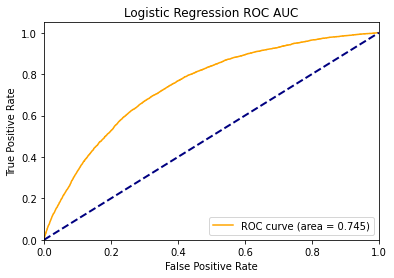

In [70]:
tuned_lr_qua_cat_2 = make_log_reg(x_train=X_train_label.loc[:,rfecv.support_],
                                  y_train=y_train,
                                  x_valid=X_valid_label.loc[:,rfecv.support_],
                                  y_valid=y_valid,
                                  results_df=lr_metrics_cat,
                                  parameters=best_params_qua_cat_2,
                                  model_name='tuned_lr_qua_cat_2')

In [71]:
lr_metrics_cat.style.highlight_max(axis=1, color='lightblue')